In [1]:
import datetime
import random
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
import xarray as xr
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib import colors, font_manager, pyplot
from matplotlib.cm import ScalarMappable
from PIL import Image

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Storm_Figs_V6.6.2/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_hPa_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_hPa_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Birth_Time, Begin_Time, Compl_Time, Death_Time, Peak_Time = [], [], [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Birth_Time.append(Datetime(ET_DF["Genesis Time"][j]))
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Death_Time.append(Datetime(ET_DF["Dissipate Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["Genesis Time"] = Birth_Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Dissipate Time"] = Death_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
# Find a Specific Storm Within the DataFrame
def Find_Storm(DF, Code):
    DF_Storm = DF[DF["Code"] == Code].reset_index()
    return (DF_Storm)

In [7]:
# Create Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [8]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [9]:
# Function to Find Distance Between Two Points
def Find_Distance(y1, y2, x1, x2):
    Start_Lat = y1 * numpy.pi / 180
    End_Lat = y2 * numpy.pi / 180
    Start_Lon = x1 * numpy.pi / 180
    End_Lon = x2 * numpy.pi / 180
    Lat_Diff = End_Lat - Start_Lat
    Lon_Diff = End_Lon - Start_Lon
    Earth_Rad = 6378
    Distance = 2 * Earth_Rad * numpy.sqrt((numpy.sin(Lat_Diff/2))**2 + \
    numpy.cos(Start_Lat) * numpy.cos(End_Lat) * (numpy.sin(Lon_Diff/2))**2)
    return (Distance)

In [10]:
# Create Function to Open Storm Composite Files
def Composite_File(File):
    Diri = '/glade/campaign/univ/upsu0032/Hyperion_ET/composites/'
    Compo_File = xr.open_dataset(Diri + File)
    return (Compo_File)

In [11]:
# Open Storm Composite Files
Control_A_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
Control_B_Compo_nc = Composite_File('composite_h3_CORI.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
Control_C_Compo_nc = Composite_File('composite_h3_CHEY.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')

In [12]:
# Open Storm Composite Files
RCP45_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP45_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.002.nc')
RCP45_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP45.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')

In [13]:
# Open Storm Composite Files
RCP85_A_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.nc')
RCP85_B_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.003.nc')
RCP85_C_Compo_nc = Composite_File('composite_h3_CHEY.RCP85.VR28.NATL.REF.CAM5.4CLM5.0.dtime900.004.nc')

In [14]:
# Create DataFrame With Lat Lon Time Data of the Composite Files
def Composite_DF(Compo_nc, ABC):
    Snap_Time = pandas.Series(Compo_nc.snap_time)
    Snap_Lon = pandas.Series(Compo_nc.snap_lon)
    Snap_Lat = pandas.Series(Compo_nc.snap_lat)
    Snap_PathID = pandas.Series(Compo_nc.snap_pathid)
    Index = numpy.arange(0,len(Snap_Time),1)
    ABC_List = []
    for m in range(len(Index)):
        ABC_List.append(ABC)
    Compo_DF = pandas.DataFrame({"Orig Index": Index, "ABC": ABC_List, \
    "Time": Snap_Time, "Lon": Snap_Lon, "Lat": Snap_Lat, "PathID": Snap_PathID})
    return (Compo_DF)

In [15]:
# Combine Composite DFs
def Combine_Compo_DF(Compo_A, Compo_B, Compo_C):
    Compo_DF_A = Composite_DF(Compo_A, "A")
    Compo_DF_B = Composite_DF(Compo_B, "B")
    Compo_DF_C = Composite_DF(Compo_C, "C")
    Compo_DF = pandas.concat([Compo_DF_A, Compo_DF_B, Compo_DF_C]).reset_index()
    Compo_DF = Compo_DF.drop("index", axis=1)
    return (Compo_DF)

In [16]:
Control_Compo = Combine_Compo_DF(Control_A_Compo_nc, Control_B_Compo_nc, Control_C_Compo_nc)

In [17]:
RCP45_Compo = Combine_Compo_DF(RCP45_A_Compo_nc, RCP45_B_Compo_nc, RCP45_C_Compo_nc)

In [18]:
RCP85_Compo = Combine_Compo_DF(RCP85_A_Compo_nc, RCP85_B_Compo_nc, RCP85_C_Compo_nc)

In [19]:
# Change Year of Data
def Reverse_Update_Year(New_Time, Year_Diff):
    Year_Orig = New_Time.year + Year_Diff
    Orig_Time = New_Time.replace(year=Year_Orig)
    return (Orig_Time)

In [20]:
# Create Function to Find Year Diff
def Year_Diff_Find(New_Time):
    Years = [1900,1930,1960,2000,2031,2062,2100,2131,2162,2193]
    New_Time_Index = -728
    for i in range(len(Years)):
        if i < 3:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 1985 - Years[i]
                New_Time_Index = i
        elif i < 6:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
        else:
            if New_Time.year >= Years[i] and New_Time.year < Years[i+1]:
                Year_Diff = 2070 - Years[i]
                New_Time_Index = i
    if New_Time_Index % 3 == 0:
        ABC = "A"
    elif New_Time_Index % 3 == 1:
        ABC = "B"
    elif New_Time_Index % 3 == 2:
        ABC = "C"
    return (int(Year_Diff), ABC)

In [21]:
# Create Function to Find Indexes of Composite Data For Selected Storm
def Find_Composite_Data(Code, Data_DF, Compo_DF):
    DF_Storm = Find_Storm(Data_DF, Code)
    New_Time = DF_Storm["Time(Z)"]
    Lat = DF_Storm["Lat"]
    Lon = DF_Storm["Lon"]
    SLP = DF_Storm["SLP(hPa)"]
#    Windspeed = DF_Storm["Winds(m/s)"]
    Storm_Phase = DF_Storm["Storm Phase"]
    Compo_Indexes = numpy.zeros(len(New_Time))
    for i in range(len(New_Time)):
        Year_Diff, ABC = Year_Diff_Find(New_Time[0])
        Orig_Time = Reverse_Update_Year(New_Time[i], Year_Diff)
# Find Possible Storms that Occur at the Same Time
        Compo_Storm = Compo_DF[(Compo_DF["ABC"] == ABC) & (Compo_DF["Time"] == Orig_Time)].reset_index()
# If No Storm Found:
        if len(Compo_Storm) == 0:
            Compo_Indexes[i] = -728
# Storms Found:
        else:
            Dist_Min = [7428,-728]
            for c in range(len(Compo_Storm)):
                Dist = Find_Distance(Lat[i], Compo_Storm["Lat"][c], Lon[i], Compo_Storm["Lon"][c])
# Find Storm Closest to Storm Center
                if Dist < Dist_Min[0]:
# At Most 300km of Error in Location Permitted
                    if Dist < 300:
                        Dist_Min = [Dist, Compo_Storm["Orig Index"][c]]
                    else:
                        Dist_Min = [Dist, -728]
            Compo_Indexes[i] = Dist_Min[1]
    DF_Storm_Compo_Init = pandas.DataFrame({"Compo Index": Compo_Indexes, "Time": New_Time, \
    "Lon": Lon, "Lat": Lat, "SLP": SLP, "Storm Phase": Storm_Phase})
# Remove Datapoints With Missing Compo Index
    DF_Storm_Compo = DF_Storm_Compo_Init[DF_Storm_Compo_Init["Compo Index"] >= 0].reset_index()
    DF_Storm_Compo = DF_Storm_Compo.drop("index", axis=1)
    return (DF_Storm_Compo)

In [22]:
# Find 850hPa Windspeed From Compo File
def Windspeed_850hPa(Compo_nc, Compo_Index):
    U850 = numpy.array(Compo_nc.snap_U850[int(Compo_Index)])
    V850 = numpy.array(Compo_nc.snap_V850[int(Compo_Index)])
    Snap_850 = numpy.sqrt(U850 **2 + V850 **2)
    return (Snap_850)

In [23]:
# Find Total Precip Rate From Compo File
def Precip(Compo_nc, Compo_Index):
    Precip_ms = numpy.array(Compo_nc.snap_PRECT[int(Compo_Index)])
    Precip_mmhr = Precip_ms * 3600 * 1000
    return (Precip_mmhr)

In [24]:
# Find 850hPa Max Windspeed and Wind Field Size at Each 6 Hourly Data Point
def Wind_Field_Find(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
    Time_List = DF_Storm_Compo["Time"]
    SLP = DF_Storm_Compo["SLP"]
#
# Create Array to Store Data
    Wind_Field_Info = numpy.zeros((5,len(Compo_Index)))
    Wind_Field_Info[0] = SLP
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find 850hPa Windspeed Snap From Compo_nc
        Snap_850 = Windspeed_850hPa(Compo_nc, Compo_Index[k])
# Find Maximum 850hPa Windspeed
        Windspeed_850 = numpy.max(Snap_850)
        Wind_Field_Info[1][k] = Windspeed_850
# Count Number of Data Points With Windspeed Above 18,25,33m/s
        Snap_Sort = numpy.sort(Snap_850.ravel())
        Count_18 = len(Snap_Sort[Snap_Sort >= 18])
        Count_25 = len(Snap_Sort[Snap_Sort >= 25])
        Count_33 = len(Snap_Sort[Snap_Sort >= 33])
        Wind_Field_Info[2][k] = Count_18
        Wind_Field_Info[3][k] = Count_25
        Wind_Field_Info[4][k] = Count_33
#
# Add Wind Field Info Into DF Storm Compo
    DF_Storm_Compo["850hPa Winds"] = Wind_Field_Info[1]
    DF_Storm_Compo["850hPa 18m/s"] = Wind_Field_Info[2]
    DF_Storm_Compo["850hPa 25m/s"] = Wind_Field_Info[3]
    DF_Storm_Compo["850hPa 33m/s"] = Wind_Field_Info[4]
    return (DF_Storm_Compo, Time_List)

In [25]:
# Find Max Precip and Total Precip Over Area
def Precip_Field_Find(DF_Storm_Compo, Compo_nc):
    Compo_Index = DF_Storm_Compo["Compo Index"]
    Time_List = DF_Storm_Compo["Time"]
#
# Create Array to Store Data
    Precip_Field_Info = numpy.zeros((5,len(Compo_Index)))
#
# At Each 6 Hourly Data Point
    for k in range(len(Compo_Index)):
# Find 850hPa Precip Snap From Compo_nc
        Snap_Precip = Precip(Compo_nc, Compo_Index[k])
# Find Maximum Precip Rate
        Max_Precip = numpy.max(Snap_Precip)
        Precip_Field_Info[0][k] = Max_Precip
# Find Areal Precip Total
        Snap_Sort = numpy.sort(Snap_Precip.ravel())
        Areal_Precip_Total = numpy.sum(Snap_Sort)
        Precip_Field_Info[1][k] = Areal_Precip_Total
# Count Number of Data Points With Precip Rate Above 0.5, 2, 5mm/hr
        Count_05 = len(Snap_Sort[Snap_Sort >= 0.5])
        Count_2 = len(Snap_Sort[Snap_Sort >= 2])
        Count_5 = len(Snap_Sort[Snap_Sort >= 5])
        Precip_Field_Info[2][k] = Count_05
        Precip_Field_Info[3][k] = Count_2
        Precip_Field_Info[4][k] = Count_5
# 
# Add Precip Field Info Into DF Storm Compo
    DF_Storm_Compo["Max Precip Rate"] = Precip_Field_Info[0]
    DF_Storm_Compo["Areal Precip Total"] = Precip_Field_Info[1]
    DF_Storm_Compo["0.5mm/hr"] = Precip_Field_Info[2]
    DF_Storm_Compo["1mm/hr"] = Precip_Field_Info[3]
    DF_Storm_Compo["5mm/hr"] = Precip_Field_Info[4]
    return (DF_Storm_Compo, Time_List)

In [26]:
# Calculate Grid Size Between Each Datapoint
# def Find_Grid_Size()

In [27]:
# Plot Wind Field Information
def SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index, Savefig):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
#
# Use Function to Calculate Wind Field Information
    DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_1 = 'red'
    Colour_2 = 'mediumblue'
#    Colour_3 = 'darkorange'
#
# Axis For Max Windspeed
    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], DF_Storm_Compo_Wind_Field["850hPa Winds"][k], c=Colour_1, marker=Shape, s=38)
#        Ax1.scatter(Time_List[k], DF_Storm_Compo_Wind_Field["Sfc Winds(m/s)"][k], c=Colour_3, marker=Shape, s=38)
    Ax1.plot(Time_List, DF_Storm_Compo_Wind_Field["850hPa Winds"], color=Colour_1, linewidth=1.2, \
    label='850hPa Windspeed')
#    Ax1.plot(Time_List, DF_Storm_Compo_Wind_Field["Sfc Winds(m/s)"], color=Colour_3, linewidth=1.2, \
#    label='Surface Windspeed')
#    pyplot.legend(loc=1)
#
# Axis For Wind Field Size
    Ax2 = Ax1.twinx()
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax2.scatter(Time_List[k], DF_Storm_Compo_Wind_Field["SLP"][k], c=Colour_2, marker=Shape, s=28)
    Ax2.plot(Time_List, DF_Storm_Compo_Wind_Field["SLP"], color=Colour_2, linewidth=1.2, label='Sea Level Pressure')
#
# Formatting
    Ax1, Ax2 = SLP_Windspeed_Axis(DF_Storm_Compo_Wind_Field["SLP"], Ax1, Ax2)
    Ax2 = Time_Axis(Time_List, Ax2)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Ax1.set_ylabel('Max 850hPa Windspeed (m/s)', color=Colour_1, fontsize=12)
    Ax1.tick_params(axis='y', labelcolor=Colour_1)
    Ax2.set_ylabel('Sea Level Pressure (hPa)', color=Colour_2, fontsize=12)
    Ax2.tick_params(axis='y', labelcolor=Colour_2)
    Title = str(Code + ' ' + Storm_Name + " -- Min SLP & Max 850hPa Windspeed")
    pyplot.title(Title, fontsize=16)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            Ax2.plot([Time, Time], [0,7428], c='black', linestyle='--', linewidth=0.8)
    Fig.tight_layout()
#
# Save Fig
    if Savefig == True:
        Figname = str(Code + '_' + Storm_Name + '_SLP_Winds.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [28]:
# Plot Wind Field Information
def Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index, Savefig):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
#
# Use Function to Calculate Wind Field Information
    DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_1 = 'lightseagreen'
    Colour_2 = 'limegreen'
    Colour_3 = 'gold'
#
# Axis For Wind Field Size
    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], DF_Storm_Compo["850hPa 18m/s"][k], c=Colour_1, marker=Shape, s=28)
        Ax1.scatter(Time_List[k], DF_Storm_Compo["850hPa 25m/s"][k], c=Colour_2, marker=Shape, s=28)
        Ax1.scatter(Time_List[k], DF_Storm_Compo["850hPa 33m/s"][k], c=Colour_3, marker=Shape, s=28)
    Ax1.plot(Time_List, DF_Storm_Compo["850hPa 18m/s"], color=Colour_1, linewidth=1.2, label='# Datapoints >= 18m/s')
    Ax1.plot(Time_List, DF_Storm_Compo["850hPa 25m/s"], color=Colour_2, linewidth=1.2, label='# Datapoints >= 25m/s')
    Ax1.plot(Time_List, DF_Storm_Compo["850hPa 33m/s"], color=Colour_3, linewidth=1.2, label='# Datapoints >= 33m/s')
    pyplot.legend(loc=2)
#
# Formatting
    Ax1 = Wind_Field_Axis(DF_Storm_Compo["850hPa 18m/s"], Ax1)
    Ax1 = Time_Axis(Time_List, Ax1)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Ax1.set_ylabel('# Gridpoints', color='darkgreen', fontsize=12)
    Ax1.tick_params(axis='y', labelcolor='darkgreen')
    Title = str(Code + ' ' + Storm_Name + " -- 850hPa Wind Field")
    pyplot.title(Title, fontsize=16)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            Ax1.plot([Time, Time], [0,7428], c='black', linestyle='--', linewidth=0.8)
    Fig.tight_layout()
#
# Save Fig
    if Savefig == True:
        Figname = str(Code + '_' + Storm_Name + '_Wind_Field_850hPa.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [29]:
# Plot Precip Field Information
def Precip_Area_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index, Savefig):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
#
# Use Function to Calculate Precip Field Information
    DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_1 = 'red'
    Colour_2 = 'mediumblue'
#
# Axis For Max Precip Rate
    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], DF_Storm_Compo_Precip_Field["Max Precip Rate"][k], c=Colour_1, marker=Shape, s=38)
    Ax1.plot(Time_List, DF_Storm_Compo_Precip_Field["Max Precip Rate"], color=Colour_1, linewidth=1.2, \
    label='Max Precip Rate')
#
# Axis For Areal Precip Total
    Ax2 = Ax1.twinx()
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax2.scatter(Time_List[k], DF_Storm_Compo_Precip_Field["Areal Precip Total"][k], c=Colour_2, marker=Shape, s=28)
    Ax2.plot(Time_List, DF_Storm_Compo_Precip_Field["Areal Precip Total"], color=Colour_2, linewidth=1.2, \
    label='Areal Precip Total')
#
# Formatting
    Ax1, Ax2 = Precip_Area_Axis(DF_Storm_Compo_Precip_Field["Max Precip Rate"], Ax1, Ax2)
    Ax2 = Time_Axis(Time_List, Ax2)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Ax1.set_ylabel('Max Precip Rate (mm/hr)', color=Colour_1, fontsize=12)
    Ax1.tick_params(axis='y', labelcolor=Colour_1)
    Ax2.set_ylabel('Areal Precip Total (mm/hr #gridpoints)', color=Colour_2, fontsize=12)
    Ax2.tick_params(axis='y', labelcolor=Colour_2)
    Title = str(Code + ' ' + Storm_Name + " -- Max Precip Rate & Areal Precip Total")
    pyplot.title(Title, fontsize=16)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            Ax2.plot([Time, Time], [0,74280], c='black', linestyle='--', linewidth=0.8)
    Fig.tight_layout()
#
# Save Fig
    if Savefig == True:
        Figname = str(Code + '_' + Storm_Name + '_Precip_Area.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [30]:
# Plot Wind Field Information
def Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Snapshot_Index, Savefig):
# Find Storm
    DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
#
# Use Function to Calculate Precip Field Information
    DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)
#
# Define Colours
    Colour_1 = 'deepskyblue'
    Colour_2 = 'dodgerblue'
    Colour_3 = 'limegreen'
#
# Axis For Wind Field Size
    Fig, Ax1 = pyplot.subplots(figsize=(8,6))
    for k in range(len(Time_List)):
        Shape = Plot_Marker(DF_Storm_Compo["Storm Phase"][k])
        Ax1.scatter(Time_List[k], DF_Storm_Compo["0.5mm/hr"][k], c=Colour_1, marker=Shape, s=28)
        Ax1.scatter(Time_List[k], DF_Storm_Compo["1mm/hr"][k], c=Colour_2, marker=Shape, s=28)
        Ax1.scatter(Time_List[k], DF_Storm_Compo["5mm/hr"][k], c=Colour_3, marker=Shape, s=28)
    Ax1.plot(Time_List, DF_Storm_Compo["0.5mm/hr"], color=Colour_1, linewidth=1.2, label='# Datapoints >= 0.5mm/hr')
    Ax1.plot(Time_List, DF_Storm_Compo["1mm/hr"], color=Colour_2, linewidth=1.2, label='# Datapoints >= 1mm/hr')
    Ax1.plot(Time_List, DF_Storm_Compo["5mm/hr"], color=Colour_3, linewidth=1.2, label='# Datapoints >= 5mm/hr')
    pyplot.legend(loc=2)
#
# Formatting
    Ax1 = Wind_Field_Axis(DF_Storm_Compo["0.5mm/hr"], Ax1)
    Ax1 = Time_Axis(Time_List, Ax1)
    Gridline = Ax1.grid(linewidth=0.5, color='silver', linestyle='-')
    Ax1.set_ylabel('# Gridpoints', color='darkgreen', fontsize=12)
    Ax1.tick_params(axis='y', labelcolor='darkgreen')
    Title = str(Code + ' ' + Storm_Name + " -- Precip Field")
    pyplot.title(Title, fontsize=16)
#
# Plot Lines Denoting Snapshot Times
    if len(Snapshot_Index) > 0:
        for s in range(len(Snapshot_Index)):
            Time = list(DF_Storm_Compo[DF_Storm_Compo["Compo Index"] == Snapshot_Index[s]]["Time"])[0]
            Ax1.plot([Time, Time], [0,7428], c='black', linestyle='--', linewidth=0.8)
    Fig.tight_layout()
#
# Save Fig
    if Savefig == True:
        Figname = str(Code + '_' + Storm_Name + '_Precip_Field.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [31]:
def Time_Axis(Time, Ax2):
    x_Min = Time[0] + datetime.timedelta(hours=-6)
    x_Max = Time[len(Time)-1] + datetime.timedelta(hours=6)
    x_Start = datetime.date(x_Min.year,x_Min.month,x_Min.day) + datetime.timedelta(1)
    x_End = datetime.date(x_Max.year,x_Max.month,x_Max.day) + datetime.timedelta(1)
    if len(Time) < 60:
        x_Axis = pandas.date_range(x_Start,x_End,freq='2D')
    else:
        x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
    Ax2.set_xlabel('Time (Z)', fontsize=12)
    Ax2.set_xticks(x_Axis)
    Ax2.set_xlim(x_Min,x_Max)
    return (Ax2)

In [32]:
def SLP_Windspeed_Axis(SLP, Ax1, Ax2):
    y_Min = int(numpy.min(SLP) / 10) * 10
    if y_Min > 940:
        Ax2.set_yticks(Create_Bins(940,1020,10))
        Ax2.set_ylim(940,1020)
        Ax1.set_yticks(Create_Bins(0,80,10))
        Ax1.set_ylim(0,80)
    else:
        Ax2.set_yticks(Create_Bins(y_Min,1020,10))
        Ax2.set_ylim(y_Min,1020)
        y_Max = 1020-y_Min
        Ax1.set_yticks(Create_Bins(0,y_Max,10))
        Ax1.set_ylim(0,y_Max)
    return (Ax1, Ax2)

In [33]:
def Wind_Field_Axis(Gale_Count, Ax1):
    y_Max = int(numpy.max(Gale_Count) / 100 + 1) * 100
    if y_Max <= 600:
        Ax1.set_yticks(Create_Bins(0,600,50))
        Ax1.set_ylim(0,600)
    elif y_Max <= 1200:
        Ax1.set_yticks(Create_Bins(0,y_Max,100))
        Ax1.set_ylim(0,y_Max)
    elif y_Max <= 3000:
        Ax1.set_yticks(Create_Bins(0,y_Max,200))
        Ax1.set_ylim(0,y_Max)
    else:
        Ax1.set_yticks(Create_Bins(0,y_Max,500))
        Ax1.set_ylim(0,y_Max)
    return (Ax1)

In [34]:
def Precip_Area_Axis(Max_Precip, Ax1, Ax2):
    y_Max = int(numpy.max(Max_Precip) / 10 + 1) * 10
    if y_Max < 50:
        Ax1.set_yticks(Create_Bins(0,y_Max,10))
        Ax1.set_ylim(0,50)
        Ax2.set_yticks(Create_Bins(0,2500,500))
        Ax2.set_ylim(0,2500)
    else:
        Ax1.set_yticks(Create_Bins(0,y_Max,10))
        Ax1.set_ylim(0,y_Max)
        Ax2.set_yticks(Create_Bins(0,y_Max*50,500))
        Ax2.set_ylim(0,y_Max*50)
    return (Ax1, Ax2)

In [35]:
def Precip_Field_Axis(Count, Ax1):
    y_Max = int(numpy.max(Count) / 100 + 1) * 100
    if y_Max <= 600:
        Ax1.set_yticks(Create_Bins(0,600,50))
        Ax1.set_ylim(0,600)
    elif y_Max <= 1200:
        Ax1.set_yticks(Create_Bins(0,y_Max,100))
        Ax1.set_ylim(0,y_Max)
    elif y_Max <= 3000:
        Ax1.set_yticks(Create_Bins(0,y_Max,200))
        Ax1.set_ylim(0,y_Max)
    else:
        Ax1.set_yticks(Create_Bins(0,y_Max,500))
        Ax1.set_ylim(0,y_Max)
    return (Ax1)

In [36]:
# Plot Marker
def Plot_Marker(Storm_Phase):
    if Storm_Phase == "Tropical":
        Shape = 'o'
    elif Storm_Phase == "Transition":
        Shape = 's'
    else:
        Shape = '^'
    return (Shape)

In [37]:
# Define Colours and Bounds
Windspeed_Colours = ['white', 'cyan', 'lightseagreen', 'limegreen', 'gold', 'darkorange', 'red', 'darkviolet']
Windspeed_Bounds = numpy.array([13,18,25,33,41,50,60])
Precip_Colours = ['white', 'cyan', 'deepskyblue', 'dodgerblue', 'lightseagreen', 'limegreen', 'greenyellow', \
'gold', 'darkorange', 'red', 'darkviolet']
Precip_Bounds = numpy.array([0.1,0.5,1,2,5,10,20,30,50,70])

In [38]:
# Create Function to Plot Contour Maps
def Contour_Map(Snap, x_Snap, y_Snap, Bounds, Colours, Storm_Name, Time_Label, Var, x_Label):
# Add Corrdinate Lines
    pyplot.plot([-728,728], [0,0], c='black', linestyle='-', linewidth=0.8)
    pyplot.plot([0,0], [-728,728], c='black', linestyle='-', linewidth=0.8)
# Initial Indexes
    i_Init = 0
    j_Init = 0
    i_Fin = 80
    j_Fin = 80
# Plot Contour Map
    pyplot.contourf(x_Snap, y_Snap, Snap, levels=Bounds, colors=Colours, extend='both')
# Formatting
    x_Min = float(x_Snap[i_Init])
    x_Max = float(x_Snap[i_Fin-1])
    y_Min = float(y_Snap[j_Init])
    y_Max = float(y_Snap[j_Fin-1])
    pyplot.xlim(x_Min,x_Max)
    pyplot.ylim(y_Min,y_Max)
    if x_Label == True:
        pyplot.xlabel('Lon Diff From Storm Center', fontsize=12)
    pyplot.ylabel('Lat Diff From Storm Center', fontsize=12)
#    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')
    Title = str(Storm_Name + (' -- ') + Time_Label)
    pyplot.title(Title, fontsize=18)

In [39]:
# Plot Four Windspeed Snap Plots
def Windspeed_Snap_Plots(Compo_nc, DF, Code, Storm_Name, Indexes, Time_Labels, Bounds, Colours, Savefig):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
    Storm_Code_Name = str(Code + ' ' + Storm_Name)
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
# First Plot
    Axis = Fig.add_subplot(2,2,1)
    Windspeed_Snap_1 = numpy.array(Windspeed_850hPa(Compo_nc, Indexes[0]))
    Contour_Map(Windspeed_Snap_1, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[0], "Windspeed", False)
#
# Second Plot
    Axis = Fig.add_subplot(2,2,2)
    Windspeed_Snap_2 = numpy.array(Windspeed_850hPa(Compo_nc, Indexes[1]))
    Contour_Map(Windspeed_Snap_2, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[1], "Windspeed", False)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("850hPa Windspeeds", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.85, -0.095, 1.5, 0.025], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label='850hPa Windspeeds (m/s)', shrink=0.7)
#
# Third Plot
    Axis = Fig.add_subplot(2,2,3)
    Windspeed_Snap_3 = numpy.array(Windspeed_850hPa(Compo_nc, Indexes[2]))
    Contour_Map(Windspeed_Snap_3, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[2], "Windspeed", True)
#
# Fourth Plot
    Axis = Fig.add_subplot(2,2,4)
    Windspeed_Snap_4 = numpy.array(Windspeed_850hPa(Compo_nc, Indexes[3]))
    Contour_Map(Windspeed_Snap_4, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[3], "Windspeed", True)
#
# Save Fig
    if Savefig == True:
        Figname = str(Code + '_' + Storm_Name + '_Wind_Snapshot.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [40]:
# Plot Four Precip Rate Snap Plots
def Precip_Snap_Plots(Compo_nc, DF, Code, Storm_Name, Indexes, Time_Labels, Bounds, Colours, Savefig):
# x and y Values
    x_Snap = Compo_nc.x
    y_Snap = Compo_nc.y
    Storm_Code_Name = str(Code + ' ' + Storm_Name)
#
# Create Fig
    Fig = pyplot.figure(figsize=(16,16))
# First Plot
    Axis = Fig.add_subplot(2,2,1)
    Precip_Snap_1 = Precip(Compo_nc, Indexes[0])
    Contour_Map(Precip_Snap_1, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[0], "Precip", False)
#
# Second Plot
    Axis = Fig.add_subplot(2,2,2)
    Precip_Snap_2 = Precip(Compo_nc, Indexes[1])
    Contour_Map(Precip_Snap_2, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[1], "Precip", False)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("Precip Rate", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.85, -0.095, 1.5, 0.025], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', \
    cax=Cax, label='Precip Rate (mm/hr)', shrink=0.7)
#
# Third Plot
    Axis = Fig.add_subplot(2,2,3)
    Precip_Snap_3 = Precip(Compo_nc, Indexes[2])
    Contour_Map(Precip_Snap_3, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[2], "Precip", True)
#
# Fourth Plot
    Axis = Fig.add_subplot(2,2,4)
    Precip_Snap_4 = Precip(Compo_nc, Indexes[3])
    Contour_Map(Precip_Snap_4, x_Snap, y_Snap, Bounds, Colours, Storm_Code_Name, Time_Labels[3], "Precip", True)
#
# Save Fig
    if Savefig == True:
        Figname = str(Code + '_' + Storm_Name + '_Precip_Snapshot.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [41]:
# Some Example Storms

In [42]:
# Find Wind Field Composite Data
Code = "TC191304"
Storm_Name = "Melody"
Data_DF = Control_Data
ET_DF = Control_ET
Compo_DF = Control_Compo
Compo_nc = Control_A_Compo_nc
Time_Indexes = [3971,3987,3993,3999]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [43]:
DF_Storm_Compo_Wind_Field

Compo Index                Time    Lon    Lat      SLP    Storm Phase  \
0        3939.0 1913-08-24 18:00:00 -29.23  12.08  1009.06       Tropical   
1        3940.0 1913-08-25 00:00:00 -30.72  12.24  1008.81       Tropical   
2        3941.0 1913-08-25 06:00:00 -32.20  12.39  1008.55       Tropical   
3        3942.0 1913-08-25 12:00:00 -32.75  12.73  1009.37       Tropical   
4        3943.0 1913-08-25 18:00:00 -33.18  12.98  1006.78       Tropical   
..          ...                 ...    ...    ...      ...            ...   
59       3998.0 1913-09-08 12:00:00 -54.44  47.83   966.69     Transition   
60       3999.0 1913-09-08 18:00:00 -51.01  50.86   968.71  Extratropical   
61       4000.0 1913-09-09 00:00:00 -49.23  52.42   969.92  Extratropical   
62       4001.0 1913-09-09 06:00:00 -47.44  53.98   971.13  Extratropical   
63       4002.0 1913-09-09 12:00:00 -46.75  54.75   971.93  Extratropical   

    850hPa Winds  850hPa 18m/s  850hPa 25m/s  850hPa 33m/s  Max Precip Rate  \
0      18.763699           4.0           0.0           0.0        18.045139   
1      17.738256           0.0           0.0           0.0        30.641161   
2      18.313313           7.0           0.0           0.0        22.819616   
3      17.498926           0.0           0.0           0.0        16.544621   
4      18.925072           5.0           0.0           0.0         8.818440   
..           ...           ...           ...           ...              ...   
59     41.149590        2652.0        1418.0         436.0        22.435577   
60     40.247997        2478.0        1330.0         324.0         9.796552   
61     39.437592        2508.0        1250.0          99.0        11.214552   
62     42.235401        2622.0        1409.0         170.0        17.085924   
63     43.938919        2351.0        1128.0         291.0         4.408646   

    Areal Precip Total  0.5mm/hr  1mm/hr  5mm/hr  
0          1581.759888     960.0    96.0    22.0  
1          1676.721680     948.0   101.0    28.0  
2          2080.714355    1090.0   119.0    47.0  
3          1446.094727     703.0    74.0    37.0  
4          1012.449890     478.0    54.0    11.0  
..                 ...       ...     ...     ...  
59         2433.005859     771.0   381.0   131.0  
60         1767.507935     778.0   300.0    36.0  
61         1688.439697     812.0   267.0    38.0  
62         1817.789307     788.0   332.0    37.0  
63         1235.610229     674.0   212.0     0.0  

[64 rows x 15 columns]

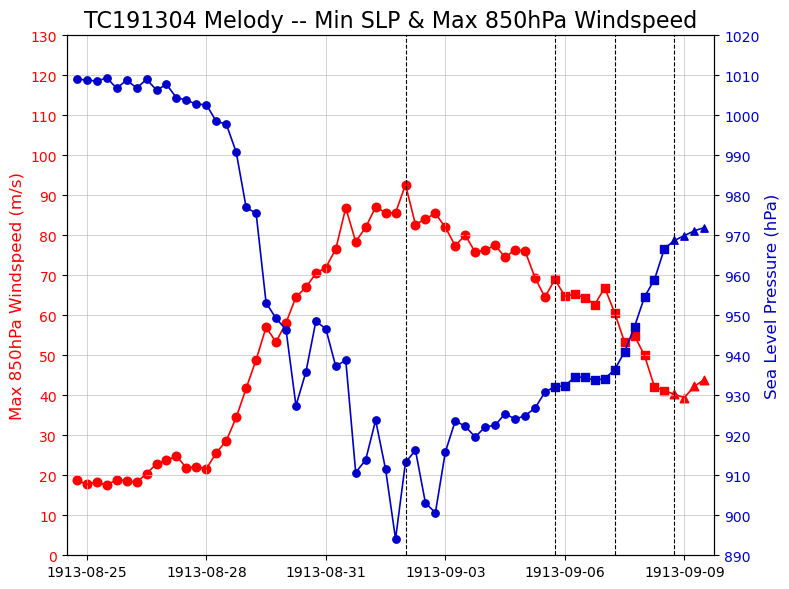

In [44]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

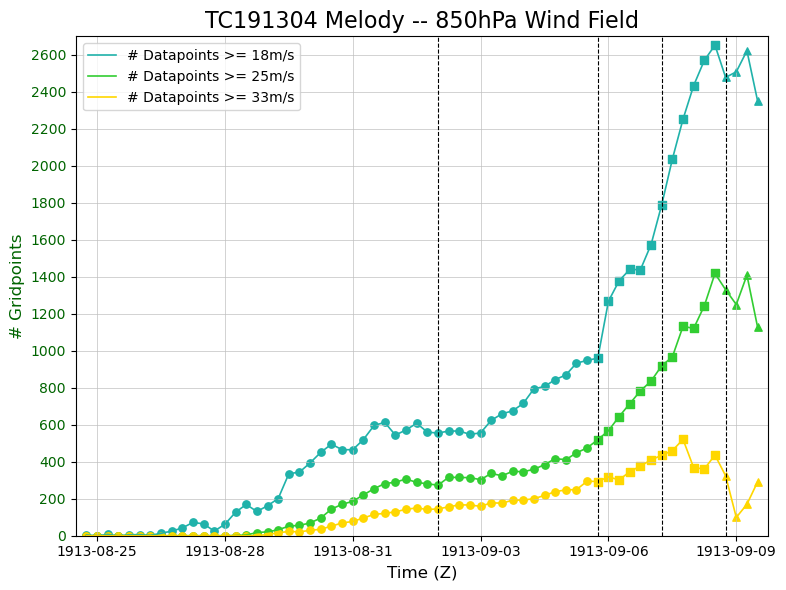

In [45]:
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

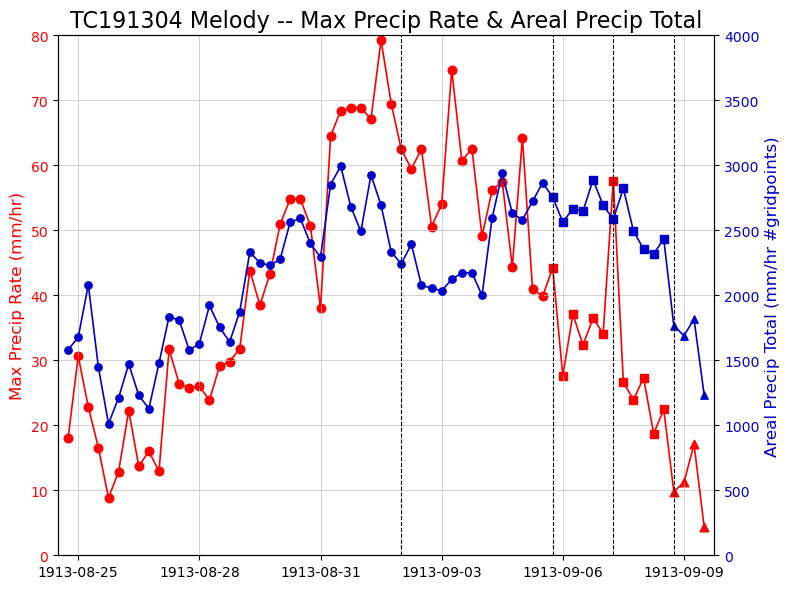

In [46]:
# Plot Max Precip Rate and Areal Precip Total
Precip_Area_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

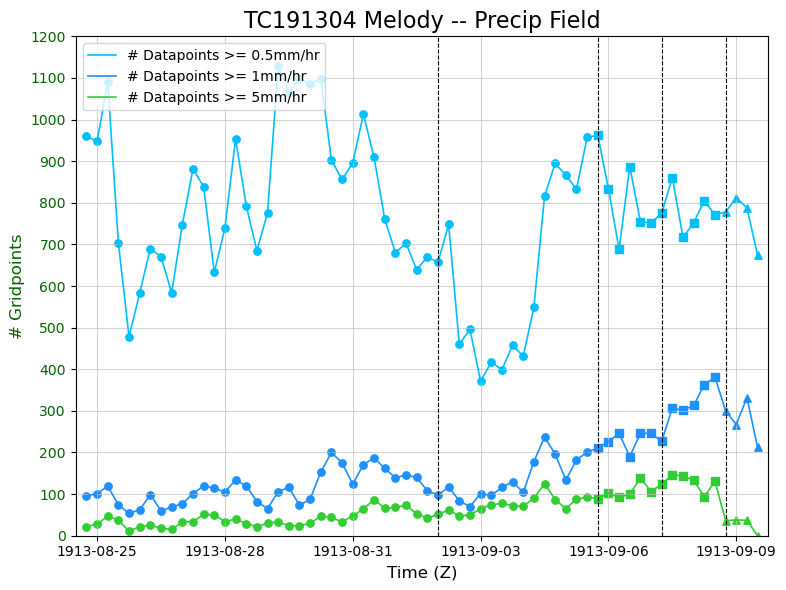

In [47]:
# Plot Precip Field Information
Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

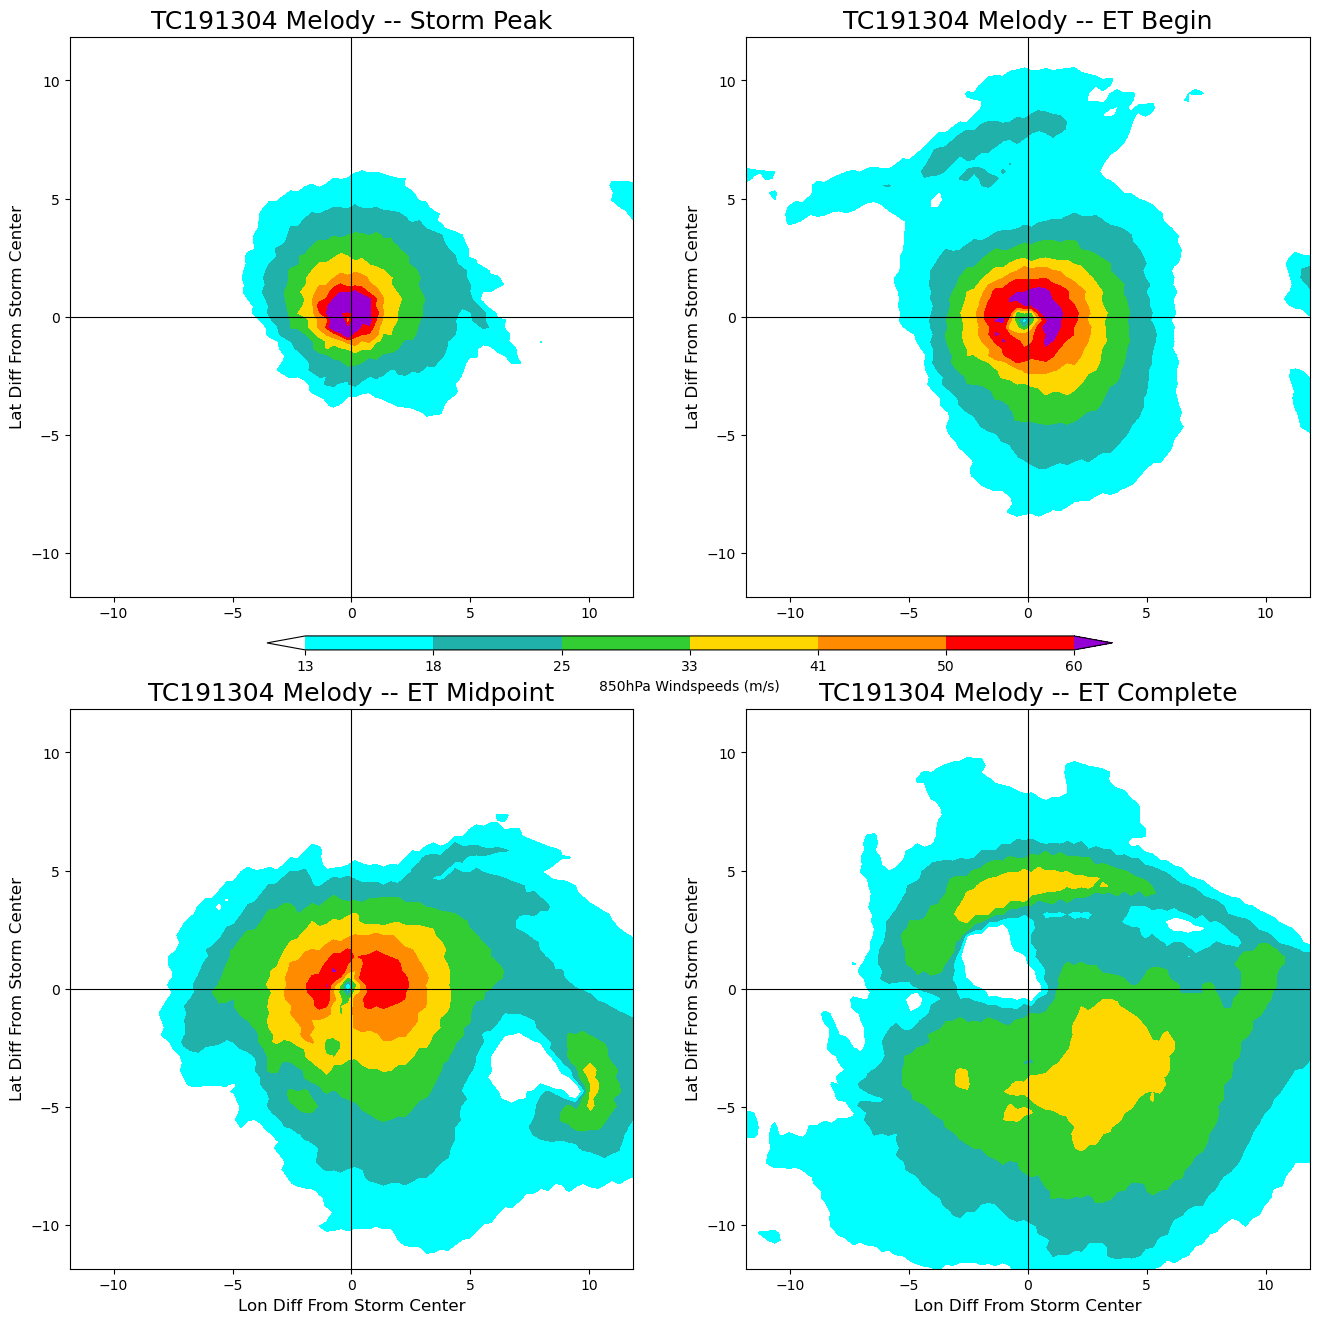

In [48]:
# Plot 850hPa Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Windspeed_Bounds, Windspeed_Colours, True)

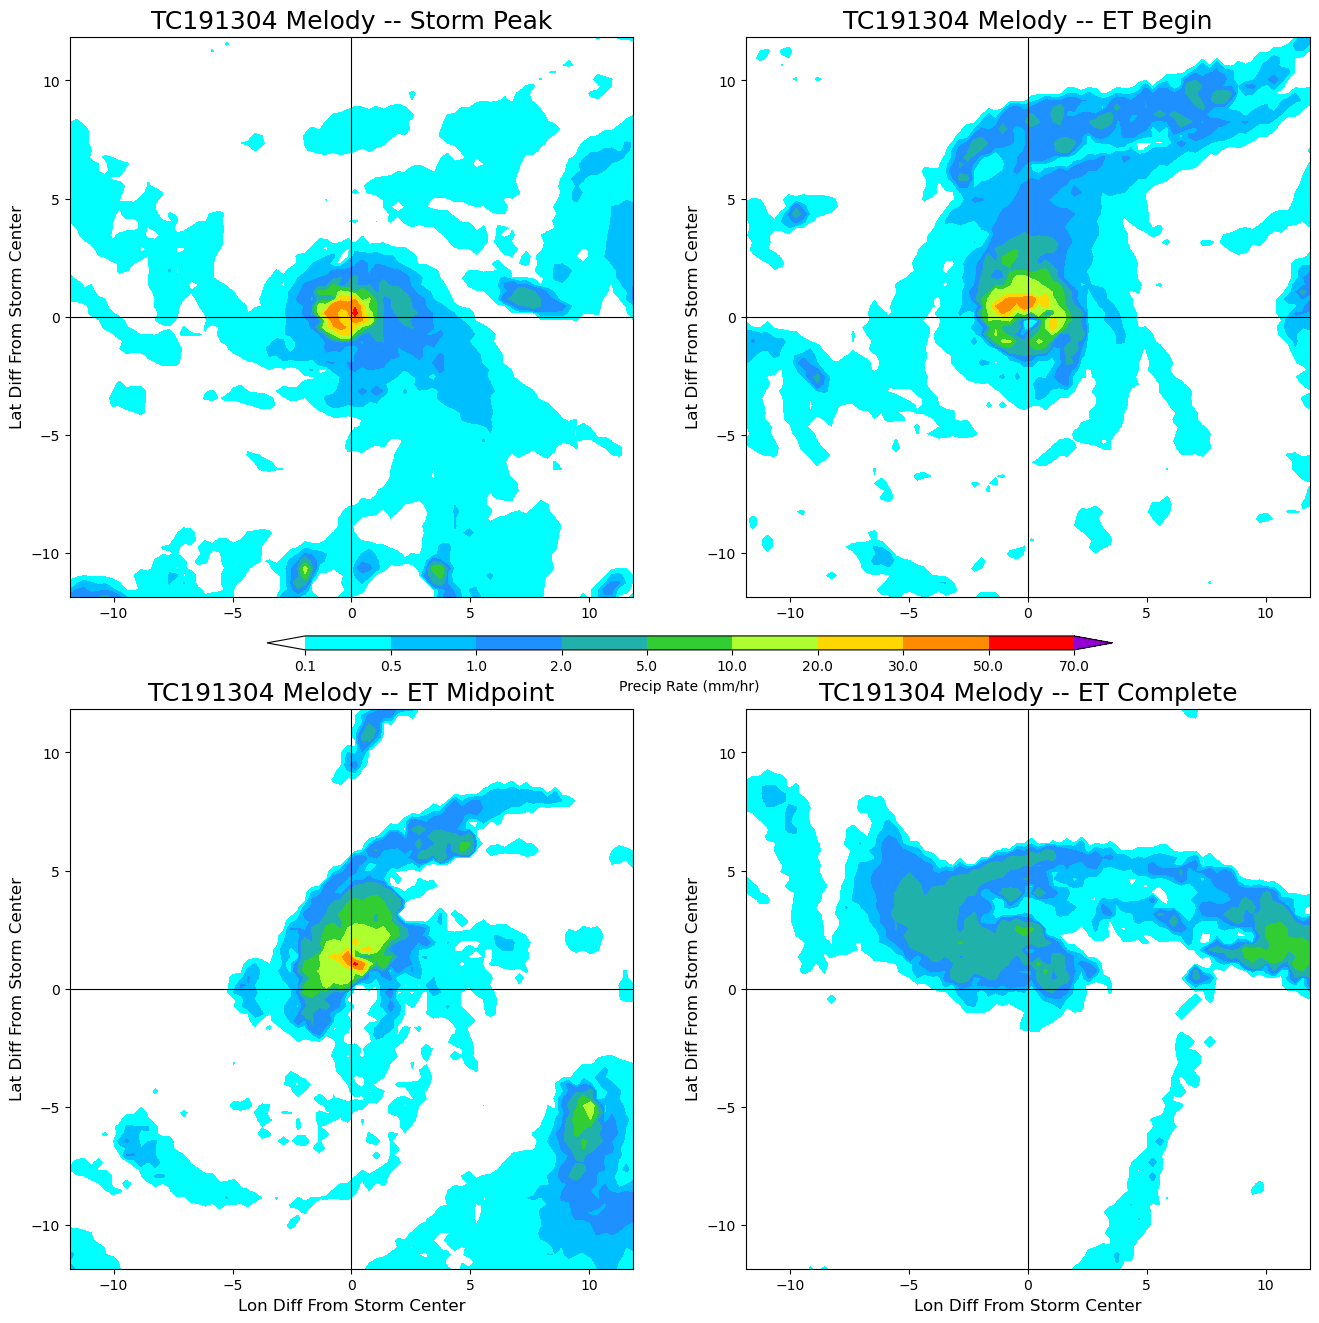

In [49]:
# Plot Precip Rate Snapshots
Precip_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Precip_Bounds, Precip_Colours, True)

In [50]:
# Find Wind Field Composite Data
Code = "TC190003"
Storm_Name = "Colin"
Data_DF = Control_Data
ET_DF = Control_ET
Compo_DF = Control_Compo
Compo_nc = Control_A_Compo_nc
Time_Indexes = [130,139,144,149]
Time_Labels = ["Initial Storm Peak", "ET Begin", "ET Midpoint/Storm Peak", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [51]:
DF_Storm_Compo_Wind_Field

Compo Index                Time    Lon    Lat      SLP    Storm Phase  \
0         106.0 1900-09-09 18:00:00 -32.20  12.39  1010.48       Tropical   
1         107.0 1900-09-10 00:00:00 -33.72  12.32  1012.26       Tropical   
2         108.0 1900-09-10 06:00:00 -34.72  12.33  1010.48       Tropical   
3         109.0 1900-09-10 12:00:00 -36.53  12.93  1010.83       Tropical   
4         110.0 1900-09-10 18:00:00 -38.63  13.63  1008.41       Tropical   
5         111.0 1900-09-11 00:00:00 -41.07  14.18  1009.59       Tropical   
6         112.0 1900-09-11 06:00:00 -43.66  14.44  1004.83       Tropical   
7         113.0 1900-09-11 12:00:00 -46.13  14.37  1000.66       Tropical   
8         114.0 1900-09-11 18:00:00 -48.07  14.89   996.49       Tropical   
9         115.0 1900-09-12 00:00:00 -49.98  15.28   988.58       Tropical   
10        116.0 1900-09-12 06:00:00 -52.06  15.95   993.85       Tropical   
11        117.0 1900-09-12 12:00:00 -54.16  16.60   997.87       Tropical   
12        118.0 1900-09-12 18:00:00 -57.05  17.43   999.06       Tropical   
13        119.0 1900-09-13 00:00:00 -59.19  18.01  1000.21       Tropical   
14        120.0 1900-09-13 06:00:00 -61.35  18.56   995.06       Tropical   
15        121.0 1900-09-13 12:00:00 -63.51  19.07   993.05       Tropical   
16        122.0 1900-09-13 18:00:00 -65.56  19.38   987.60       Tropical   
17        123.0 1900-09-14 00:00:00 -67.12  19.56   978.75       Tropical   
18        124.0 1900-09-14 06:00:00 -68.62  19.76   978.21       Tropical   
19        125.0 1900-09-14 12:00:00 -70.00  20.41   971.69       Tropical   
20        126.0 1900-09-14 18:00:00 -71.63  21.37   976.90       Tropical   
21        127.0 1900-09-15 00:00:00 -73.34  22.42   971.48       Tropical   
22        128.0 1900-09-15 06:00:00 -74.67  22.92   962.81       Tropical   
23        129.0 1900-09-15 12:00:00 -75.91  23.86   956.13       Tropical   
24        130.0 1900-09-15 18:00:00 -77.15  24.55   943.73       Tropical   
25        131.0 1900-09-16 00:00:00 -77.94  25.57   963.15       Tropical   
26        132.0 1900-09-16 06:00:00 -78.58  26.03   969.36       Tropical   
27        133.0 1900-09-16 12:00:00 -78.88  26.75   968.64       Tropical   
28        134.0 1900-09-16 18:00:00 -78.91  27.68   962.04       Tropical   
29        135.0 1900-09-17 00:00:00 -78.38  28.60   963.91       Tropical   
30        136.0 1900-09-17 06:00:00 -78.56  29.16   963.11       Tropical   
31        137.0 1900-09-17 12:00:00 -78.07  29.78   964.09       Tropical   
32        138.0 1900-09-17 18:00:00 -77.81  30.68   960.08       Tropical   
33        139.0 1900-09-18 00:00:00 -77.17  31.14   952.06     Transition   
34        140.0 1900-09-18 06:00:00 -76.38  31.96   955.52     Transition   
35        141.0 1900-09-18 12:00:00 -75.60  32.93   947.63     Transition   
36        142.0 1900-09-18 18:00:00 -74.57  34.16   941.42     Transition   
37        143.0 1900-09-19 00:00:00 -73.12  35.80   935.80     Transition   
38        144.0 1900-09-19 06:00:00 -72.24  37.55   935.05     Transition   
39        145.0 1900-09-19 12:00:00 -70.67  39.42   934.83     Transition   
40        146.0 1900-09-19 18:00:00 -68.70  41.44   941.84     Transition   
41        147.0 1900-09-20 00:00:00 -66.77  43.35   950.94     Transition   
42        148.0 1900-09-20 06:00:00 -64.38  45.37   973.13     Transition   
43        149.0 1900-09-20 12:00:00 -62.68  47.61   979.68  Extratropical   
44        150.0 1900-09-20 18:00:00 -60.41  49.34   981.64  Extratropical   

    850hPa Winds  850hPa 18m/s  850hPa 25m/s  850hPa 33m/s  Max Precip Rate  \
0      16.536312           0.0           0.0           0.0        17.010376   
1      18.722084          11.0           0.0           0.0         4.680356   
2      19.950180          44.0           0.0           0.0         8.481644   
3      24.318329          77.0           0.0           0.0         8.405266   
4      25.433790          45.0           2.0           0.0        

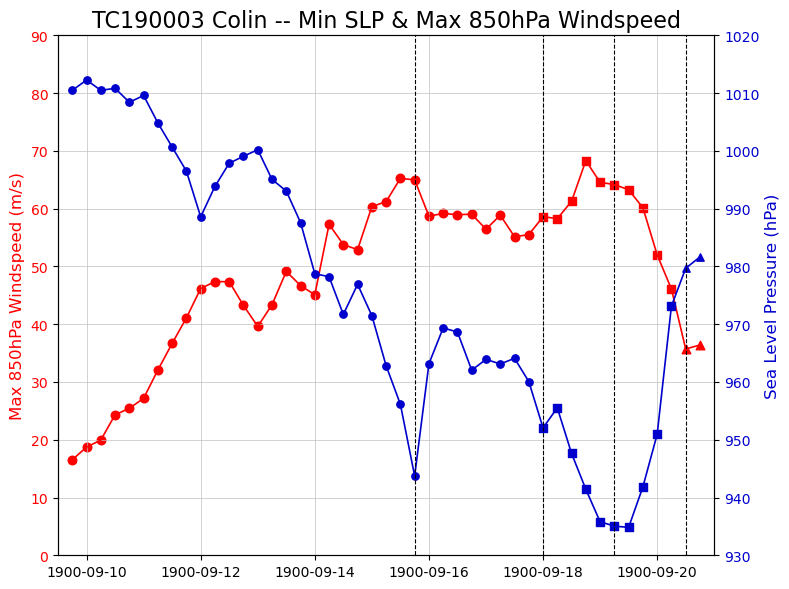

In [52]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

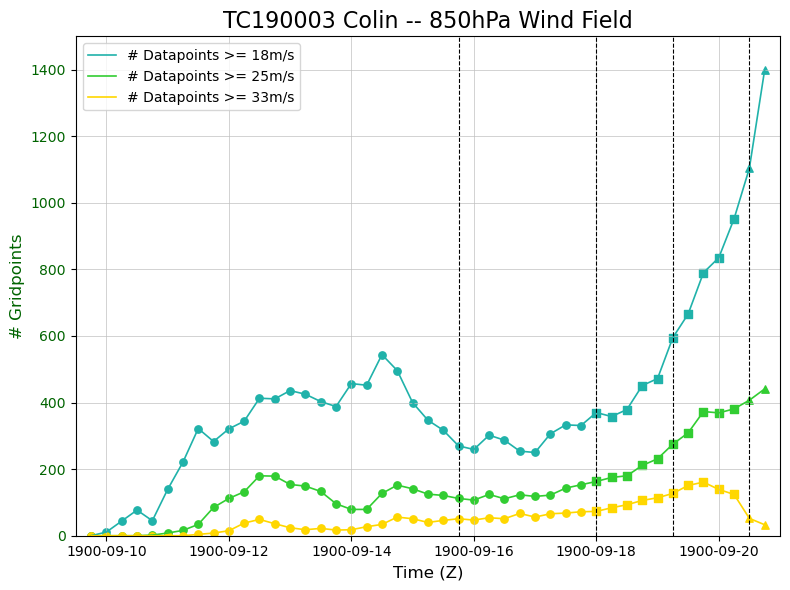

In [53]:
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

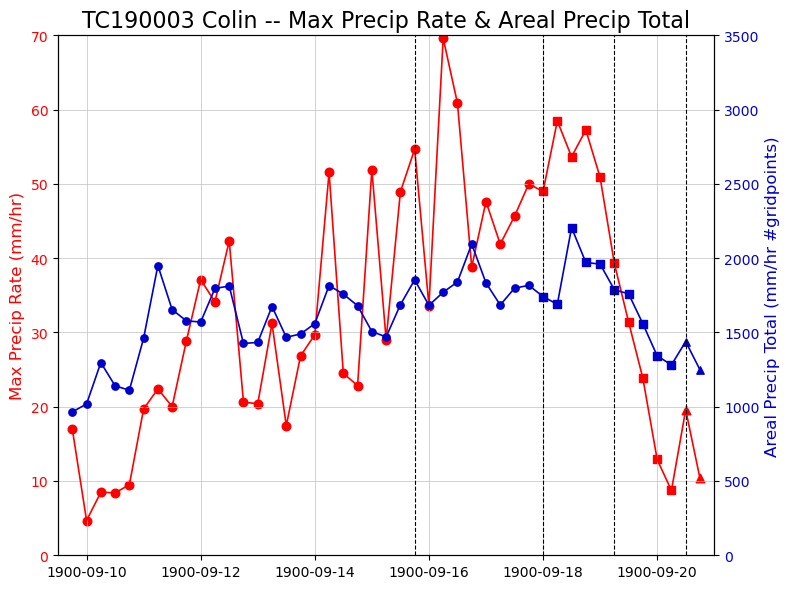

In [54]:
# Plot Max Precip Rate and Areal Precip Total
Precip_Area_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

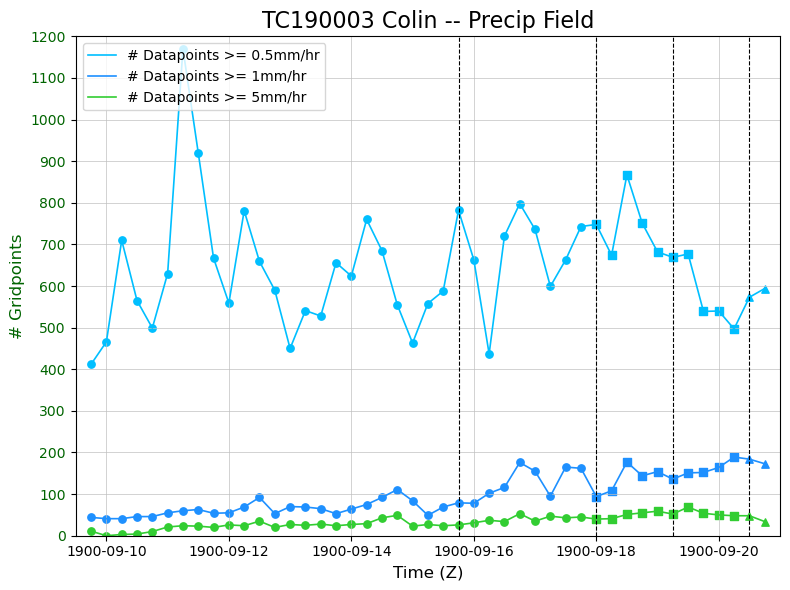

In [55]:
# Plot Precip Field Information
Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

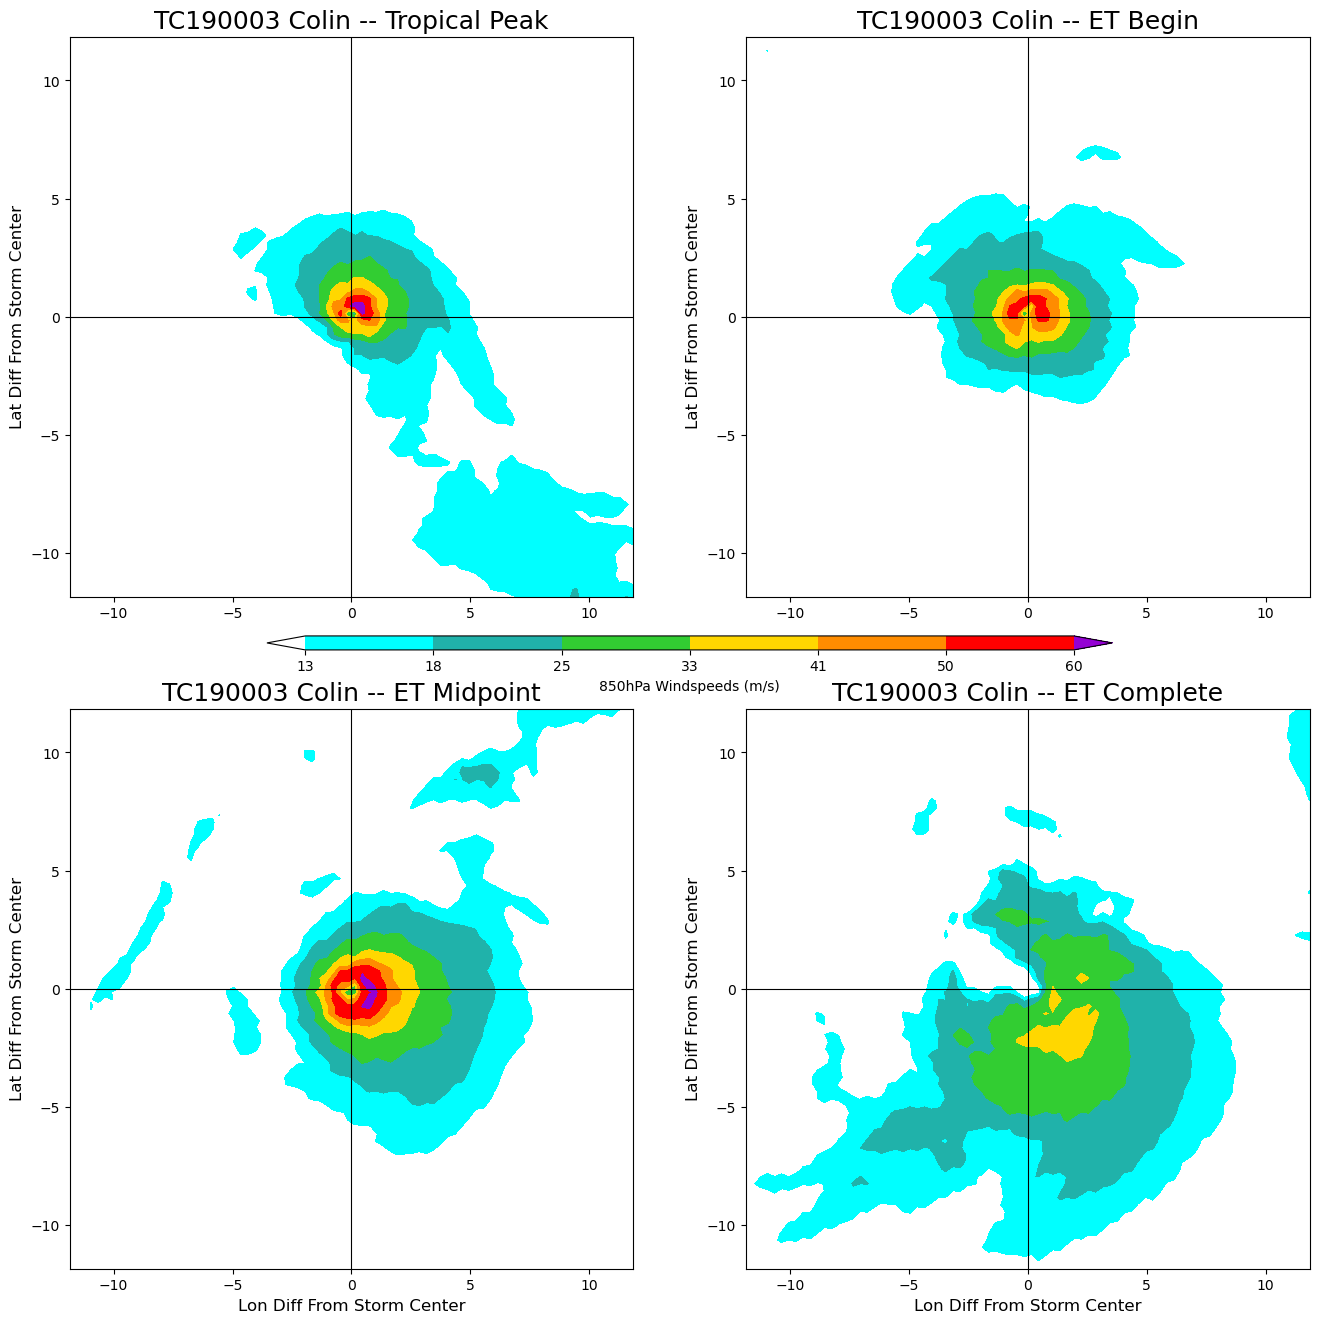

In [56]:
# Plot 850hPa Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Windspeed_Bounds, Windspeed_Colours, True)

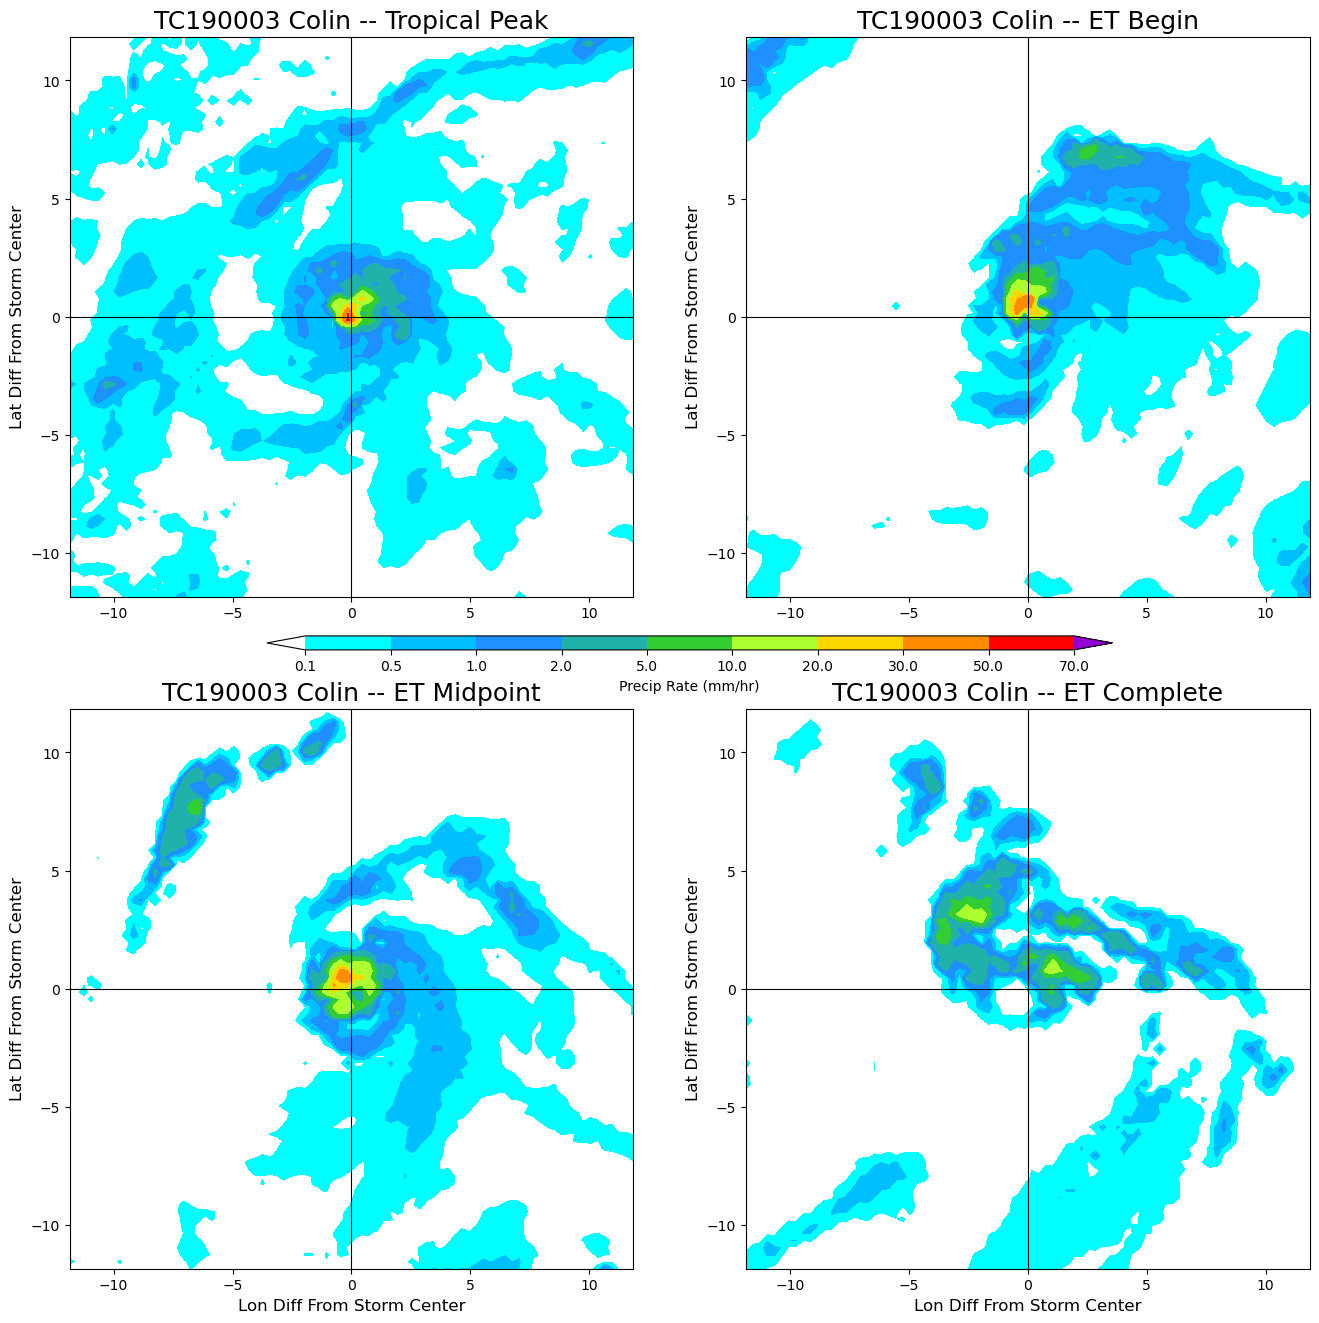

In [57]:
# Plot Precip Rate Snapshots
Precip_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Precip_Bounds, Precip_Colours, True)

In [58]:
# Find Wind Field Composite Data
Code = "TC197807"
Storm_Name = "Maho"
Data_DF = Control_Data
ET_DF = Control_ET
Compo_DF = Control_Compo
Compo_nc = Control_C_Compo_nc
Time_Indexes = [6131,6135,6141,6147]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [59]:
DF_Storm_Compo_Wind_Field[30:]

Compo Index                Time    Lon    Lat     SLP    Storm Phase  \
30       6119.0 1978-10-05 00:00:00 -74.82  16.11  937.76       Tropical   
31       6120.0 1978-10-05 06:00:00 -76.15  16.30  939.70       Tropical   
32       6121.0 1978-10-05 12:00:00 -77.35  16.08  940.76       Tropical   
33       6122.0 1978-10-05 18:00:00 -78.66  16.24  919.61       Tropical   
34       6123.0 1978-10-06 00:00:00 -79.69  16.35  913.76       Tropical   
35       6124.0 1978-10-06 06:00:00 -80.76  16.17  913.03       Tropical   
36       6125.0 1978-10-06 12:00:00 -81.43  16.15  894.41       Tropical   
37       6126.0 1978-10-06 18:00:00 -82.16  16.21  904.51       Tropical   
38       6127.0 1978-10-07 00:00:00 -82.62  16.49  898.69       Tropical   
39       6128.0 1978-10-07 06:00:00 -82.90  16.51  901.27       Tropical   
40       6129.0 1978-10-07 12:00:00 -82.85  16.79  900.19       Tropical   
41       6130.0 1978-10-07 18:00:00 -83.10  17.48  905.55       Tropical   
42       6131.0 1978-10-08 00:00:00 -82.97  18.23  887.03       Tropical   
43       6132.0 1978-10-08 06:00:00 -82.68  19.12  891.19       Tropical   
44       6133.0 1978-10-08 12:00:00 -82.16  20.04  888.75       Tropical   
45       6134.0 1978-10-08 18:00:00 -81.76  21.69  891.11       Tropical   
46       6135.0 1978-10-09 00:00:00 -81.29  23.24  919.28     Transition   
47       6136.0 1978-10-09 06:00:00 -80.25  24.75  934.35     Transition   
48       6137.0 1978-10-09 12:00:00 -79.49  26.28  945.00     Transition   
49       6138.0 1978-10-09 18:00:00 -78.74  27.81  952.54     Transition   
50       6139.0 1978-10-10 00:00:00 -77.80  29.46  955.62     Transition   
51       6140.0 1978-10-10 06:00:00 -77.21  30.85  958.13     Transition   
52       6141.0 1978-10-10 12:00:00 -76.72  32.69  962.94     Transition   
53       6142.0 1978-10-10 18:00:00 -75.76  34.31  967.60     Transition   
54       6143.0 1978-10-11 00:00:00 -74.97  35.81  971.79     Transition   
55       6144.0 1978-10-11 06:00:00 -73.56  37.15  975.08     Transition   
56       6145.0 1978-10-11 12:00:00 -72.17  38.01  979.78     Transition   
57       6146.0 1978-10-11 18:00:00 -69.80  38.48  982.29     Transition   
58       6147.0 1978-10-12 00:00:00 -66.29  39.47  985.49  Extratropical   
59       6148.0 1978-10-12 06:00:00 -61.86  40.75  988.56  Extratropical   
60       6149.0 1978-10-12 12:00:00 -56.00  42.25  991.01  Extratropical   

    850hPa Winds  850hPa 18m/s  850hPa 25m/s  850hPa 33m/s  Max Precip Rate  \
30     65.661377         345.0         171.0          85.0        43.030540   
31     65.506645         383.0         192.0          87.0        30.167070   
32     67.817696         392.0         198.0          85.0        50.425705   
33     73.266960         403.0         196.0          94.0        35.990517   
34     77.249527         406.0         209.0          98.0        56.855274   
35     78.075981         462.0         220.0         105.0        69.031151   
36     76.846428         506.0         219.0         120.0        56.645058   
37     80.190254         512.0         251.0         125.0        67.614380   
38     80.802460         582.0         271.0         149.0        76.538902   
39     79.604919         720.0         304.0         157.0        74.480064   
40     78.982216         752.0         313.0         166.0        57.911926   
41     76.604790         782.0         358.0         181.0        64.384308   
42     85.291649         784.0         405.0         193.0        77.378830   
43     85.403618         831.0         450.0         214.0        66.696983   
44     86.886810         807.0         450.0         229.0        75.035851   
45     82.240067         840.0         467.0         255.0        40.550640   
46     72.102211         879.0         497.0         275.0        61.706749   
47     69.149590         910.0         525.0         275.0        48.610779   
48     60.627430         895.0         502.0         257.0        42.4

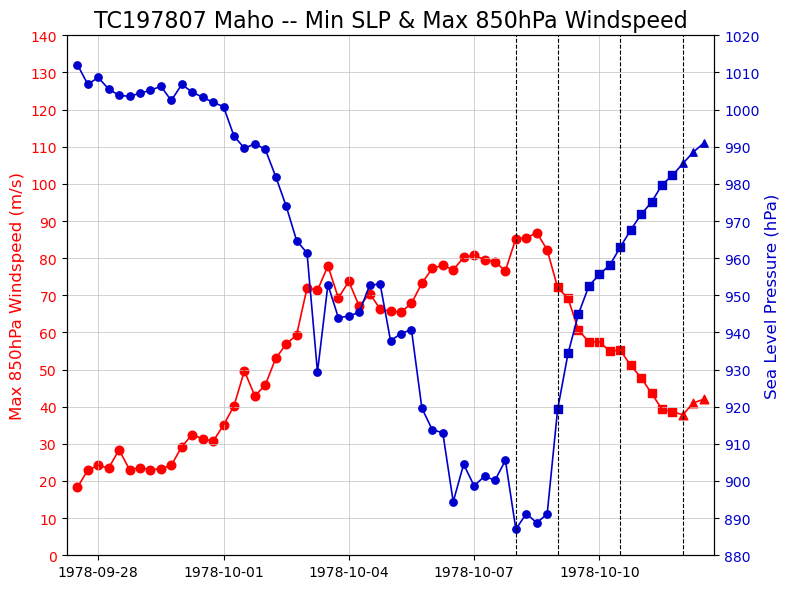

In [60]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

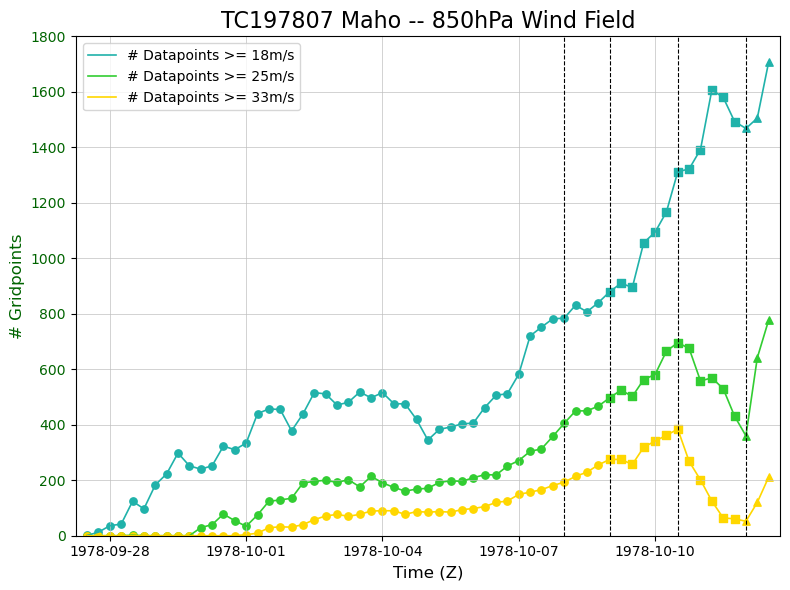

In [61]:
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

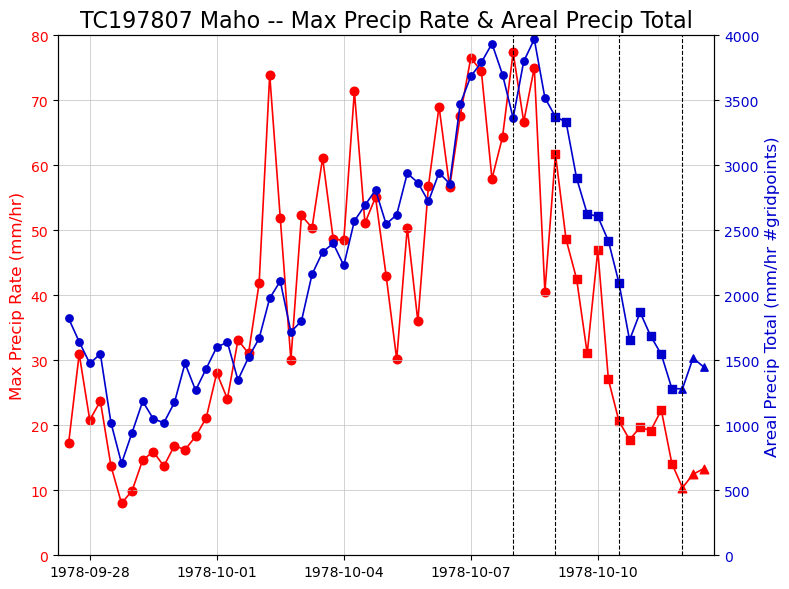

In [62]:
# Plot Max Precip Rate and Areal Precip Total
Precip_Area_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

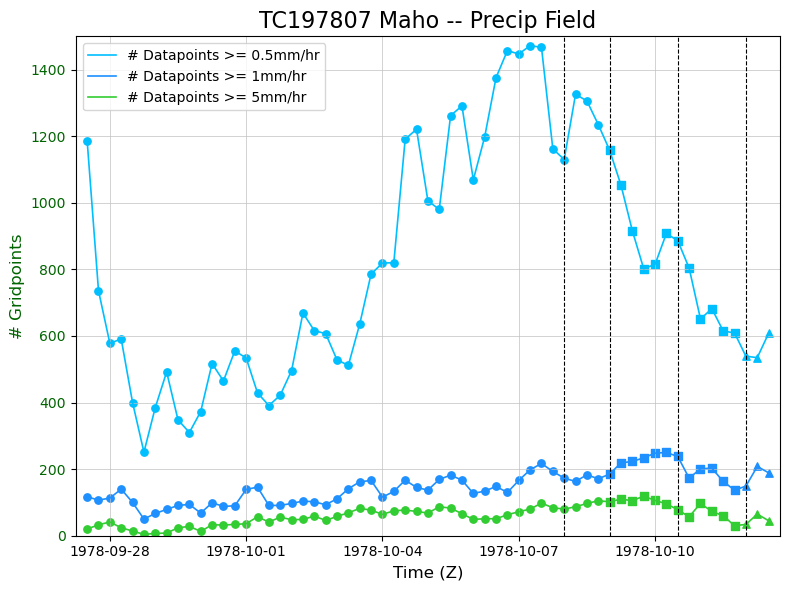

In [63]:
# Plot Precip Field Information
Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

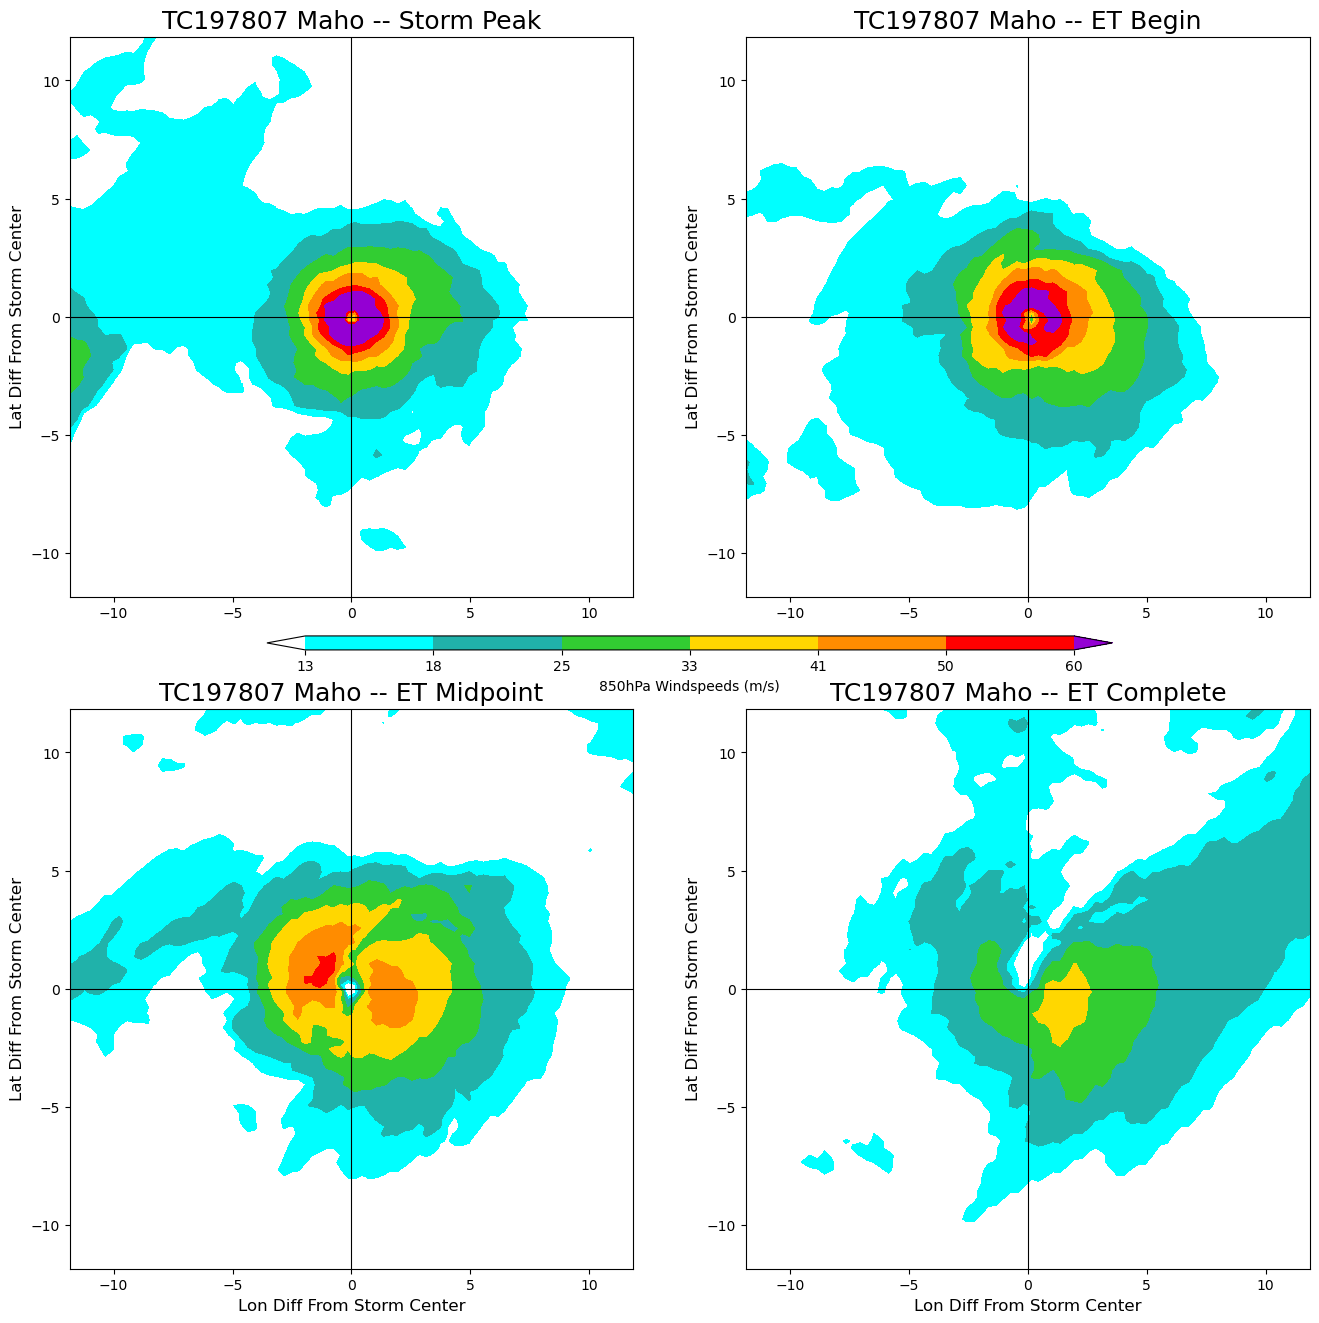

In [64]:
# Plot 850hPa Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Windspeed_Bounds, Windspeed_Colours, True)

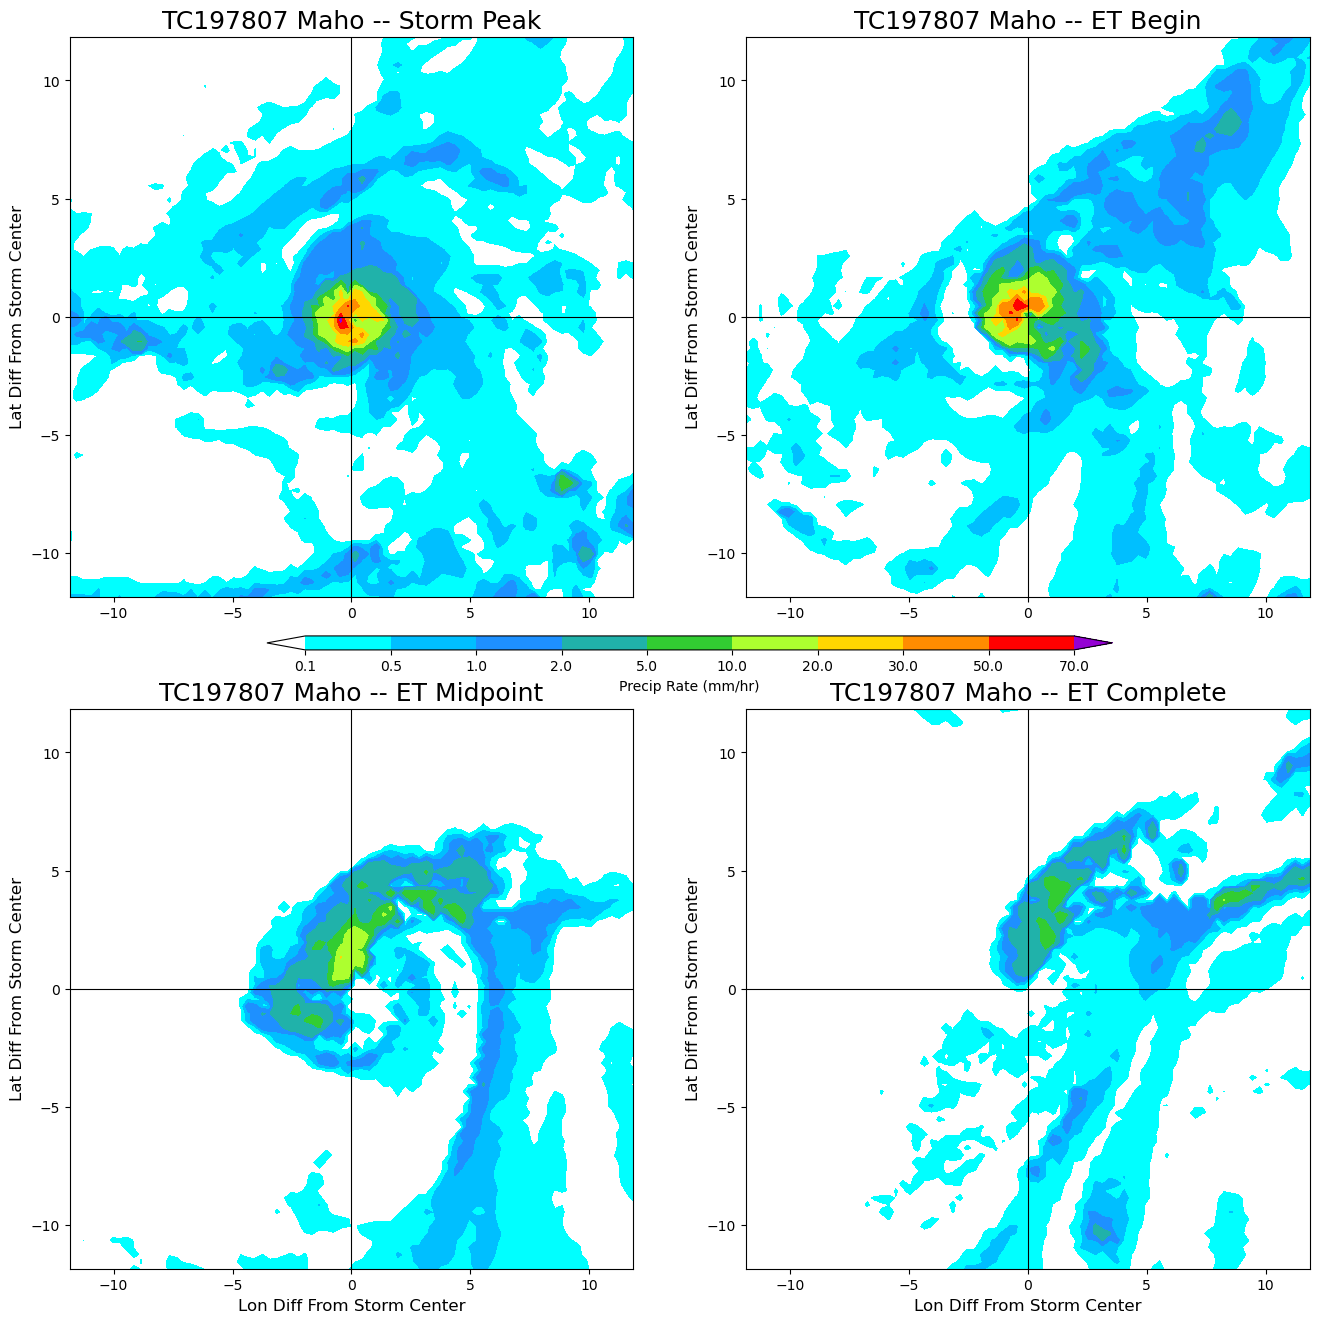

In [65]:
# Plot Precip Rate Snapshots
Precip_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Precip_Bounds, Precip_Colours, True)

In [66]:
# Find Wind Field Composite Data
Code = "TC202006"
Storm_Name = "Grace"
Data_DF = RCP45_Data
ET_DF = RCP45_ET
Compo_DF = RCP45_Compo
Compo_nc = RCP45_A_Compo_nc
Time_Indexes = [4652,4656,4657,4658]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [67]:
DF_Storm_Compo_Wind_Field

Compo Index                Time    Lon    Lat      SLP    Storm Phase  \
0        4619.0 2020-08-10 12:00:00 -32.43  17.00  1009.93       Tropical   
1        4620.0 2020-08-10 18:00:00 -33.72  16.70  1007.71       Tropical   
2        4621.0 2020-08-11 00:00:00 -34.29  17.04  1008.61       Tropical   
3        4622.0 2020-08-11 06:00:00 -36.03  17.92  1008.40       Tropical   
4        4623.0 2020-08-11 12:00:00 -38.00  18.71  1010.18       Tropical   
5        4624.0 2020-08-11 18:00:00 -40.21  19.41  1010.17       Tropical   
6        4625.0 2020-08-12 00:00:00 -42.70  19.77  1011.00       Tropical   
7        4626.0 2020-08-12 06:00:00 -45.39  20.47  1006.55       Tropical   
8        4627.0 2020-08-12 12:00:00 -47.81  20.83  1005.31       Tropical   
9        4628.0 2020-08-12 18:00:00 -50.31  20.98  1004.90       Tropical   
10       4629.0 2020-08-13 00:00:00 -52.37  21.47  1001.38       Tropical   
11       4630.0 2020-08-13 06:00:00 -54.27  21.62  1001.35       Tropical   
12       4631.0 2020-08-13 12:00:00 -56.25  21.87  1001.18       Tropical   
13       4632.0 2020-08-13 18:00:00 -58.08  22.27   998.83       Tropical   
14       4633.0 2020-08-14 00:00:00 -59.18  22.55   995.11       Tropical   
15       4634.0 2020-08-14 06:00:00 -60.77  23.19   996.00       Tropical   
16       4635.0 2020-08-14 12:00:00 -62.30  24.10   992.96       Tropical   
17       4636.0 2020-08-14 18:00:00 -63.65  25.10   992.17       Tropical   
18       4637.0 2020-08-15 00:00:00 -64.78  25.98   995.97       Tropical   
19       4638.0 2020-08-15 06:00:00 -66.15  26.56   984.71       Tropical   
20       4639.0 2020-08-15 12:00:00 -67.23  27.46   986.02       Tropical   
21       4640.0 2020-08-15 18:00:00 -67.69  28.09   968.58       Tropical   
22       4641.0 2020-08-16 00:00:00 -68.27  28.89   979.65       Tropical   
23       4642.0 2020-08-16 06:00:00 -69.08  29.96   977.54       Tropical   
24       4643.0 2020-08-16 12:00:00 -69.56  30.58   957.79       Tropical   
25       4644.0 2020-08-16 18:00:00 -70.36  31.25   954.98       Tropical   
26       4645.0 2020-08-17 00:00:00 -70.85  31.87   948.95       Tropical   
27       4646.0 2020-08-17 06:00:00 -71.40  32.20   958.16       Tropical   
28       4647.0 2020-08-17 12:00:00 -72.07  32.45   963.84       Tropical   
29       4648.0 2020-08-17 18:00:00 -72.76  32.94   956.46       Tropical   
30       4649.0 2020-08-18 00:00:00 -73.42  33.71   957.56       Tropical   
31       4650.0 2020-08-18 06:00:00 -74.13  34.19   950.22       Tropical   
32       4651.0 2020-08-18 12:00:00 -74.80  34.96   953.23       Tropical   
33       4652.0 2020-08-18 18:00:00 -75.55  36.12   947.90       Tropical   
34       4653.0 2020-08-19 00:00:00 -75.60  37.32   958.71       Tropical   
35       4654.0 2020-08-19 06:00:00 -75.08  39.07   968.78       Tropical   
36       4655.0 2020-08-19 12:00:00 -74.26  40.82   977.55       Tropical   
37       4656.0 2020-08-19 18:00:00 -72.59  43.04   988.26     Transition   
38       4657.0 2020-08-20 00:00:00 -70.52  45.54   994.25     Transition   
39       4658.0 2020-08-20 06:00:00 -67.32  47.37   998.72  Extratropical   
40       4659.0 2020-08-20 12:00:00 -63.72  48.93  1001.25  Extratropical   
41       4660.0 2020-08-20 18:00:00 -61.14  48.84  1006.69  Extratropical   
42       4661.0 2020-08-21 00:00:00 -53.72  50.12  1008.36  Extratropical   
43       4662.0 2020-08-21 06:00:00 -47.25  50.25  1010.56  Extratropical   
44       4663.0 2020-08-21 12:00:00 -41.00  51.00  1011.26  Extratropical   
45       4664.0 2020-08-21 18:00:00 -34.50  51.00  1010.44  Extratropical   
46       4665.0 2020-08-22 00:00:00 -30.00  50.75  1010.47  Extratropical   
47       4666.0 2020-08-22 06:00:00 -25.00  51.50  1008.77  Extratropical   
48       4667.0 2020-08-22 12:00:00 -21.75  52.00  1008.31  Extratropical   
49       4668.0 2020-08-22 18:00:00 -18.50  53.00  1007.29  Extratropical   
50       4669.0 2020-08-23 00:00:00 -15.25  54.25  1007.08  Extratropical   


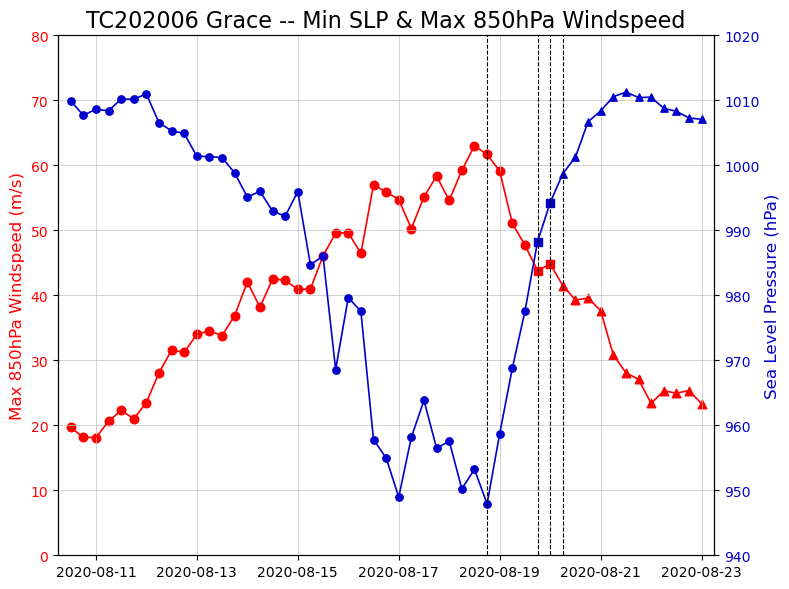

In [68]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

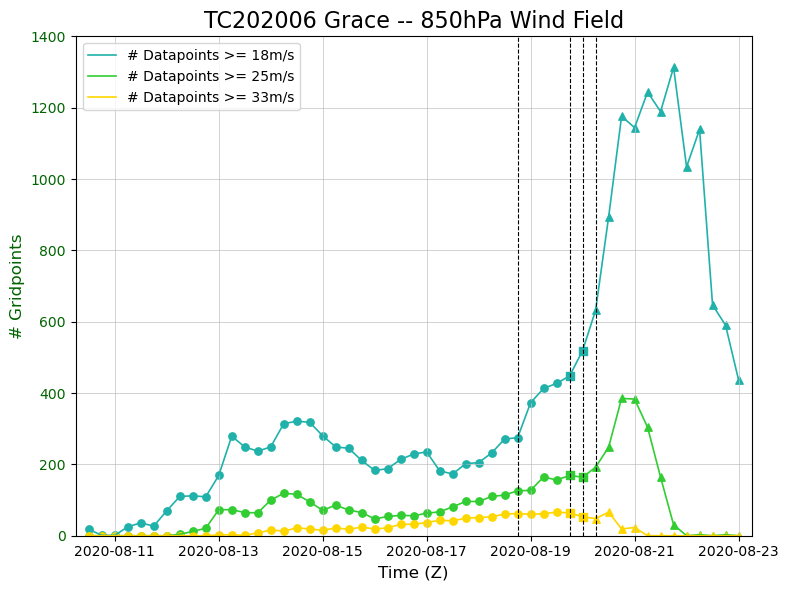

In [69]:
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

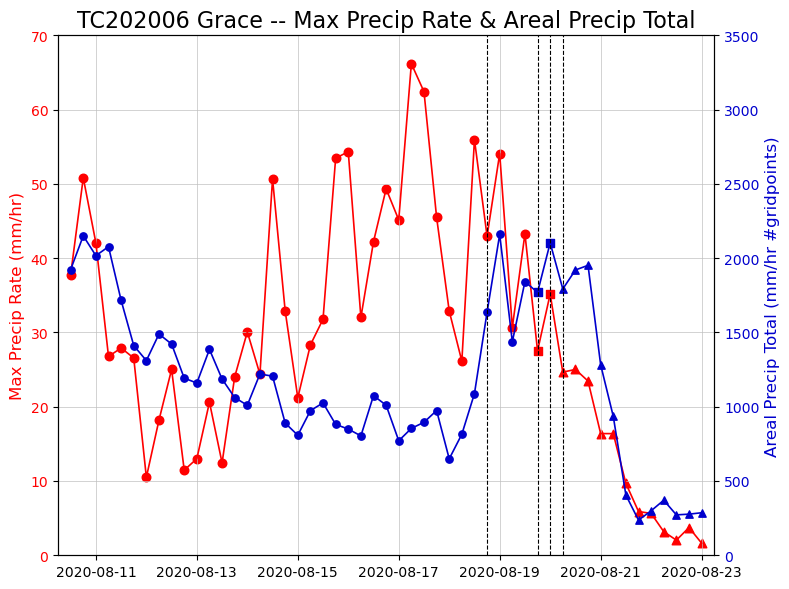

In [70]:
# Plot Max Precip Rate and Areal Precip Total
Precip_Area_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

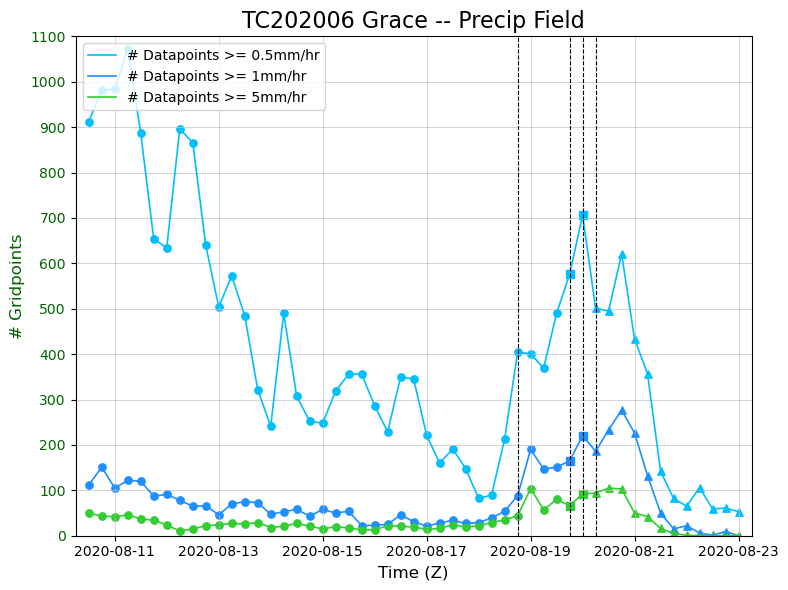

In [71]:
# Plot Precip Field Information
Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

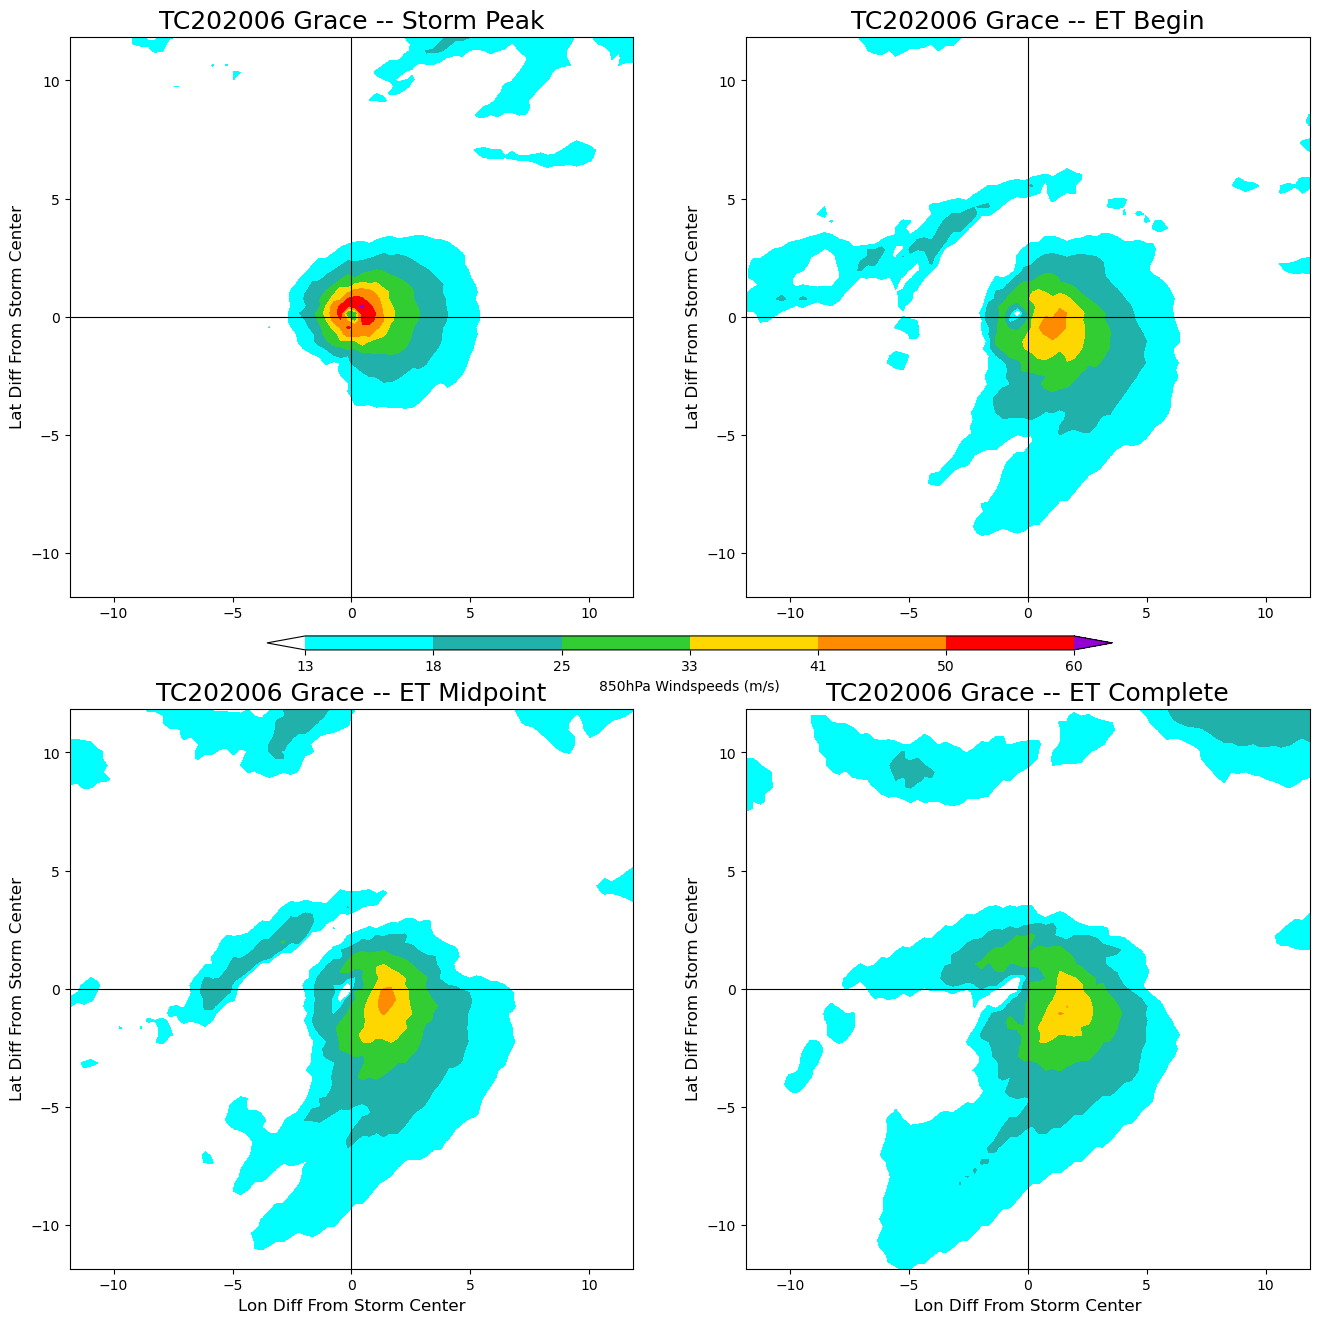

In [72]:
# Plot 850hPa Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Windspeed_Bounds, Windspeed_Colours, True)

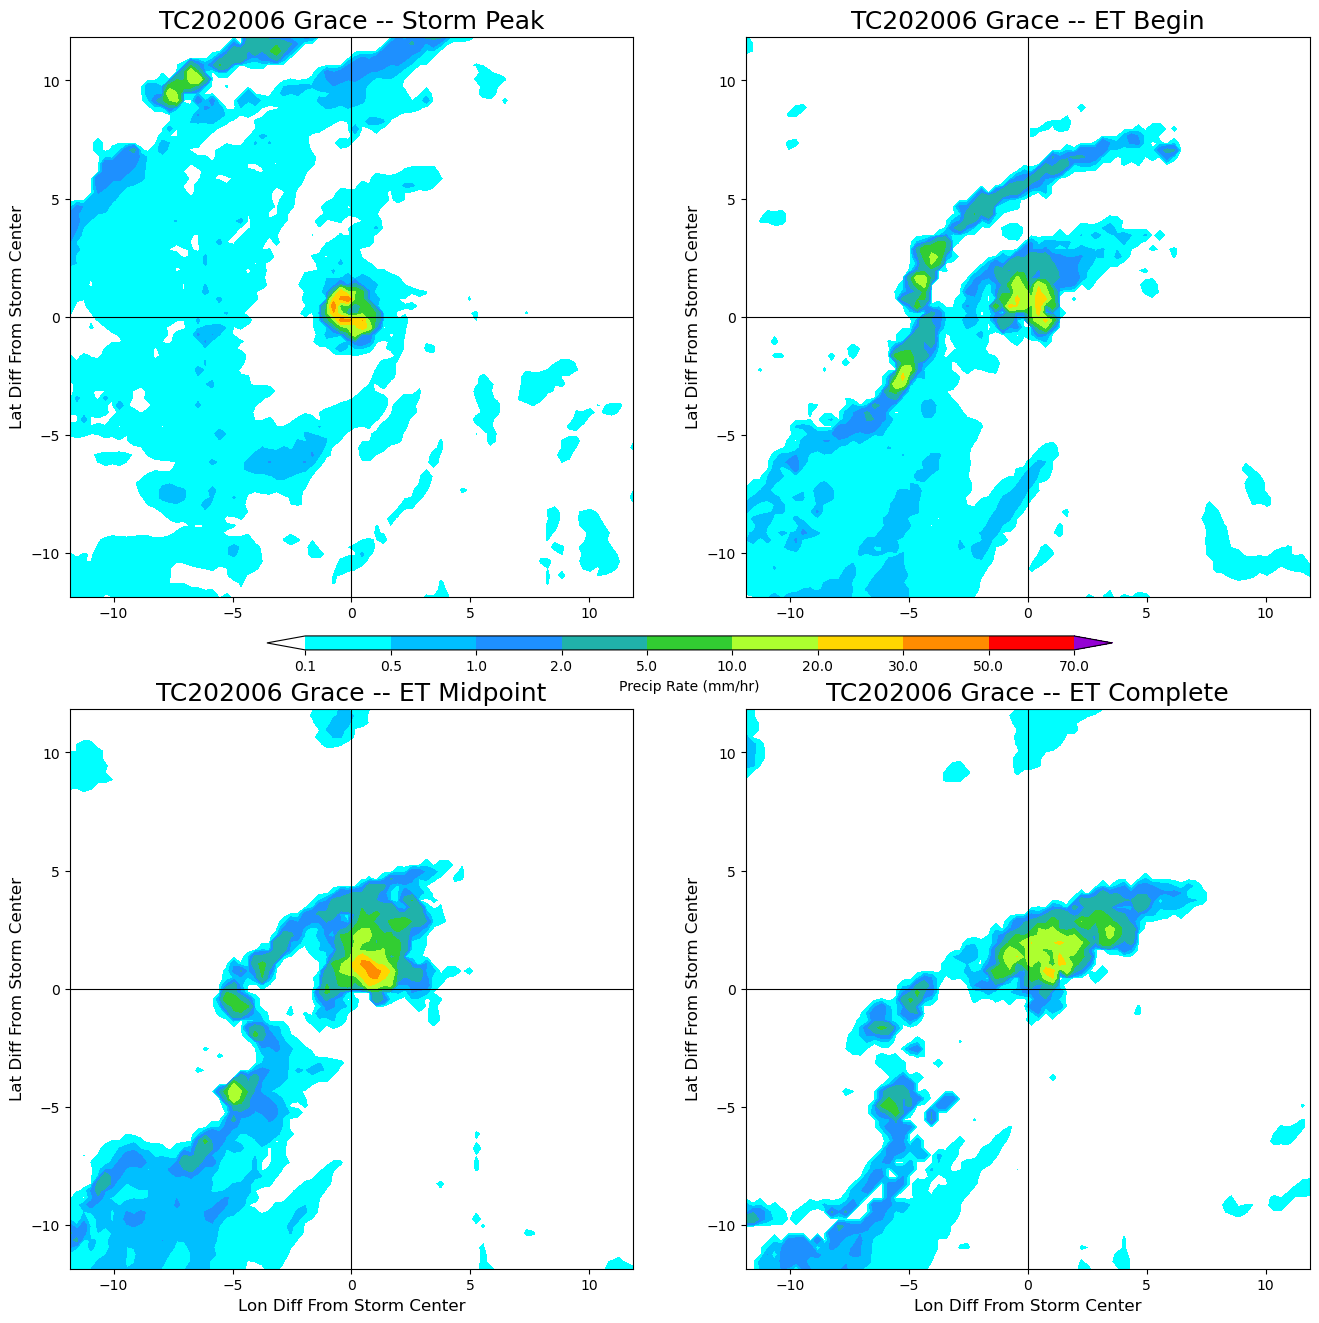

In [73]:
# Plot Precip Rate Snapshots
Precip_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Precip_Bounds, Precip_Colours, True)

In [74]:
# Find Wind Field Composite Data
Code = "TC204702"
Storm_Name = "Esther"
Data_DF = RCP45_Data
ET_DF = RCP45_ET
Compo_DF = RCP45_Compo
Compo_nc = RCP45_B_Compo_nc
Time_Indexes = [3570,3578,3582,3587]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [75]:
DF_Storm_Compo_Wind_Field[40:]

Compo Index                Time    Lon    Lat      SLP    Storm Phase  \
40       3565.0 2047-08-26 12:00:00 -71.21  24.09   948.88       Tropical   
41       3566.0 2047-08-26 18:00:00 -72.27  24.95   945.83       Tropical   
42       3567.0 2047-08-27 00:00:00 -73.16  25.77   932.73       Tropical   
43       3568.0 2047-08-27 06:00:00 -74.00  26.52   929.27       Tropical   
44       3569.0 2047-08-27 12:00:00 -74.47  27.13   917.17       Tropical   
45       3570.0 2047-08-27 18:00:00 -74.71  28.14   909.95       Tropical   
46       3571.0 2047-08-28 00:00:00 -74.90  28.95   910.92       Tropical   
47       3572.0 2047-08-28 06:00:00 -75.21  29.67   913.47       Tropical   
48       3573.0 2047-08-28 12:00:00 -75.05  30.72   919.05       Tropical   
49       3574.0 2047-08-28 18:00:00 -74.94  31.49   924.05       Tropical   
50       3575.0 2047-08-29 00:00:00 -74.86  32.07   923.92       Tropical   
51       3576.0 2047-08-29 06:00:00 -74.43  32.78   928.67       Tropical   
52       3577.0 2047-08-29 12:00:00 -73.90  33.39   927.15       Tropical   
53       3578.0 2047-08-29 18:00:00 -73.31  34.47   925.62     Transition   
54       3579.0 2047-08-30 00:00:00 -72.73  35.36   923.41     Transition   
55       3580.0 2047-08-30 06:00:00 -72.08  36.71   924.79     Transition   
56       3581.0 2047-08-30 12:00:00 -71.22  38.17   929.53     Transition   
57       3582.0 2047-08-30 18:00:00 -71.12  39.58   931.78     Transition   
58       3583.0 2047-08-31 00:00:00 -70.45  40.90   934.41     Transition   
59       3584.0 2047-08-31 06:00:00 -70.69  42.64   953.36     Transition   
60       3585.0 2047-08-31 12:00:00 -71.27  43.52   977.57     Transition   
61       3586.0 2047-08-31 18:00:00 -72.00  45.01   987.48     Transition   
62       3587.0 2047-09-01 00:00:00 -71.73  45.84   993.02  Extratropical   
63       3588.0 2047-09-01 06:00:00 -71.00  46.50   996.78  Extratropical   
64       3589.0 2047-09-01 12:00:00 -69.75  47.75   999.27  Extratropical   
65       3590.0 2047-09-01 18:00:00 -68.50  48.75  1000.26  Extratropical   
66       3591.0 2047-09-02 00:00:00 -67.00  49.25  1000.87  Extratropical   
67       3592.0 2047-09-02 06:00:00 -65.25  50.00   999.94  Extratropical   
68       3593.0 2047-09-02 12:00:00 -64.25  50.25   998.74  Extratropical   
69       3594.0 2047-09-02 18:00:00 -62.75  51.25   997.32  Extratropical   
70       3595.0 2047-09-03 00:00:00 -59.50  52.25   996.01  Extratropical   
71       3596.0 2047-09-03 06:00:00 -54.75  54.50   991.08  Extratropical   

    850hPa Winds  850hPa 18m/s  850hPa 25m/s  850hPa 33m/s  Max Precip Rate  \
40     63.975689         609.0         267.0         110.0        46.775463   
41     65.387909         635.0         295.0         112.0        82.663010   
42     63.667511         654.0         303.0         137.0        37.032215   
43     67.406212         667.0         372.0         175.0        71.875183   
44     73.673576         708.0         382.0         185.0        59.969223   
45     77.795662         727.0         398.0         196.0        80.029800   
46     75.667564         697.0         411.0         224.0        53.222729   
47     72.129593         734.0         439.0         269.0        54.153957   
48     78.143761         759.0         444.0         247.0        86.375259   
49     73.329834         780.0         481.0         291.0        61.853096   
50     68.582291         796.0         496.0         304.0        71.132439   
51     70.036453         874.0         568.0         354.0        38.610271   
52     71.306183         960.0         579.0         327.0        61.270512   
53     69.571373         990.0         606.0         346.0        66.343163   
54     70.991364         942.0         578.0         350.0        71.257645   
55     67.096298        1011.0         627.0         379.0        69.115913   
56     68.139320        1041.0         677.0         451.0        49.420715   
57     64.907387        1084.0         7

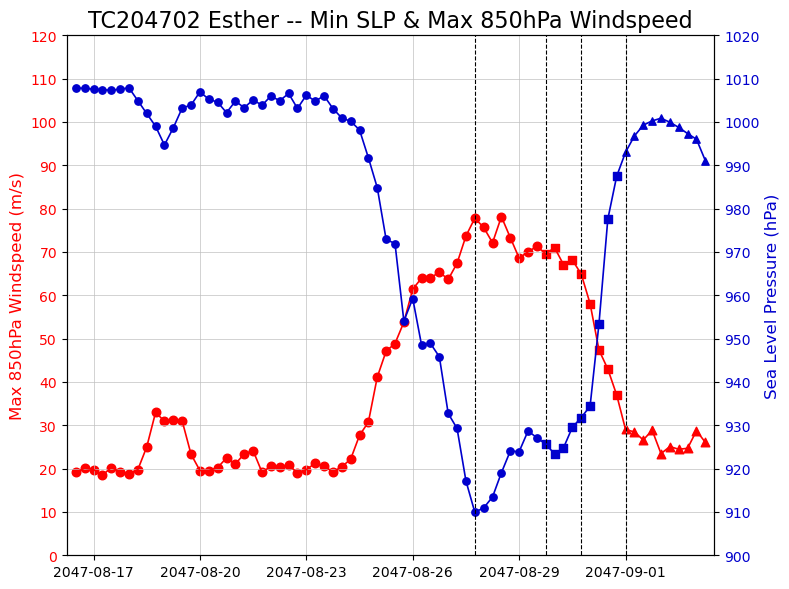

In [76]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

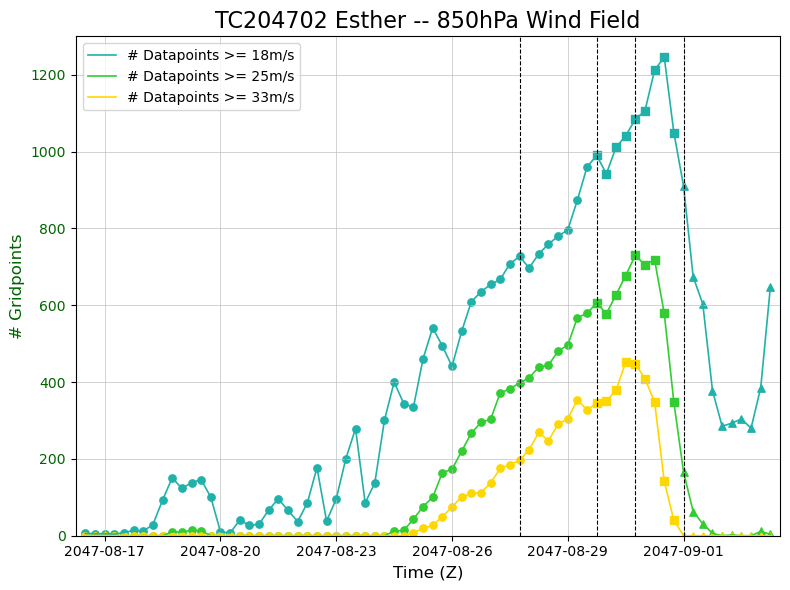

In [77]:
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

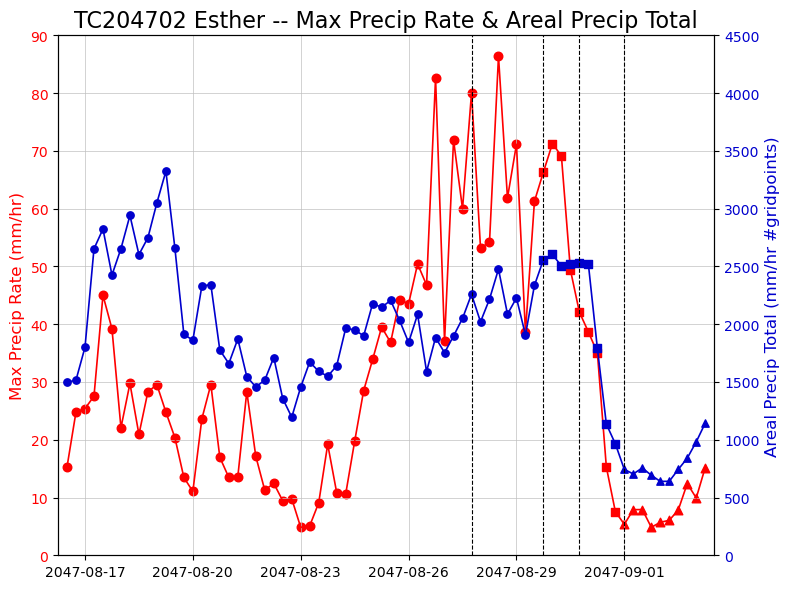

In [78]:
# Plot Max Precip Rate and Areal Precip Total
Precip_Area_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

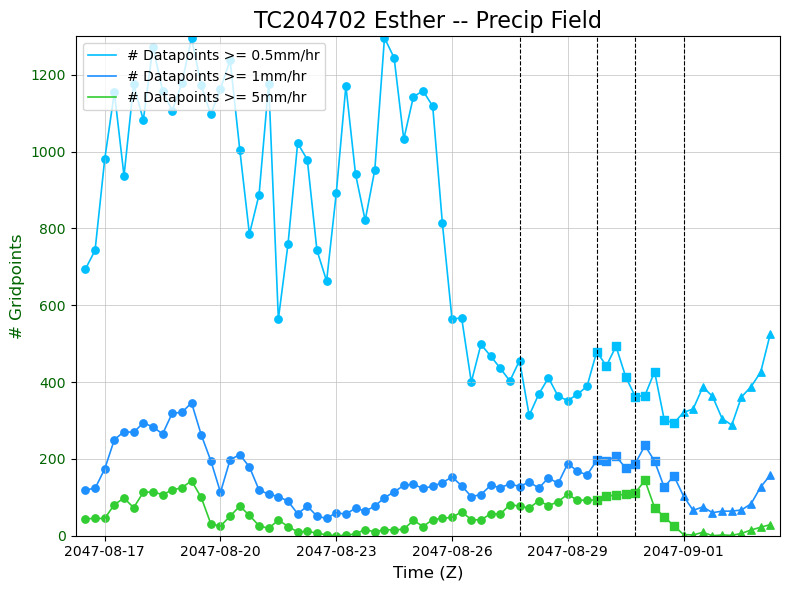

In [79]:
# Plot Precip Field Information
Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

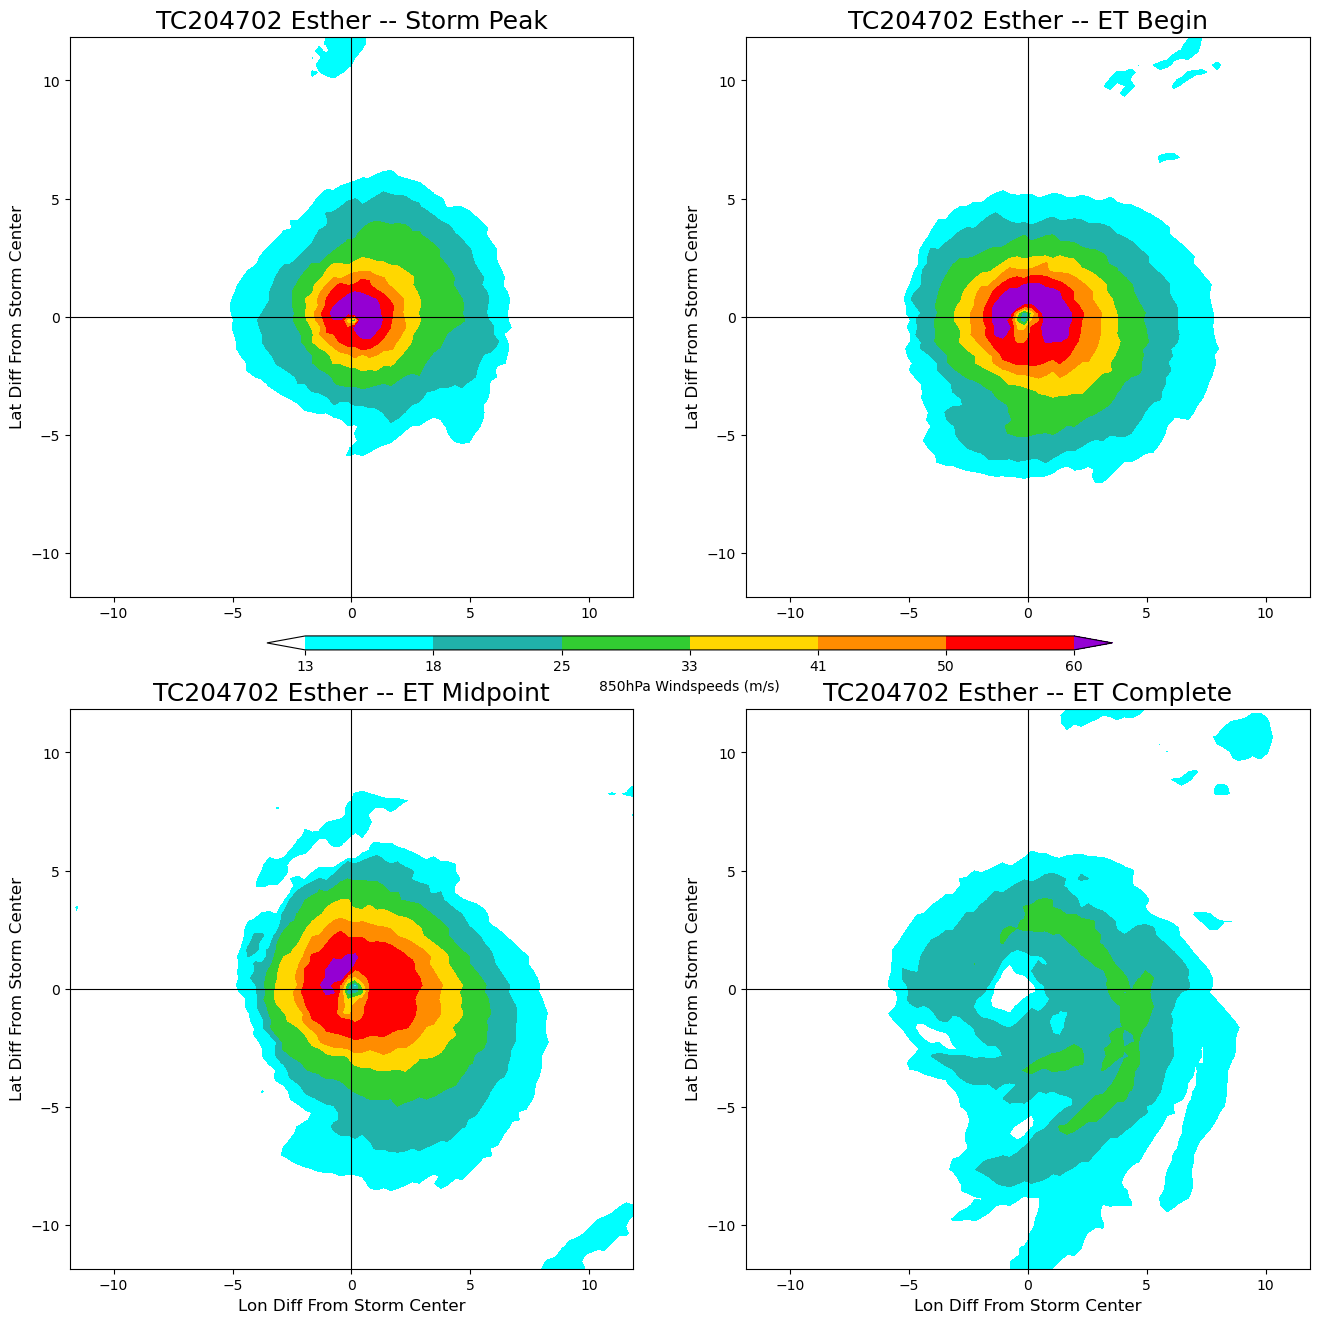

In [80]:
# Plot 850hPa Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Windspeed_Bounds, Windspeed_Colours, True)

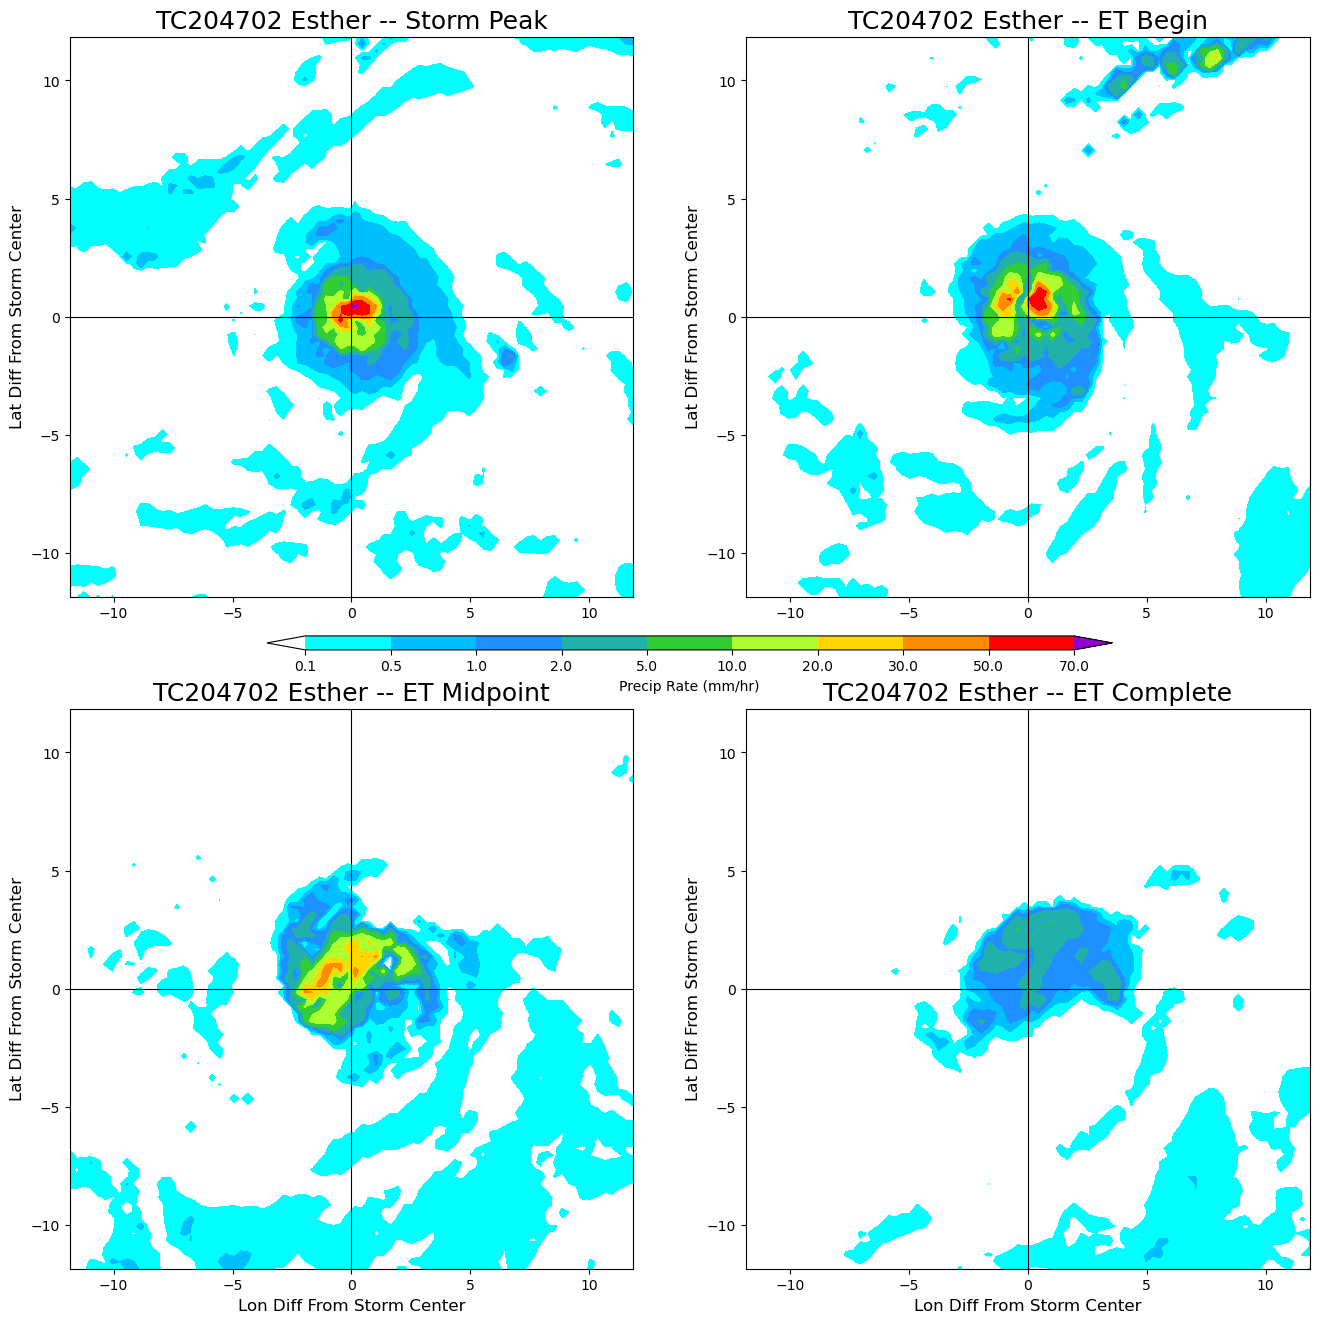

In [81]:
# Plot Precip Rate Snapshots
Precip_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Precip_Bounds, Precip_Colours, True)

In [82]:
# Find Wind Field Composite Data
Code = "TC208507"
Storm_Name = "Shannon"
Data_DF = RCP45_Data
ET_DF = RCP45_ET
Compo_DF = RCP45_Compo
Compo_nc = RCP45_C_Compo_nc
Time_Indexes = [5820,5826,5828,5830]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [83]:
DF_Storm_Compo_Wind_Field

Compo Index                Time    Lon    Lat      SLP    Storm Phase  \
0        5778.0 2085-09-18 18:00:00 -21.78  11.40  1002.89       Tropical   
1        5779.0 2085-09-19 00:00:00 -21.58  12.23  1006.32       Tropical   
2        5780.0 2085-09-19 06:00:00 -21.92  12.83  1004.55       Tropical   
3        5781.0 2085-09-19 12:00:00 -22.81  13.42  1004.45       Tropical   
4        5782.0 2085-09-19 18:00:00 -23.60  14.38  1001.95       Tropical   
5        5783.0 2085-09-20 00:00:00 -24.79  15.19  1003.43       Tropical   
6        5784.0 2085-09-20 06:00:00 -26.29  15.02   998.96       Tropical   
7        5785.0 2085-09-20 12:00:00 -27.17  14.67   997.98       Tropical   
8        5786.0 2085-09-20 18:00:00 -27.57  14.85   995.15       Tropical   
9        5787.0 2085-09-21 00:00:00 -28.28  15.76   996.78       Tropical   
10       5788.0 2085-09-21 06:00:00 -29.40  16.85   994.30       Tropical   
11       5789.0 2085-09-21 12:00:00 -30.95  17.36   995.59       Tropical   
12       5790.0 2085-09-21 18:00:00 -31.98  17.39   992.58       Tropical   
13       5791.0 2085-09-22 00:00:00 -32.41  17.57   994.78       Tropical   
14       5792.0 2085-09-22 06:00:00 -33.18  18.47   991.98       Tropical   
15       5793.0 2085-09-22 12:00:00 -34.14  18.88   992.03       Tropical   
16       5794.0 2085-09-22 18:00:00 -34.98  18.90   988.51       Tropical   
17       5795.0 2085-09-23 00:00:00 -35.63  19.65   990.48       Tropical   
18       5796.0 2085-09-23 06:00:00 -36.55  19.86   988.50       Tropical   
19       5797.0 2085-09-23 12:00:00 -37.11  20.08   991.73       Tropical   
20       5798.0 2085-09-23 18:00:00 -38.11  20.48   990.52       Tropical   
21       5799.0 2085-09-24 00:00:00 -38.56  20.65   991.04       Tropical   
22       5800.0 2085-09-24 06:00:00 -38.72  21.03   989.78       Tropical   
23       5801.0 2085-09-24 12:00:00 -39.00  21.71   990.43       Tropical   
24       5802.0 2085-09-24 18:00:00 -39.54  21.85   986.81       Tropical   
25       5803.0 2085-09-25 00:00:00 -40.17  22.41   988.25       Tropical   
26       5804.0 2085-09-25 06:00:00 -40.74  22.62   985.33       Tropical   
27       5805.0 2085-09-25 12:00:00 -40.88  22.93   989.99       Tropical   
28       5806.0 2085-09-25 18:00:00 -41.18  23.61   988.43       Tropical   
29       5807.0 2085-09-26 00:00:00 -41.99  24.53   979.66       Tropical   
30       5808.0 2085-09-26 06:00:00 -42.73  25.04   979.93       Tropical   
31       5809.0 2085-09-26 12:00:00 -43.95  25.73   976.24       Tropical   
32       5810.0 2085-09-26 18:00:00 -45.04  26.10   971.77       Tropical   
33       5811.0 2085-09-27 00:00:00 -45.57  26.34   970.01       Tropical   
34       5812.0 2085-09-27 06:00:00 -46.03  26.74   958.10       Tropical   
35       5813.0 2085-09-27 12:00:00 -46.68  26.70   963.71       Tropical   
36       5814.0 2085-09-27 18:00:00 -47.14  27.10   953.75       Tropical   
37       5815.0 2085-09-28 00:00:00 -47.61  27.50   963.20       Tropical   
38       5816.0 2085-09-28 06:00:00 -48.52  27.95   953.71       Tropical   
39       5817.0 2085-09-28 12:00:00 -49.18  27.90   946.62       Tropical   
40       5818.0 2085-09-28 18:00:00 -49.97  28.39   933.88       Tropical   
41       5819.0 2085-09-29 00:00:00 -50.35  29.06   933.43       Tropical   
42       5820.0 2085-09-29 06:00:00 -50.51  29.82   931.18       Tropical   
43       5821.0 2085-09-29 12:00:00 -50.79  30.76   935.21       Tropical   
44       5822.0 2085-09-29 18:00:00 -50.21  32.19   938.65       Tropical   
45       5823.0 2085-09-30 00:00:00 -49.46  33.53   943.07       Tropical   
46       5824.0 2085-09-30 06:00:00 -47.90  35.50   945.29       Tropical   
47       5825.0 2085-09-30 12:00:00 -45.86  37.22   944.23       Tropical   
48       5826.0 2085-09-30 18:00:00 -43.65  39.25   963.87     Transition   
49       5827.0 2085-10-01 00:00:00 -40.85  41.19   974.97     Transition   
50       5828.0 2085-10-01 06:00:00 -38.04  43.31   980.99     Transition   


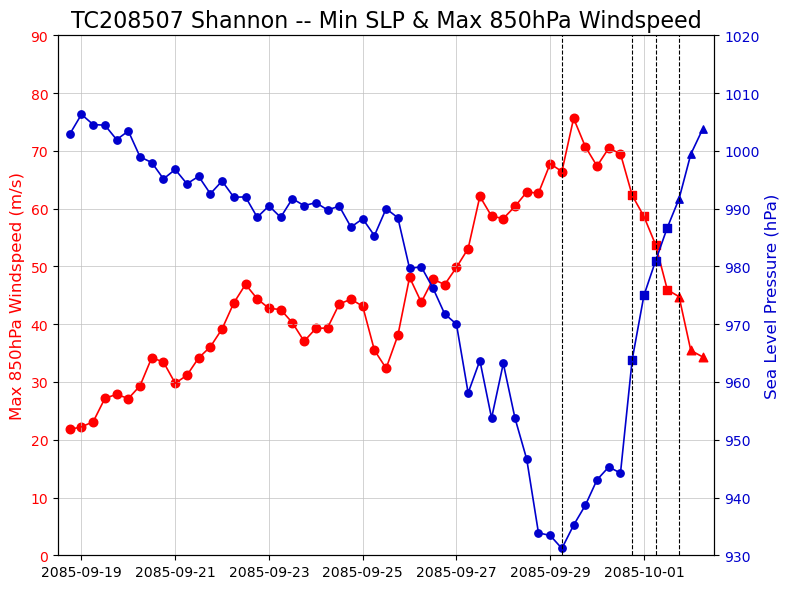

In [84]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

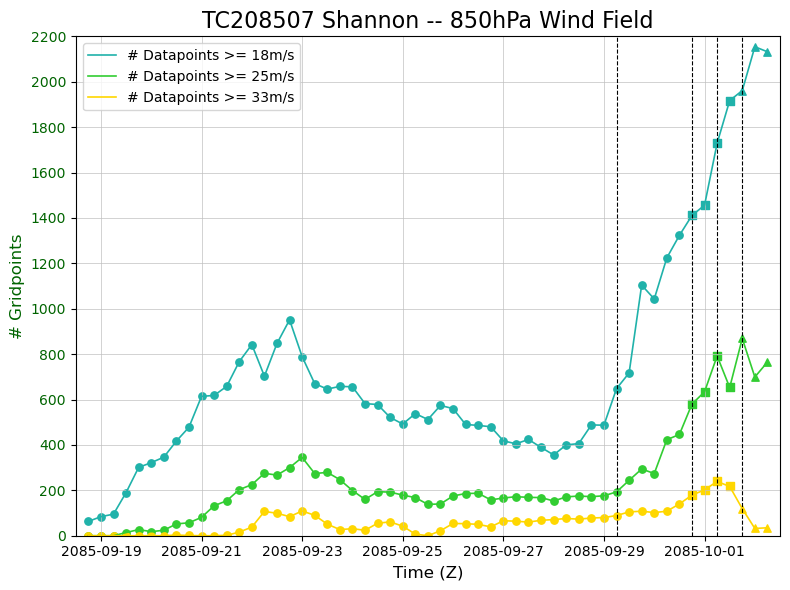

In [85]:
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

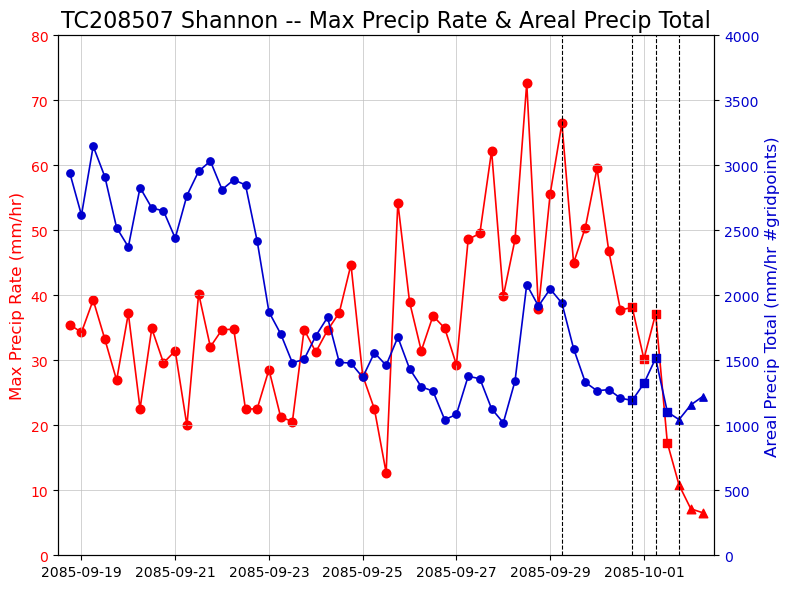

In [86]:
# Plot Max Precip Rate and Areal Precip Total
Precip_Area_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

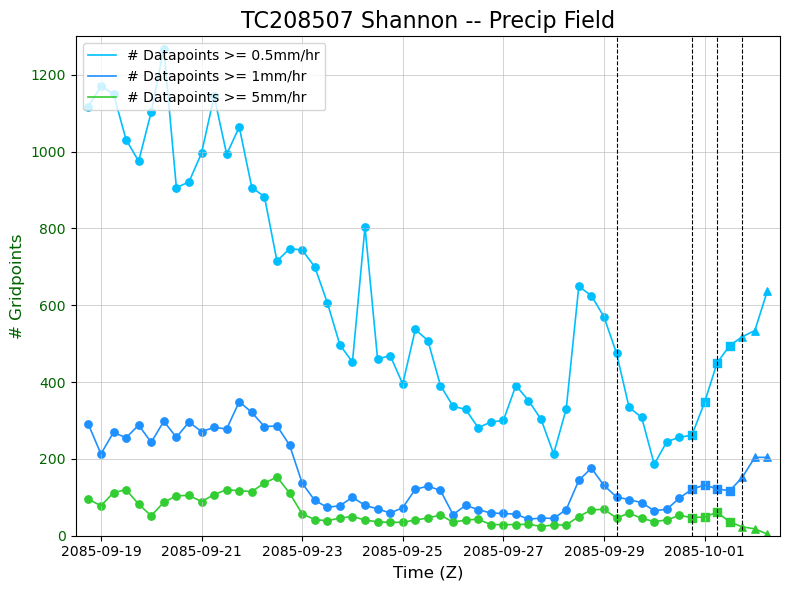

In [87]:
# Plot Precip Field Information
Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

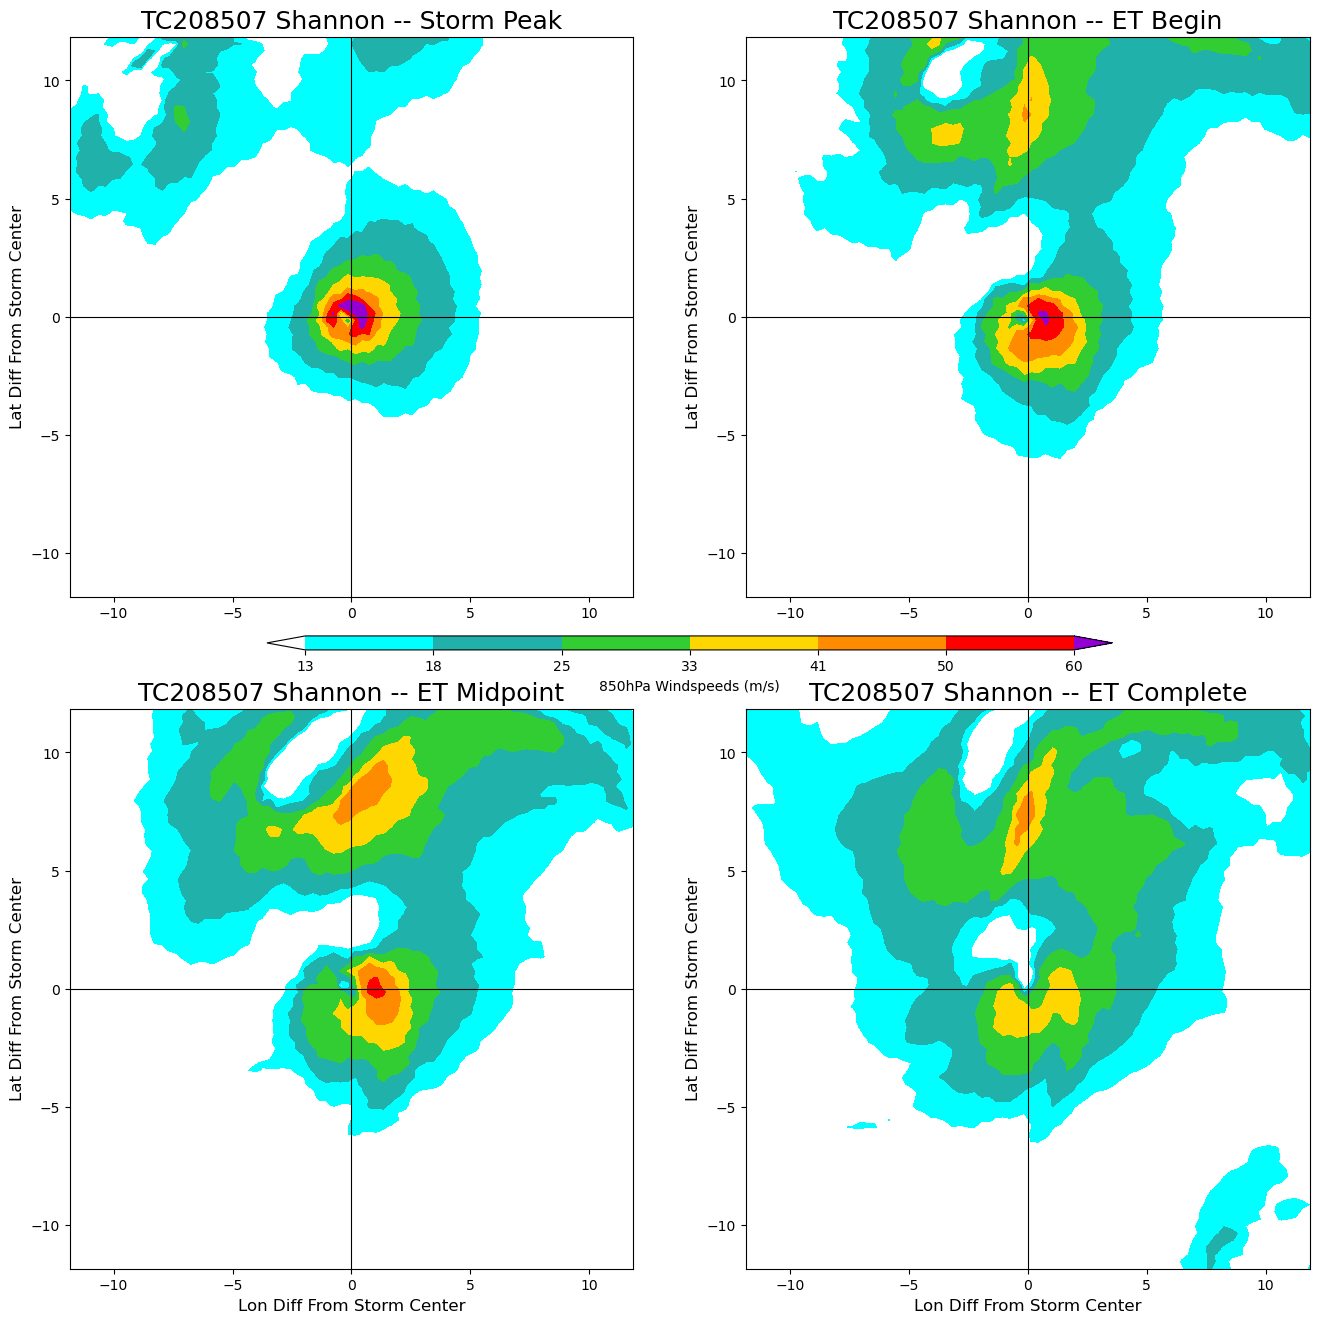

In [88]:
# Plot 850hPa Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Windspeed_Bounds, Windspeed_Colours, True)

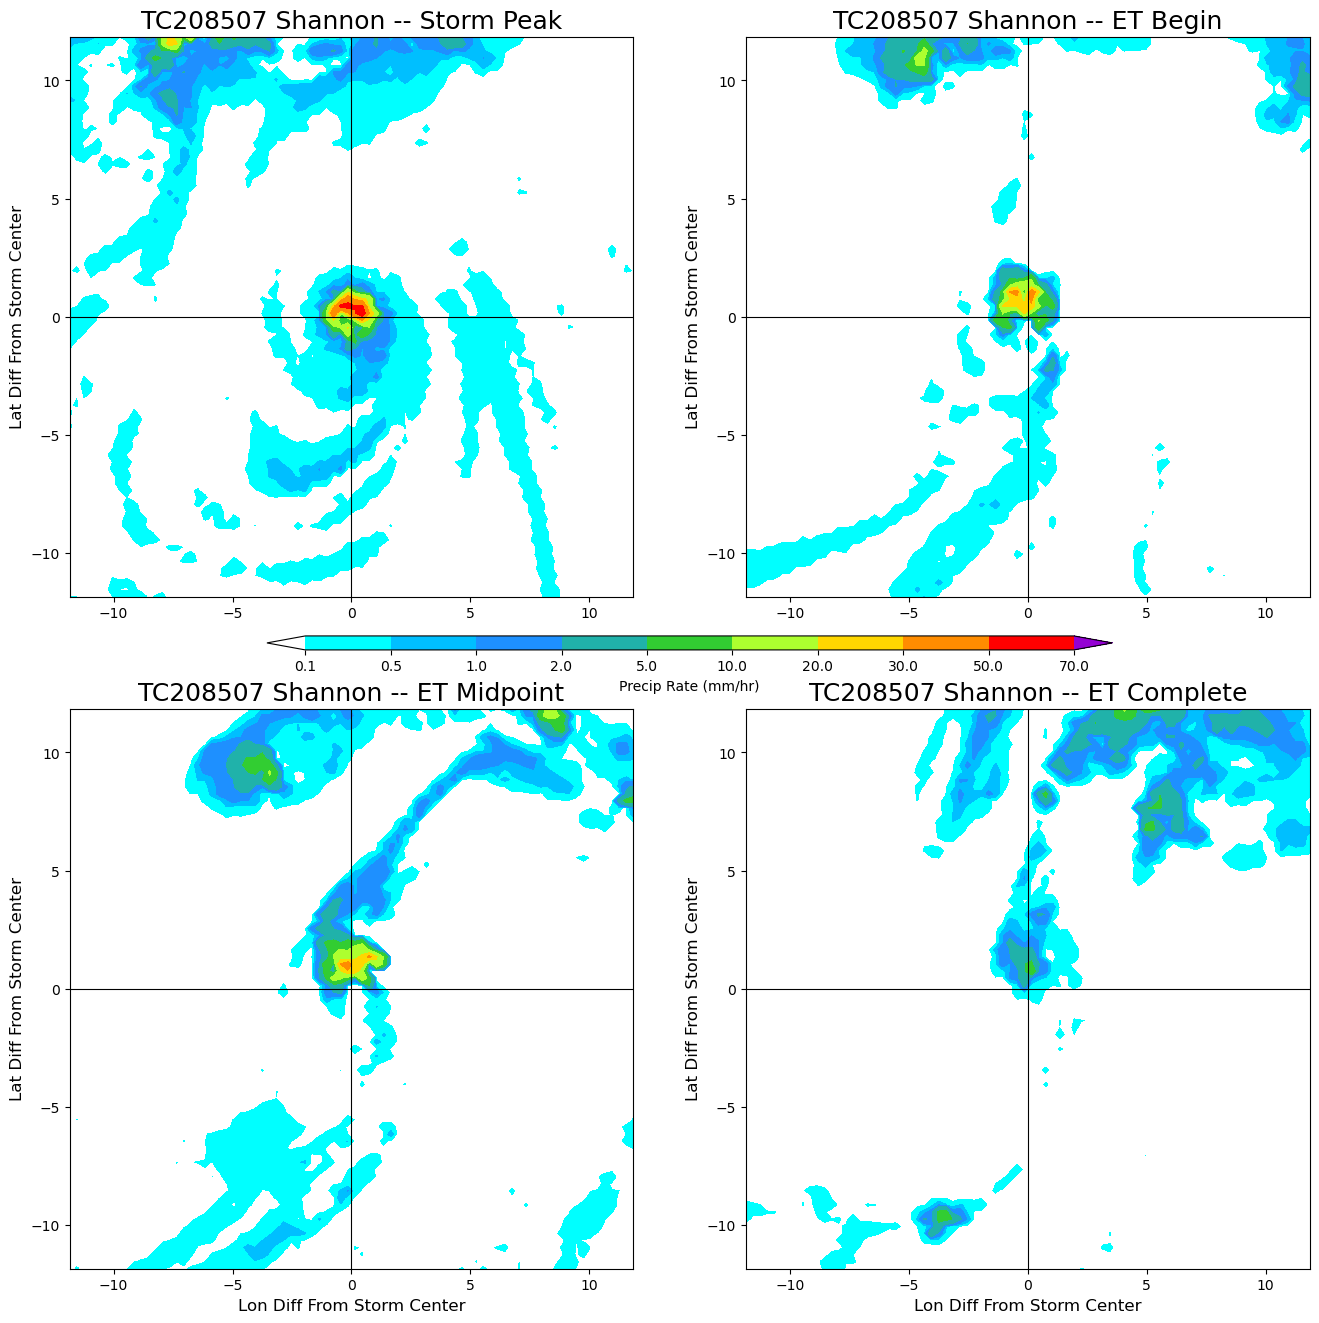

In [89]:
# Plot Precip Rate Snapshots
Precip_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Precip_Bounds, Precip_Colours, True)

In [90]:
# Find Wind Field Composite Data
Code = "TC210105"
Storm_Name = "Nicole"
Data_DF = RCP85_Data
ET_DF = RCP85_ET
Compo_DF = RCP85_Compo
Compo_nc = RCP85_A_Compo_nc
Time_Indexes = [323,339,343,347]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [91]:
DF_Storm_Compo_Wind_Field

Compo Index                Time    Lon    Lat      SLP    Storm Phase  \
0         290.0 2101-08-31 12:00:00 -15.02   9.92  1010.22       Tropical   
1         291.0 2101-08-31 18:00:00 -16.98  11.22  1007.41       Tropical   
2         292.0 2101-09-01 00:00:00 -18.85  11.35  1008.68       Tropical   
3         293.0 2101-09-01 06:00:00 -18.48  11.51  1004.44       Tropical   
4         294.0 2101-09-01 12:00:00 -17.29  11.80  1001.73       Tropical   
5         295.0 2101-09-01 18:00:00 -17.77  13.24   999.37       Tropical   
6         296.0 2101-09-02 00:00:00 -19.19  13.92  1000.25       Tropical   
7         297.0 2101-09-02 06:00:00 -20.82  14.53   998.38       Tropical   
8         298.0 2101-09-02 12:00:00 -22.86  14.46   999.78       Tropical   
9         299.0 2101-09-02 18:00:00 -23.98  14.23   999.49       Tropical   
10        300.0 2101-09-03 00:00:00 -24.80  14.44  1003.82       Tropical   
11        301.0 2101-09-03 06:00:00 -26.79  14.83   999.57       Tropical   
12        302.0 2101-09-03 12:00:00 -28.86  15.11   999.94       Tropical   
13        303.0 2101-09-03 18:00:00 -30.61  14.62   999.80       Tropical   
14        304.0 2101-09-04 00:00:00 -31.75  14.37  1000.94       Tropical   
15        305.0 2101-09-04 06:00:00 -33.11  14.38   998.72       Tropical   
16        306.0 2101-09-04 12:00:00 -34.86  14.22  1000.10       Tropical   
17        307.0 2101-09-04 18:00:00 -35.99  14.18   997.14       Tropical   
18        308.0 2101-09-05 00:00:00 -37.26  14.22   996.60       Tropical   
19        309.0 2101-09-05 06:00:00 -38.99  14.51   991.30       Tropical   
20        310.0 2101-09-05 12:00:00 -40.68  15.17   981.93       Tropical   
21        311.0 2101-09-05 18:00:00 -42.77  15.66   980.45       Tropical   
22        312.0 2101-09-06 00:00:00 -44.48  15.72   978.99       Tropical   
23        313.0 2101-09-06 06:00:00 -46.28  15.95   970.55       Tropical   
24        314.0 2101-09-06 12:00:00 -47.90  16.26   952.41       Tropical   
25        315.0 2101-09-06 18:00:00 -49.59  16.68   949.74       Tropical   
26        316.0 2101-09-07 00:00:00 -50.73  17.20   946.25       Tropical   
27        317.0 2101-09-07 06:00:00 -51.98  17.44   926.58       Tropical   
28        318.0 2101-09-07 12:00:00 -53.13  17.95   947.67       Tropical   
29        319.0 2101-09-07 18:00:00 -54.27  18.85   934.50       Tropical   
30        320.0 2101-09-08 00:00:00 -55.11  19.89   921.43       Tropical   
31        321.0 2101-09-08 06:00:00 -55.89  20.82   927.17       Tropical   
32        322.0 2101-09-08 12:00:00 -56.87  21.80   904.66       Tropical   
33        323.0 2101-09-08 18:00:00 -57.85  23.01   902.97       Tropical   
34        324.0 2101-09-09 00:00:00 -58.55  23.74   912.01       Tropical   
35        325.0 2101-09-09 06:00:00 -59.46  24.52   915.73       Tropical   
36        326.0 2101-09-09 12:00:00 -59.98  25.35   908.00       Tropical   
37        327.0 2101-09-09 18:00:00 -60.51  26.18   915.29       Tropical   
38        328.0 2101-09-10 00:00:00 -60.93  26.82   924.52       Tropical   
39        329.0 2101-09-10 06:00:00 -61.55  27.76   919.89       Tropical   
40        330.0 2101-09-10 12:00:00 -61.99  28.40   925.22       Tropical   
41        331.0 2101-09-10 18:00:00 -62.43  29.05   926.45       Tropical   
42        332.0 2101-09-11 00:00:00 -62.15  29.68   919.32       Tropical   
43        333.0 2101-09-11 06:00:00 -62.59  30.32   926.41       Tropical   
44        334.0 2101-09-11 12:00:00 -62.39  31.06   927.45       Tropical   
45        335.0 2101-09-11 18:00:00 -62.11  32.09   931.32       Tropical   
46        336.0 2101-09-12 00:00:00 -61.70  32.93   936.68       Tropical   
47        337.0 2101-09-12 06:00:00 -61.55  33.50   934.04       Tropical   
48        338.0 2101-09-12 12:00:00 -60.79  34.51   933.94       Tropical   
49        339.0 2101-09-12 18:00:00 -60.07  35.72   934.13     Transition   
50        340.0 2101-09-13 00:00:00 -59.33  37.17   934.69     Transition   


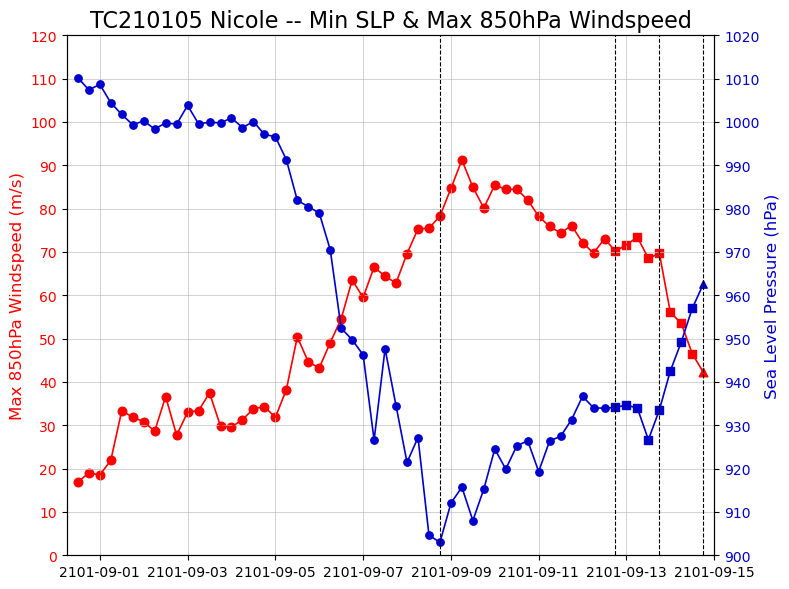

In [92]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

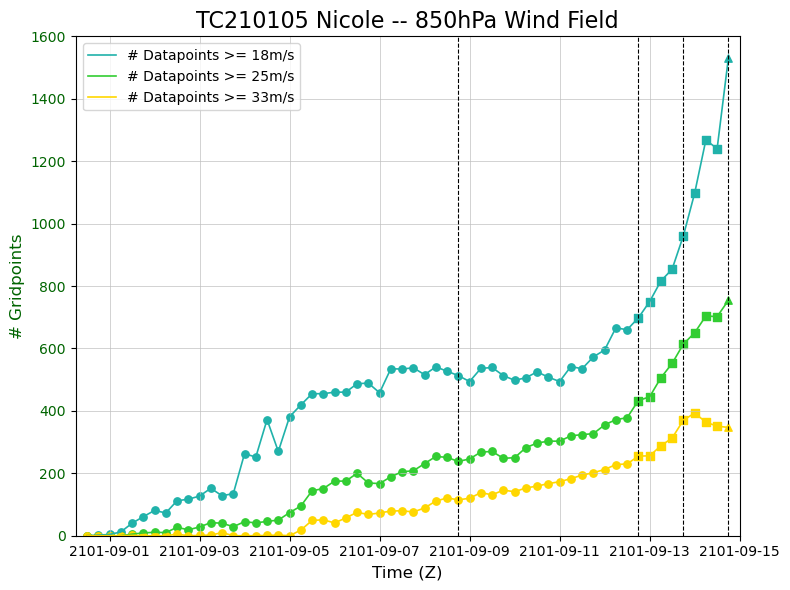

In [93]:
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

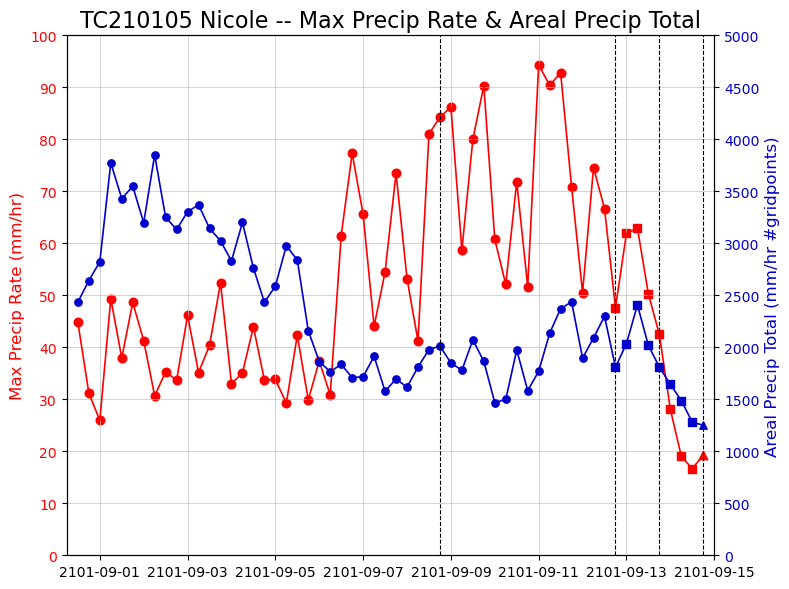

In [94]:
# Plot Max Precip Rate and Areal Precip Total
Precip_Area_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

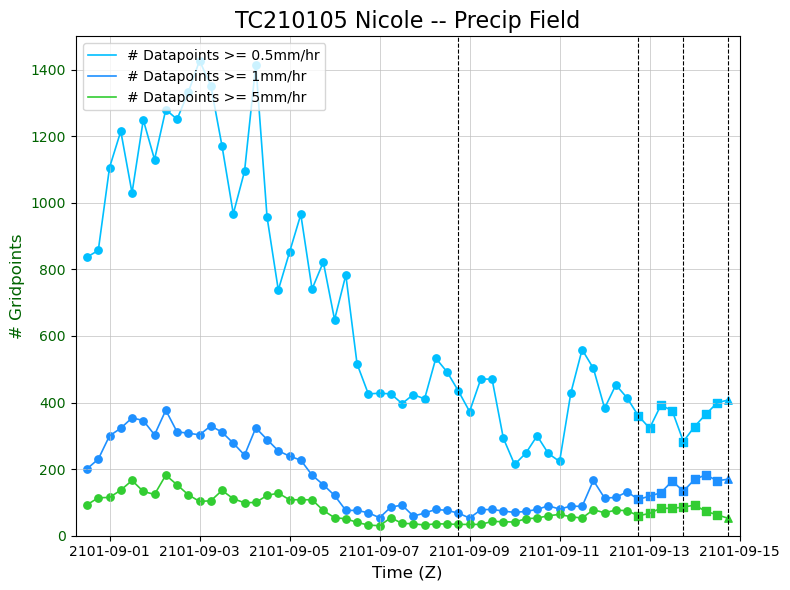

In [95]:
# Plot Precip Field Information
Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

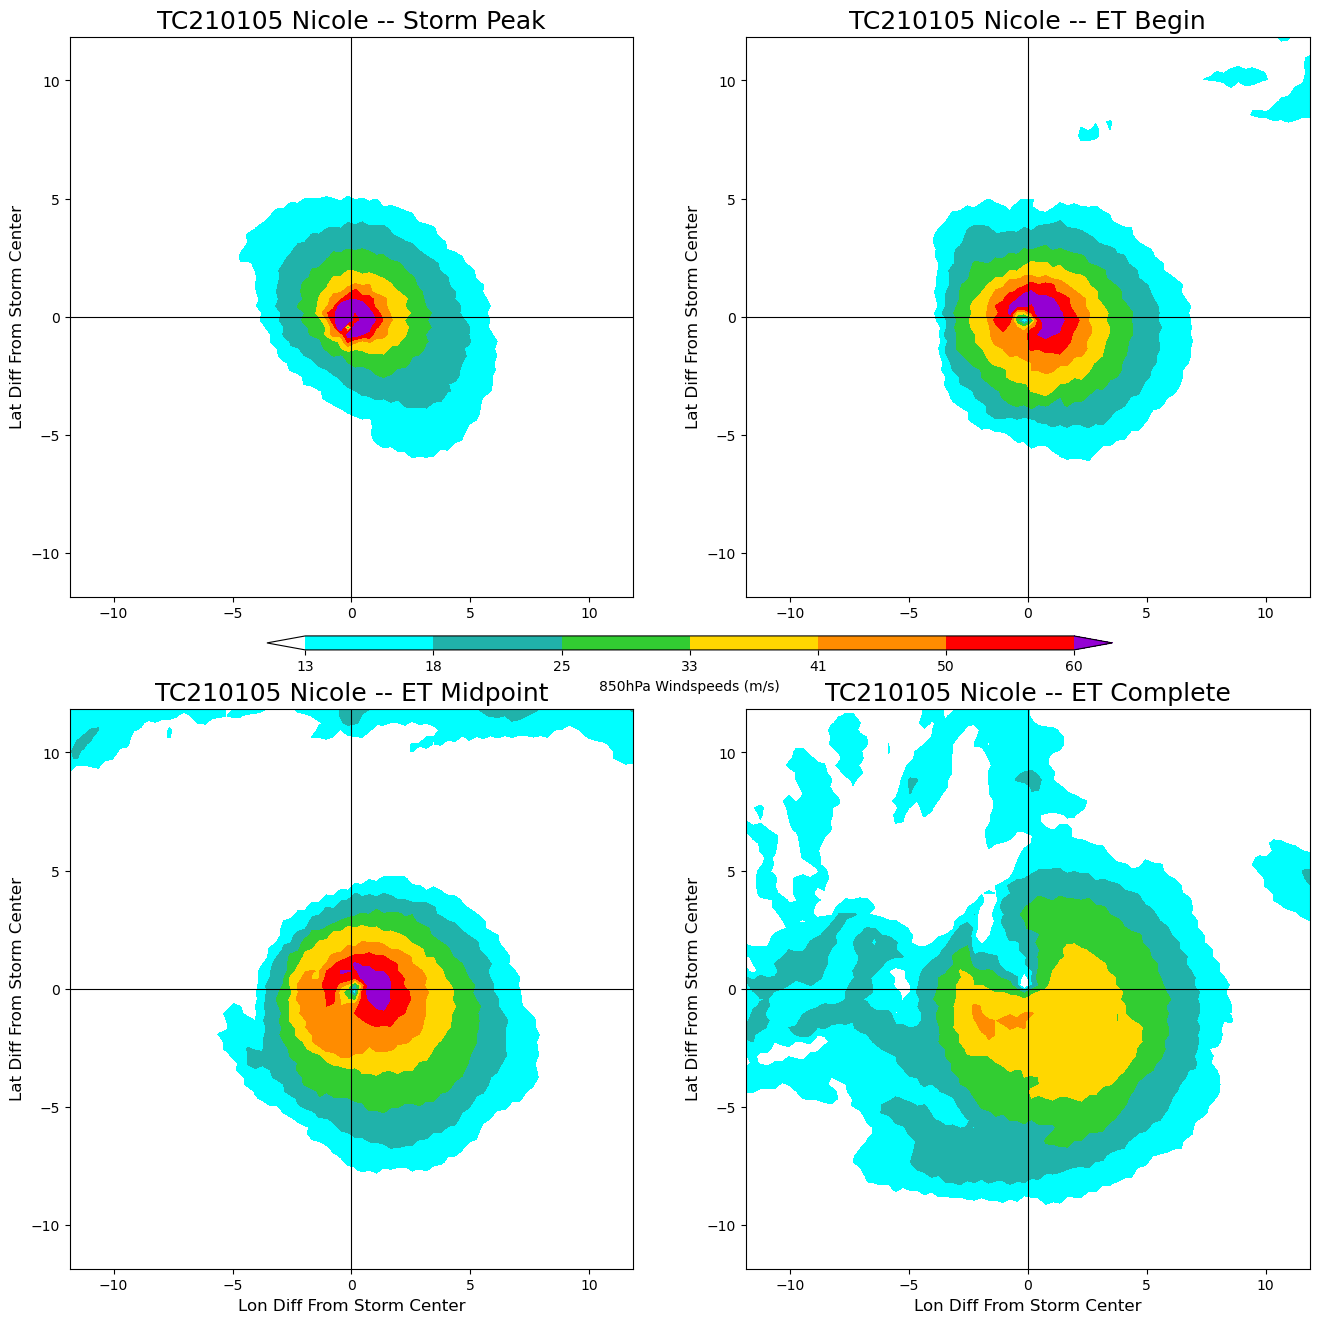

In [96]:
# Plot 850hPa Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Windspeed_Bounds, Windspeed_Colours, True)

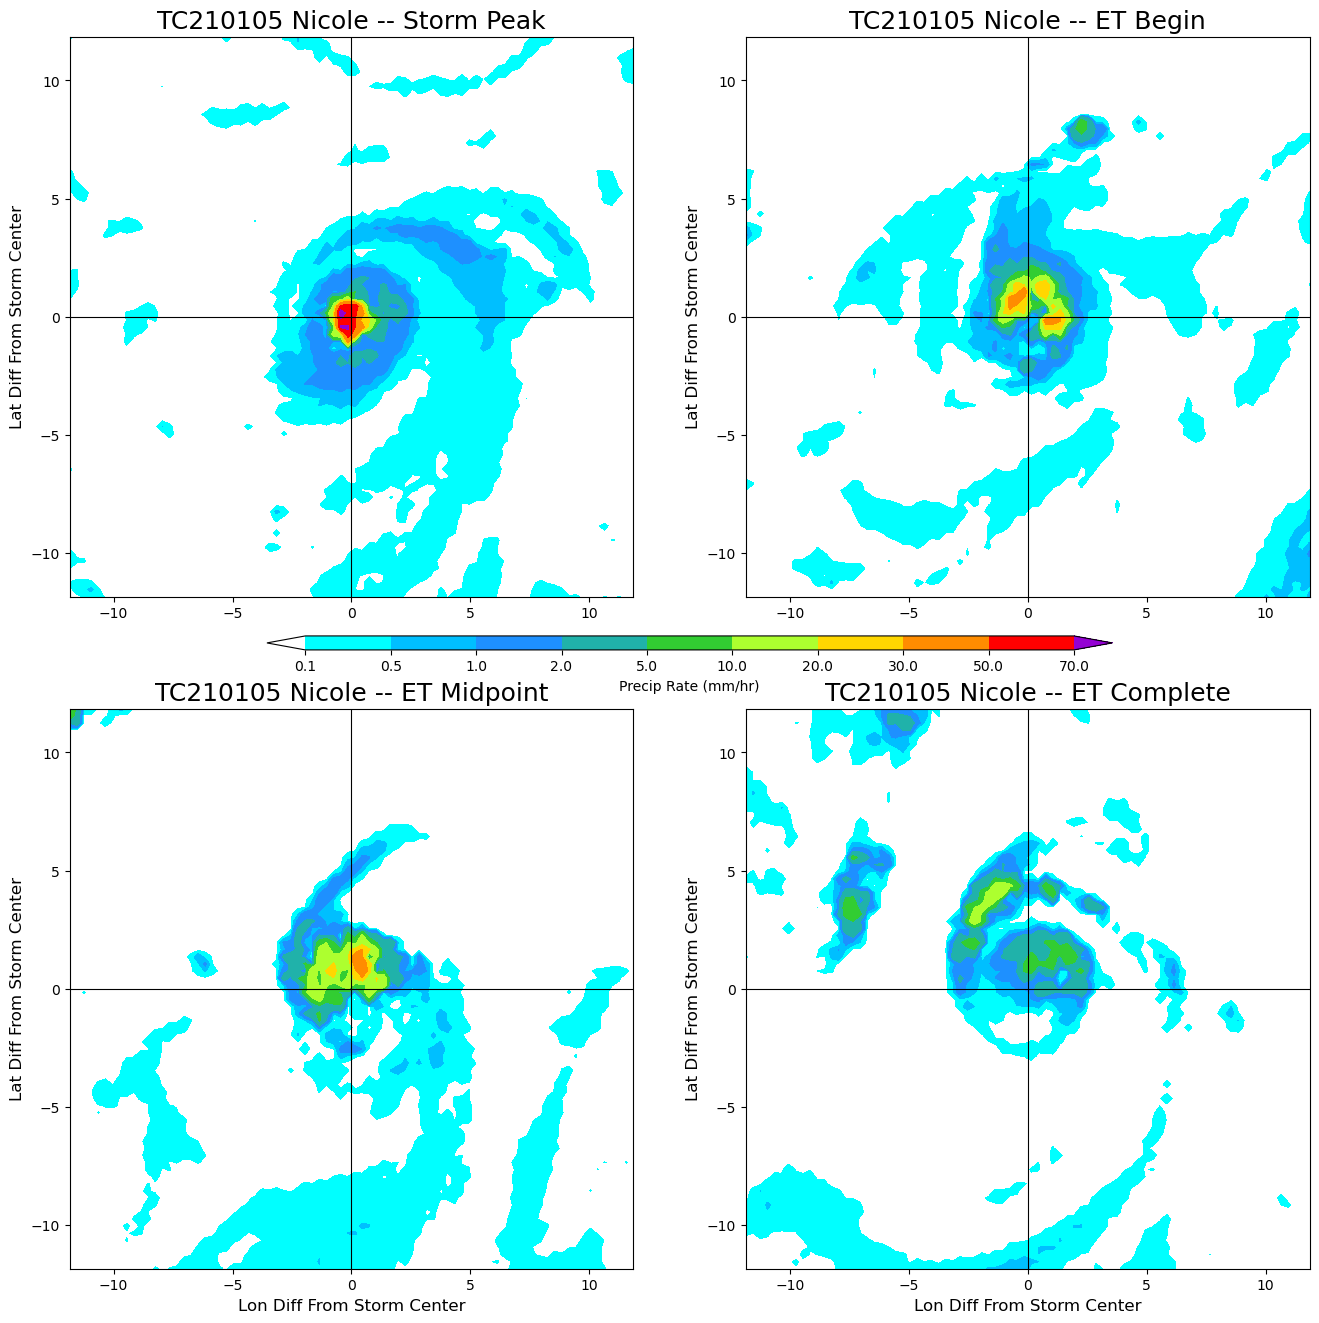

In [97]:
# Plot Precip Rate Snapshots
Precip_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Precip_Bounds, Precip_Colours, True)

In [98]:
# Find Wind Field Composite Data
Code = "TC213903"
Storm_Name = "Kyan"
Data_DF = RCP85_Data
ET_DF = RCP85_ET
Compo_DF = RCP85_Compo
Compo_nc = RCP85_B_Compo_nc
Time_Indexes = [1888,1890,1893,1896]
Time_Labels = ["Storm Peak", "ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [99]:
DF_Storm_Compo_Wind_Field

Compo Index                Time    Lon    Lat      SLP    Storm Phase  \
0        1858.0 2139-10-18 06:00:00 -39.56  35.29  1008.71       Tropical   
1        1859.0 2139-10-18 12:00:00 -39.47  35.10  1009.28       Tropical   
2        1860.0 2139-10-18 18:00:00 -39.24  34.62  1008.06       Tropical   
3        1861.0 2139-10-19 00:00:00 -39.15  34.44  1010.48       Tropical   
4        1862.0 2139-10-19 06:00:00 -38.63  34.25  1010.69       Tropical   
5        1863.0 2139-10-19 12:00:00 -38.83  33.77  1013.04       Tropical   
6        1864.0 2139-10-19 18:00:00 -38.32  33.58  1012.42       Tropical   
7        1865.0 2139-10-20 00:00:00 -37.39  33.64  1012.99       Tropical   
8        1866.0 2139-10-20 06:00:00 -37.23  33.90  1002.34       Tropical   
9        1867.0 2139-10-20 12:00:00 -37.00  33.96  1007.07       Tropical   
10       1868.0 2139-10-20 18:00:00 -37.30  34.63  1006.23       Tropical   
11       1869.0 2139-10-21 00:00:00 -37.67  34.86  1005.72       Tropical   
12       1870.0 2139-10-21 06:00:00 -37.99  34.98  1002.73       Tropical   
13       1871.0 2139-10-21 12:00:00 -38.53  34.62   998.76       Tropical   
14       1872.0 2139-10-21 18:00:00 -39.01  34.14   997.57       Tropical   
15       1873.0 2139-10-22 00:00:00 -38.70  33.47   995.46       Tropical   
16       1874.0 2139-10-22 06:00:00 -38.76  33.03   991.33       Tropical   
17       1875.0 2139-10-22 12:00:00 -38.62  32.73   982.38       Tropical   
18       1876.0 2139-10-22 18:00:00 -38.77  32.48   985.57       Tropical   
19       1877.0 2139-10-23 00:00:00 -39.15  31.80   982.73       Tropical   
20       1878.0 2139-10-23 06:00:00 -40.11  31.28   975.02       Tropical   
21       1879.0 2139-10-23 12:00:00 -41.06  30.40   974.82       Tropical   
22       1880.0 2139-10-23 18:00:00 -42.23  30.35   968.43       Tropical   
23       1881.0 2139-10-24 00:00:00 -43.26  29.98   969.47       Tropical   
24       1882.0 2139-10-24 06:00:00 -44.72  29.67   957.06       Tropical   
25       1883.0 2139-10-24 12:00:00 -45.61  29.56   963.65       Tropical   
26       1884.0 2139-10-24 18:00:00 -46.33  29.64   971.17       Tropical   
27       1885.0 2139-10-25 00:00:00 -46.97  29.84   968.74       Tropical   
28       1886.0 2139-10-25 06:00:00 -47.23  30.33   964.00       Tropical   
29       1887.0 2139-10-25 12:00:00 -47.47  31.27   954.48       Tropical   
30       1888.0 2139-10-25 18:00:00 -47.53  32.64   936.80       Tropical   
31       1889.0 2139-10-26 00:00:00 -47.24  34.36   934.51       Tropical   
32       1890.0 2139-10-26 06:00:00 -46.44  36.45   944.41     Transition   
33       1891.0 2139-10-26 12:00:00 -44.86  38.54   962.76     Transition   
34       1892.0 2139-10-26 18:00:00 -43.24  40.35   974.43     Transition   
35       1893.0 2139-10-27 00:00:00 -41.01  41.48   986.05     Transition   
36       1894.0 2139-10-27 06:00:00 -38.54  42.80   989.54     Transition   
37       1895.0 2139-10-27 12:00:00 -35.25  44.18   991.94     Transition   
38       1896.0 2139-10-27 18:00:00 -31.05  45.72   992.04  Extratropical   
39       1897.0 2139-10-28 00:00:00 -26.13  47.09   993.46  Extratropical   
40       1898.0 2139-10-28 06:00:00 -20.02  47.69   993.27  Extratropical   
41       1899.0 2139-10-28 12:00:00 -14.25  47.50   995.33  Extratropical   
42       1900.0 2139-10-28 18:00:00  -8.25  47.50   995.33  Extratropical   
43       1901.0 2139-10-29 00:00:00  -0.25  47.00   995.31  Extratropical   

    850hPa Winds  850hPa 18m/s  850hPa 25m/s  850hPa 33m/s  Max Precip Rate  \
0      23.485807          43.0           0.0           0.0        28.793543   
1      18.772305           5.0           0.0           0.0        19.464693   
2      16.692461           0.0           0.0           0.0        12.860379   
3      16.086525           0.0           0.0           0.0         3.574338   
4      13.417128           0.0           0.0           0.0         8.507867   
5      22.374712          11.0           0.0           0.0      

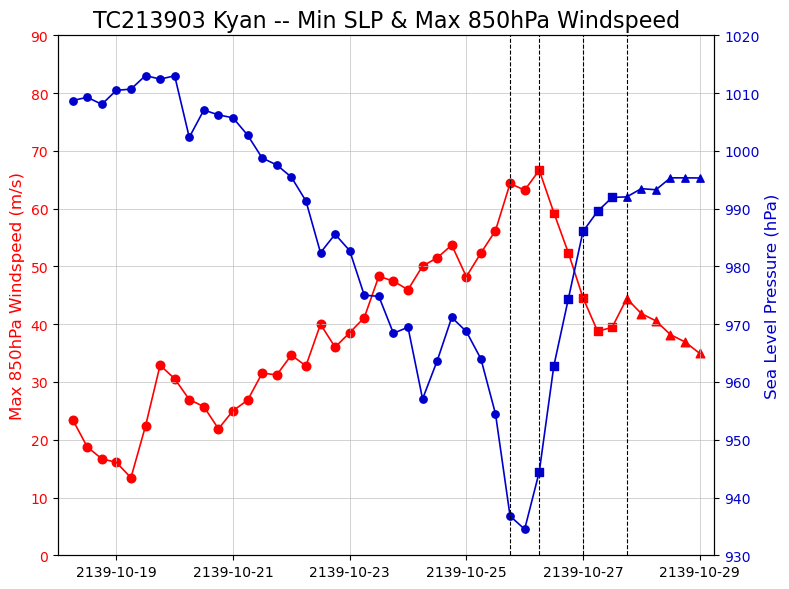

In [100]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

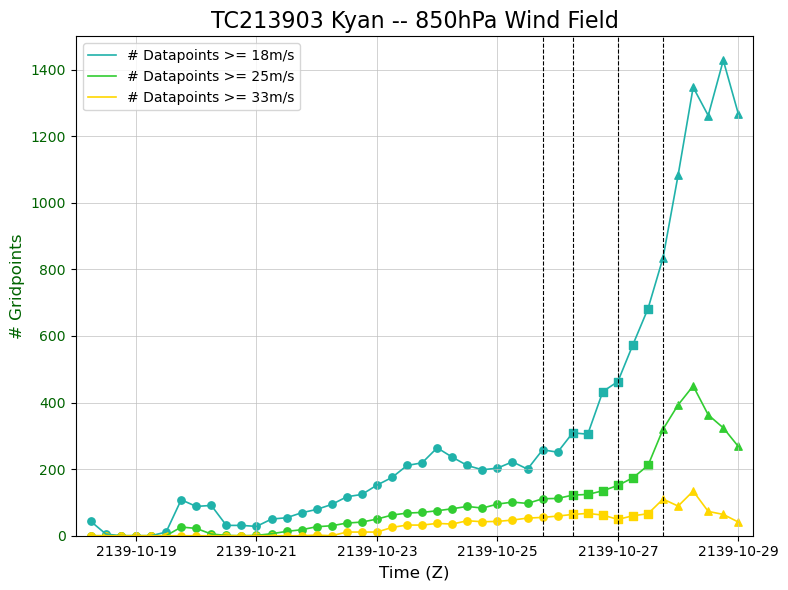

In [101]:
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

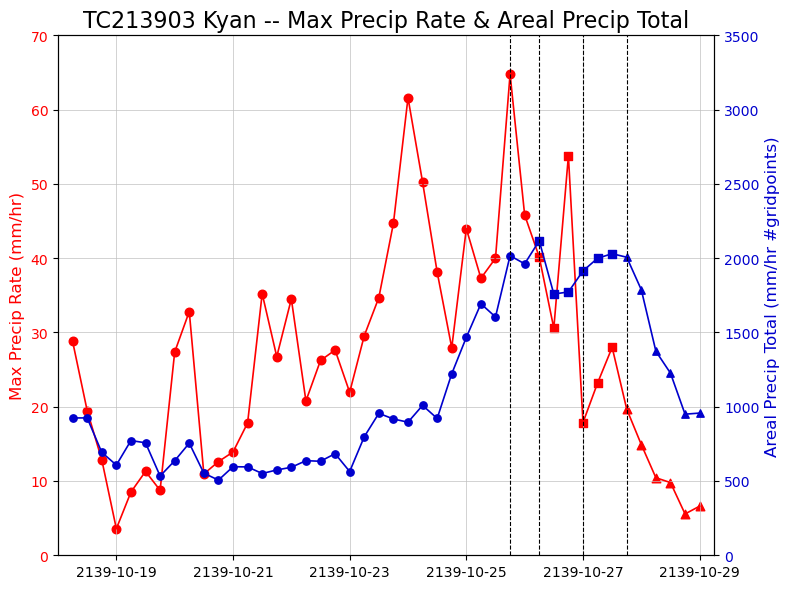

In [102]:
# Plot Max Precip Rate and Areal Precip Total
Precip_Area_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

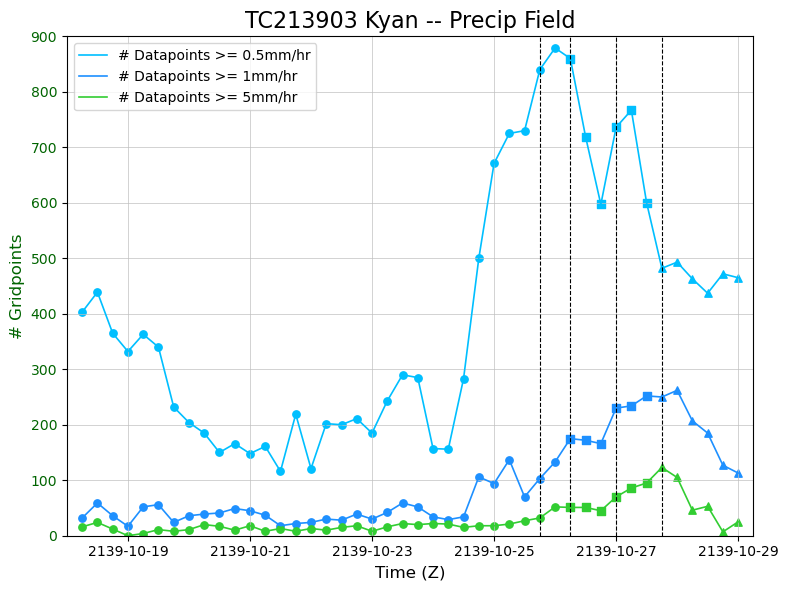

In [103]:
# Plot Precip Field Information
Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

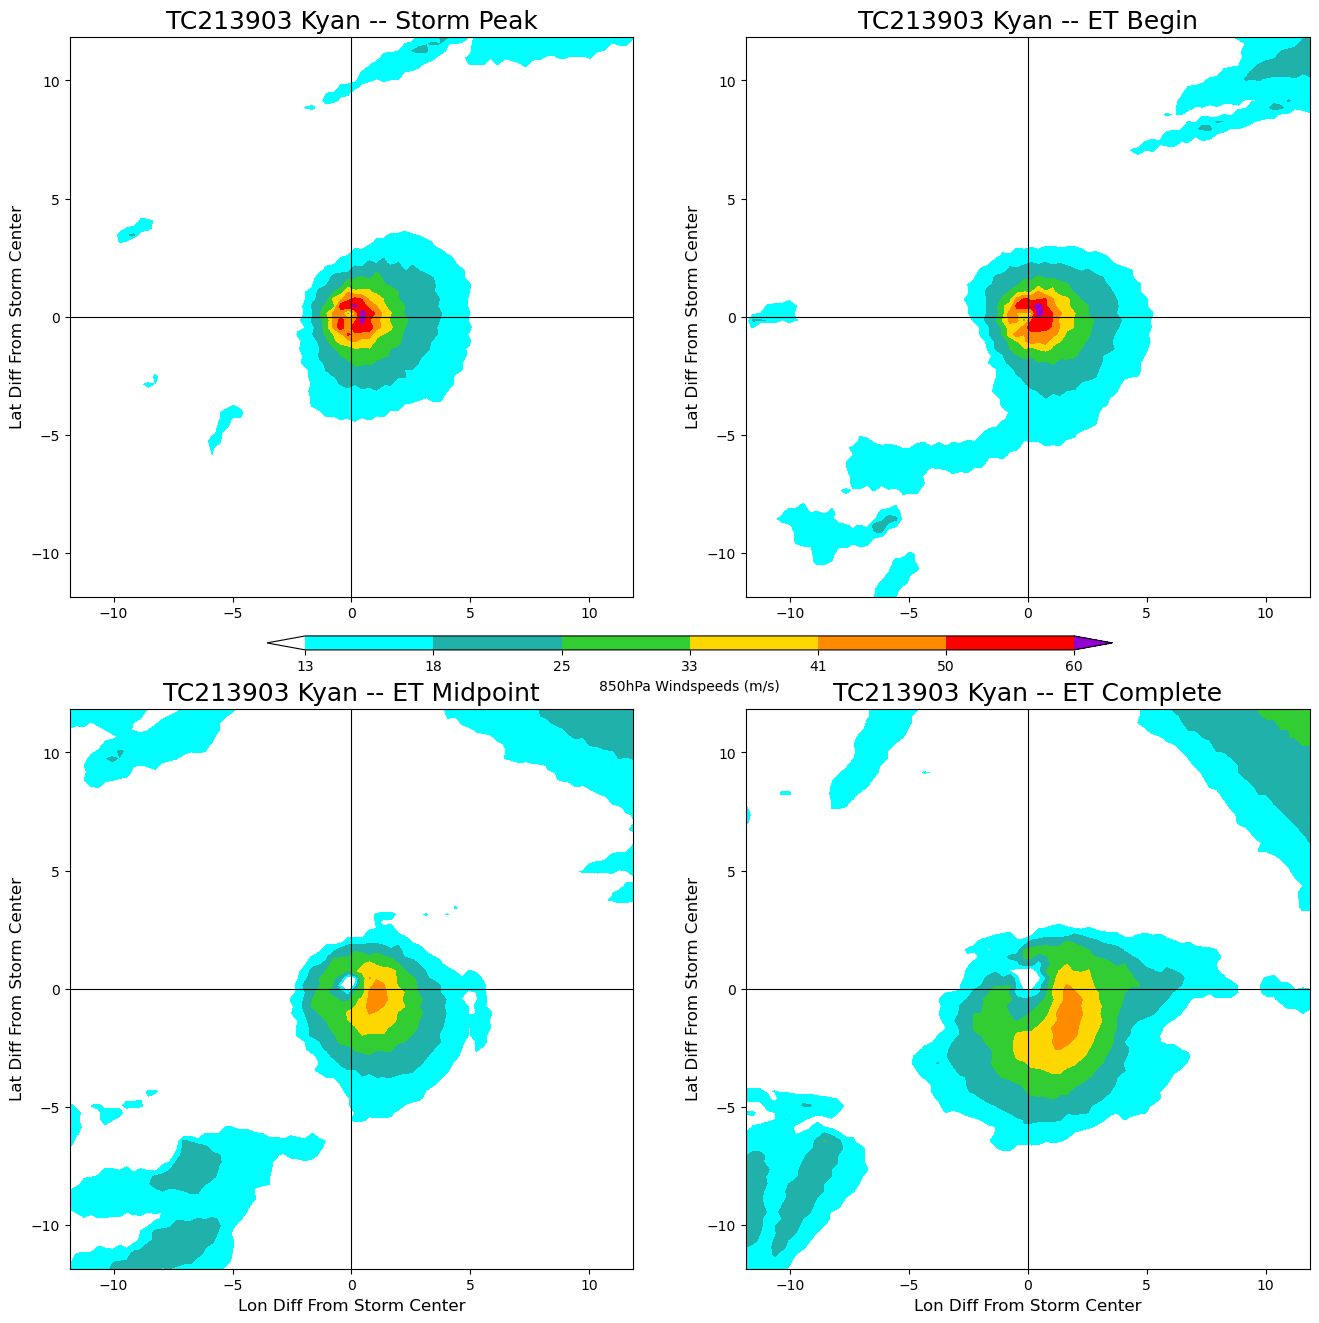

In [104]:
# Plot 850hPa Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Windspeed_Bounds, Windspeed_Colours, True)

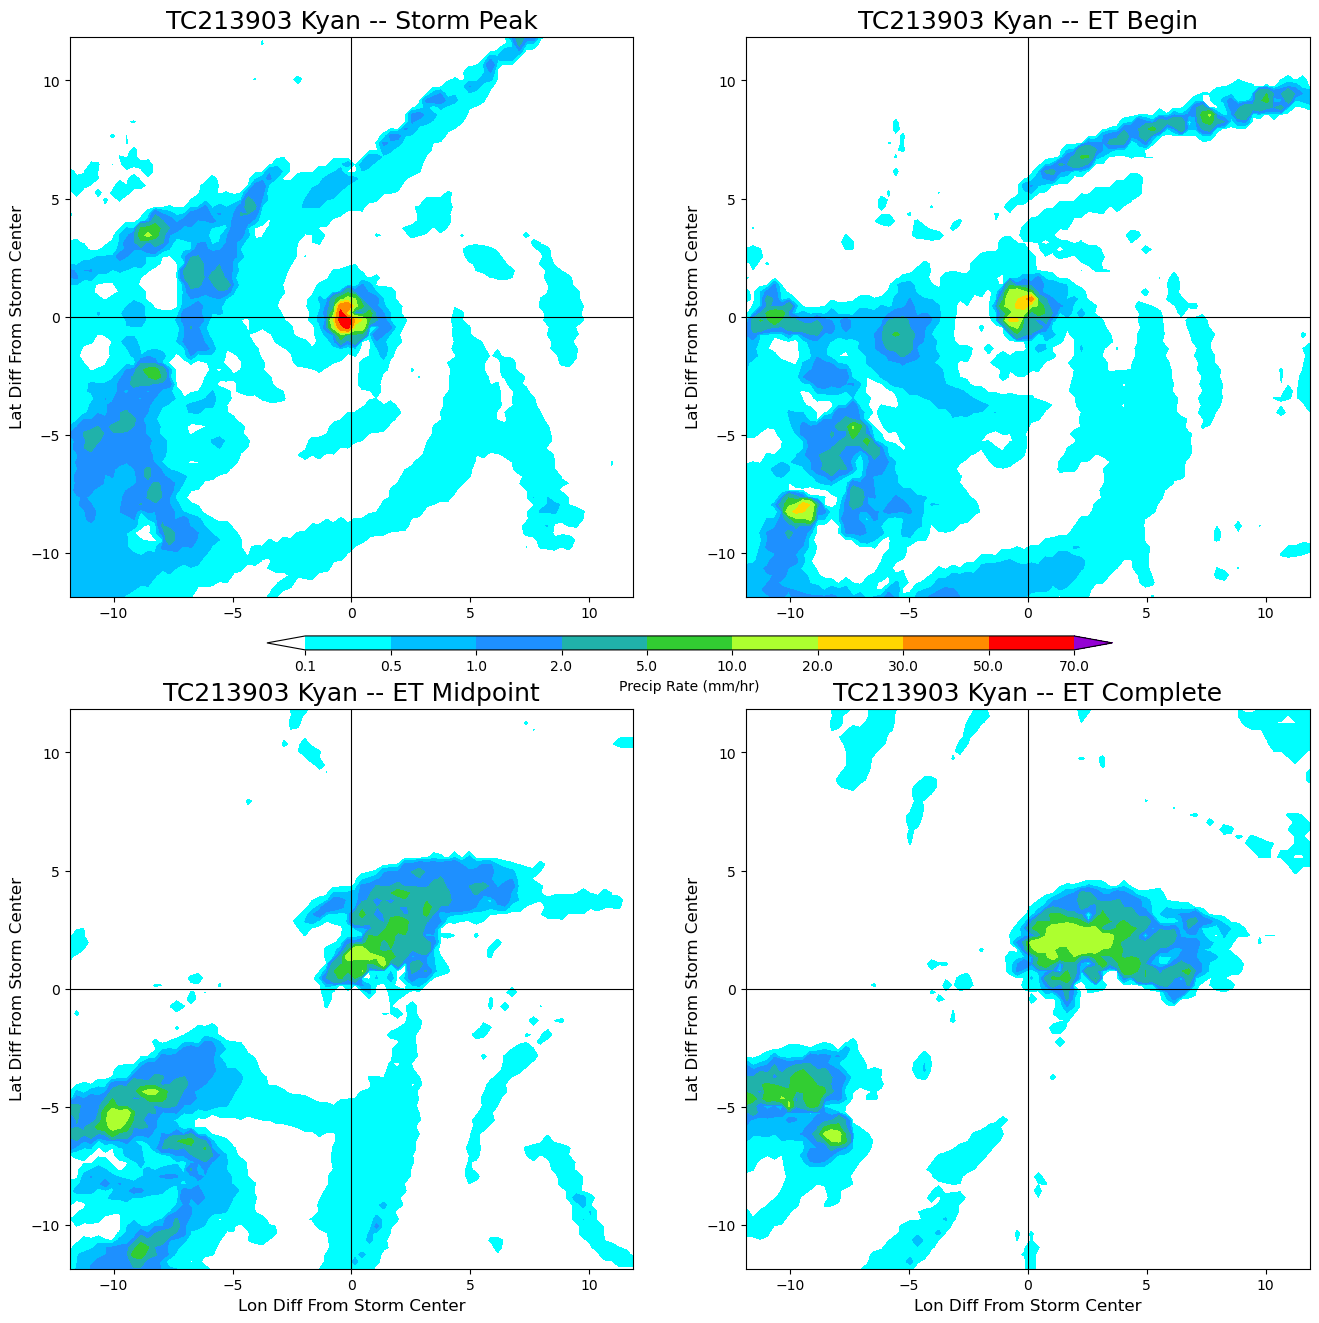

In [105]:
# Plot Precip Rate Snapshots
Precip_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Precip_Bounds, Precip_Colours, True)

In [106]:
# Find Wind Field Composite Data
Code = "TC216105"
Storm_Name = "Rachel"
Data_DF = RCP85_Data
ET_DF = RCP85_ET
Compo_DF = RCP85_Compo
Compo_nc = RCP85_B_Compo_nc
Time_Indexes = [6819,6837,6841,6845]
Time_Labels = ["Initial Storm Peak", "Storm Peak/ET Begin", "ET Midpoint", "ET Complete"]
DF_Storm_Compo = Find_Composite_Data(Code, Data_DF, Compo_DF)
DF_Storm_Compo_Wind_Field, Time_List = Wind_Field_Find(DF_Storm_Compo, Compo_nc)
DF_Storm_Compo_Precip_Field, Time_List = Precip_Field_Find(DF_Storm_Compo, Compo_nc)

In [107]:
DF_Storm_Compo_Wind_Field[50:]

Compo Index                Time    Lon    Lat     SLP    Storm Phase  \
50       6820.0 2161-09-24 06:00:00 -78.82  25.43  934.89       Tropical   
51       6821.0 2161-09-24 12:00:00 -79.03  25.69  921.82       Tropical   
52       6822.0 2161-09-24 18:00:00 -79.15  25.85  921.71       Tropical   
53       6823.0 2161-09-25 00:00:00 -79.20  25.56  924.87       Tropical   
54       6824.0 2161-09-25 06:00:00 -79.64  25.22  928.72       Tropical   
55       6825.0 2161-09-25 12:00:00 -79.81  25.09  926.22       Tropical   
56       6826.0 2161-09-25 18:00:00 -80.08  24.88  931.23       Tropical   
57       6827.0 2161-09-26 00:00:00 -80.08  24.88  932.27       Tropical   
58       6828.0 2161-09-26 06:00:00 -80.38  24.91  928.97       Tropical   
59       6829.0 2161-09-26 12:00:00 -80.38  24.91  923.33       Tropical   
60       6830.0 2161-09-26 18:00:00 -80.38  24.91  927.18       Tropical   
61       6831.0 2161-09-27 00:00:00 -80.38  24.91  927.16       Tropical   
62       6832.0 2161-09-27 06:00:00 -80.21  25.04  924.95       Tropical   
63       6833.0 2161-09-27 12:00:00 -79.73  25.68  918.13       Tropical   
64       6834.0 2161-09-27 18:00:00 -79.49  26.28  921.33       Tropical   
65       6835.0 2161-09-28 00:00:00 -78.71  26.88  919.06       Tropical   
66       6836.0 2161-09-28 06:00:00 -77.72  28.14  908.39       Tropical   
67       6837.0 2161-09-28 12:00:00 -76.81  29.49  902.08     Transition   
68       6838.0 2161-09-28 18:00:00 -75.74  31.20  902.39     Transition   
69       6839.0 2161-09-29 00:00:00 -74.43  32.78  903.95     Transition   
70       6840.0 2161-09-29 06:00:00 -72.93  34.71  915.37     Transition   
71       6841.0 2161-09-29 12:00:00 -70.64  36.64  923.80     Transition   
72       6842.0 2161-09-29 18:00:00 -68.90  39.24  933.05     Transition   
73       6843.0 2161-09-30 00:00:00 -66.23  41.56  944.94     Transition   
74       6844.0 2161-09-30 06:00:00 -63.20  44.13  958.83     Transition   
75       6845.0 2161-09-30 12:00:00 -60.52  46.98  970.65  Extratropical   
76       6846.0 2161-09-30 18:00:00 -56.77  48.71  979.28  Extratropical   
77       6847.0 2161-10-01 00:00:00 -52.29  53.23  977.58  Extratropical   
78       6848.0 2161-10-01 06:00:00 -50.19  54.51  974.70  Extratropical   

    850hPa Winds  850hPa 18m/s  850hPa 25m/s  850hPa 33m/s  Max Precip Rate  \
50     71.421432         340.0         169.0          75.0        62.955826   
51     72.287354         390.0         187.0          89.0        48.309982   
52     70.815895         451.0         205.0         100.0        53.670994   
53     74.353783         451.0         198.0         102.0        67.864433   
54     69.914795         493.0         225.0         109.0        69.822388   
55     74.750763         489.0         244.0         112.0        88.361649   
56     74.812805         530.0         287.0         135.0        76.290009   
57     69.182159         546.0         291.0         133.0        70.234062   
58     73.668861         544.0         304.0         137.0        38.683052   
59     66.443825         547.0         294.0         150.0        88.453758   
60     67.606918         610.0         294.0         156.0        81.750084   
61     70.004402         671.0         353.0         159.0        57.110157   
62     70.033539         744.0         402.0         198.0        91.439171   
63     71.118317         899.0         487.0         247.0        59.858589   
64     66.902122         996.0         558.0         304.0        65.860863   
65     76.072243        1085.0         596.0         330.0        74.545799   
66     81.842316        1263.0         670.0         380.0        67.223000   
67     78.980141        1352.0         696.0         416.0        80.824989   
68     81.367538        1381.0         750.0         461.0        70.191284   
69     77.762726        1326.0         761.0         455.0        68.357155   
70     74.339760        1535.0         852.0         481.0      

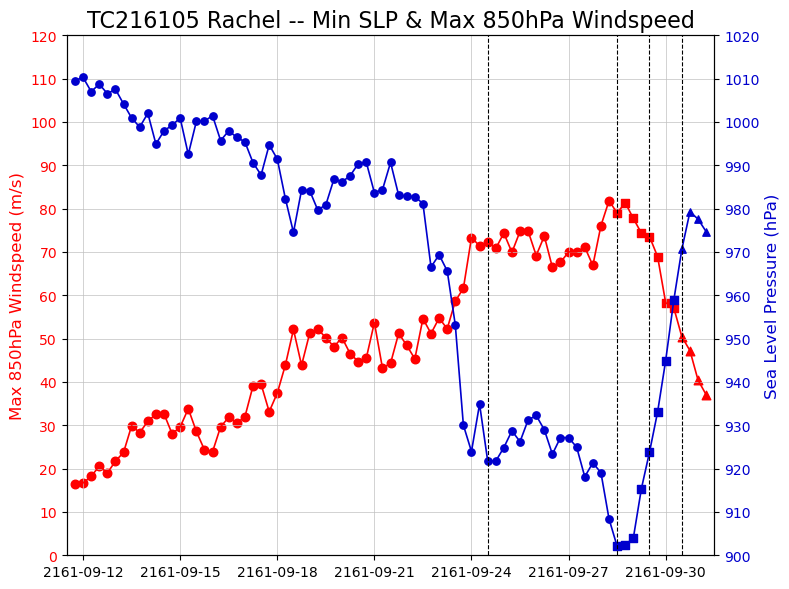

In [108]:
# Plot SLP VS Windspeed
SLP_Windspeed_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

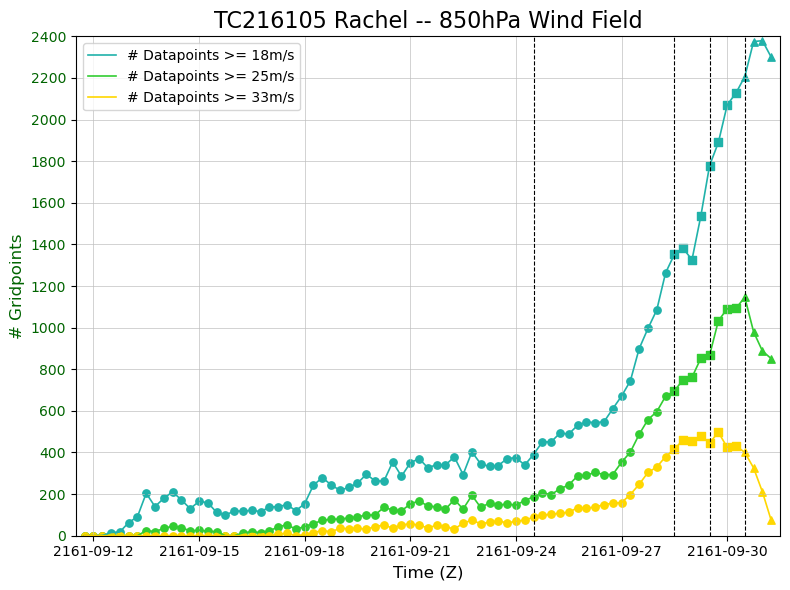

In [109]:
# Plot 850hPa Wind Field Information
Wind_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

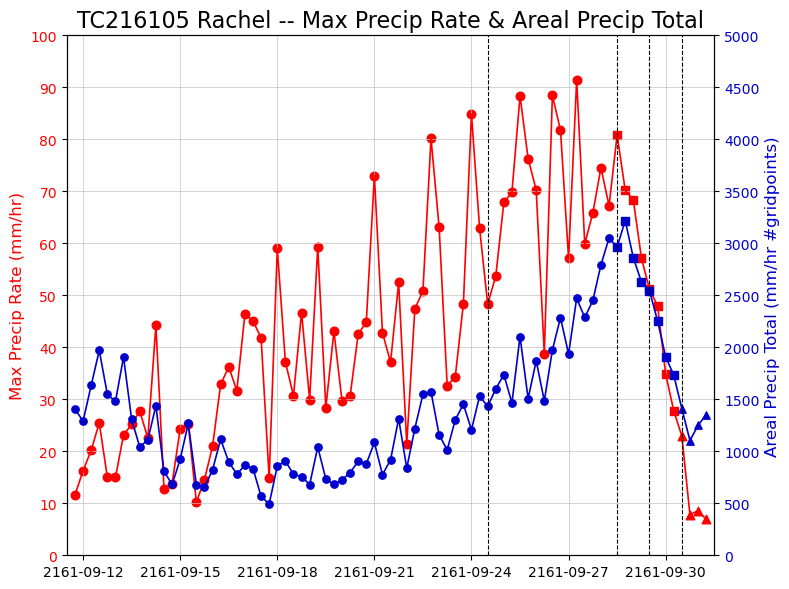

In [110]:
# Plot Max Precip Rate and Areal Precip Total
Precip_Area_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

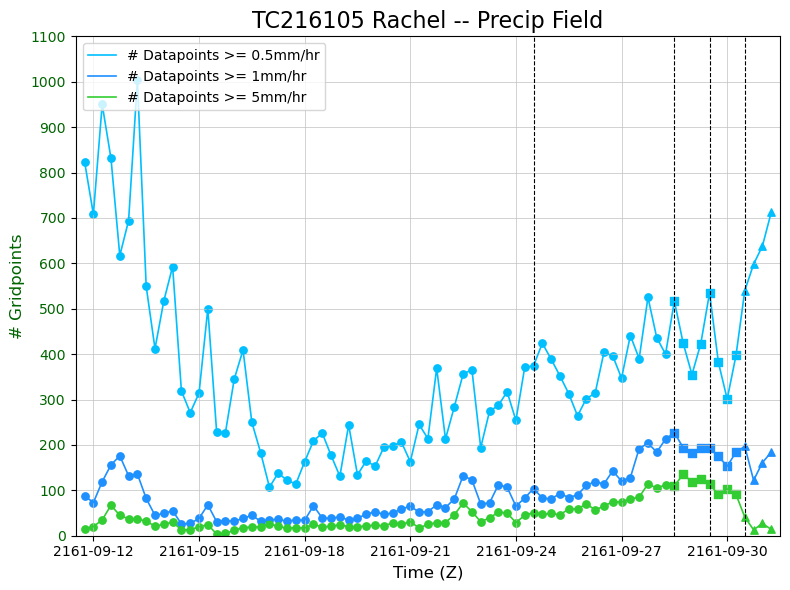

In [111]:
# Plot Precip Field Information
Precip_Field_Plots(Code, Storm_Name, Data_DF, ET_DF, Compo_DF, Compo_nc, Time_Indexes, True)

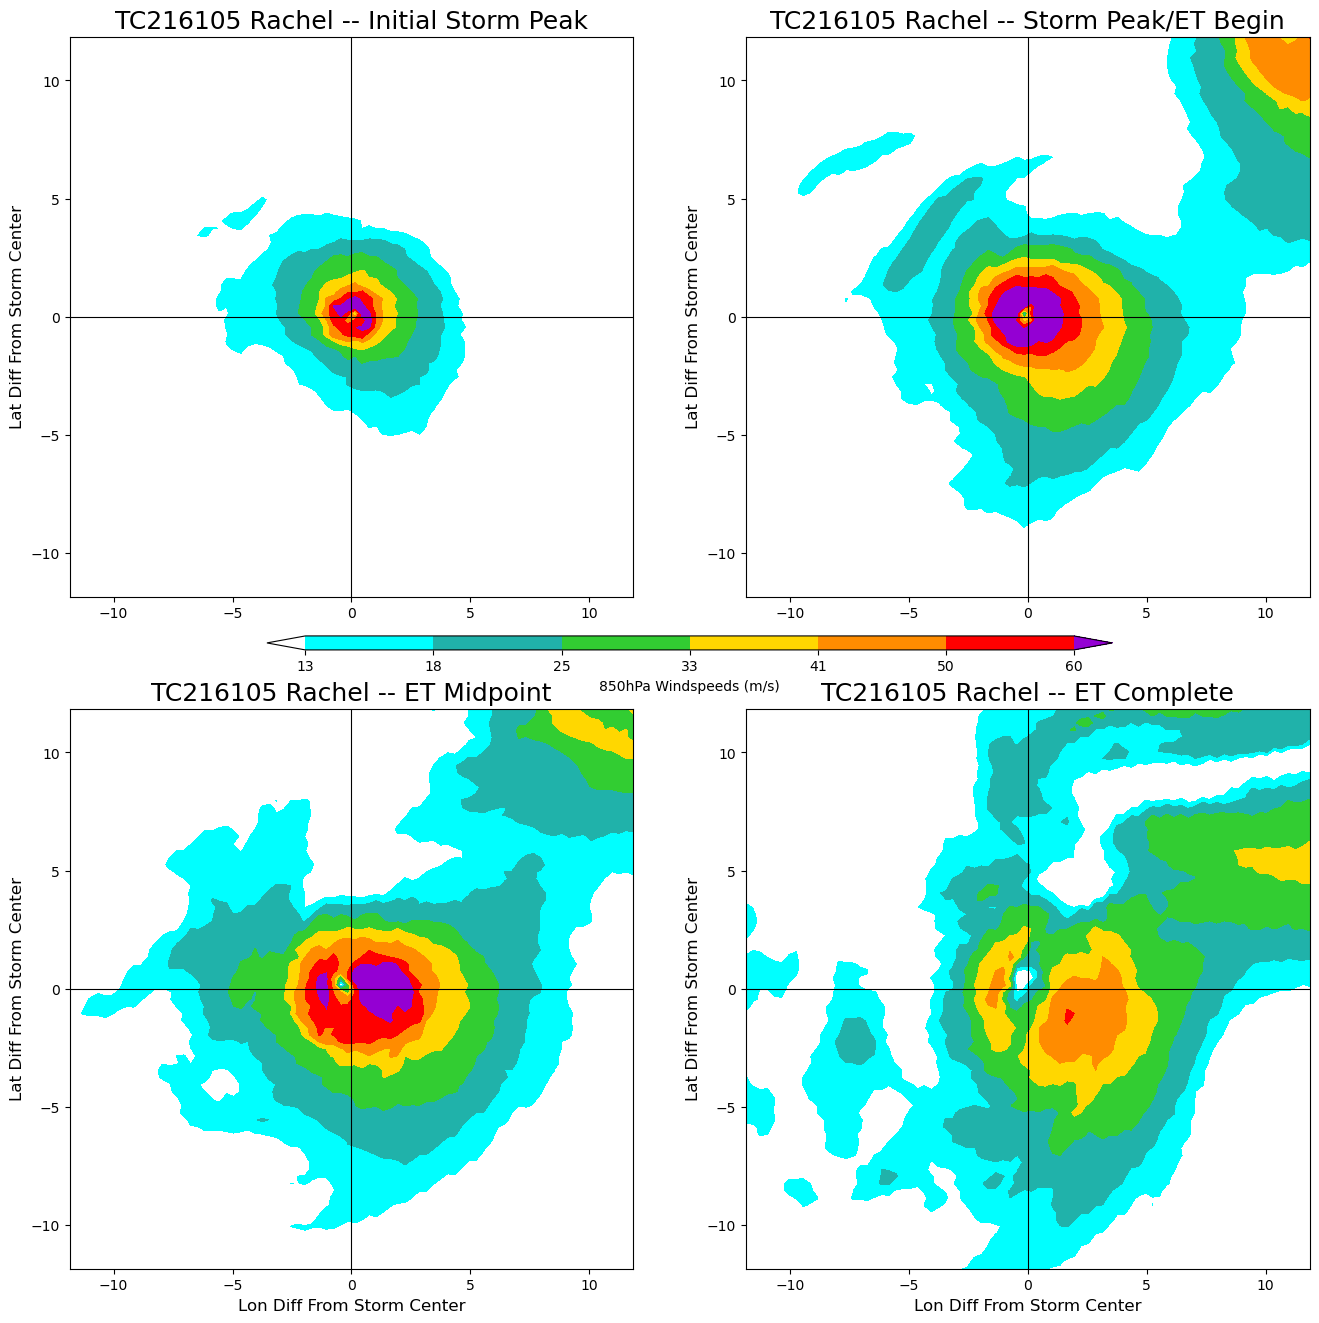

In [112]:
# Plot 850hPa Wind Field Snapshots
Windspeed_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Windspeed_Bounds, Windspeed_Colours, True)

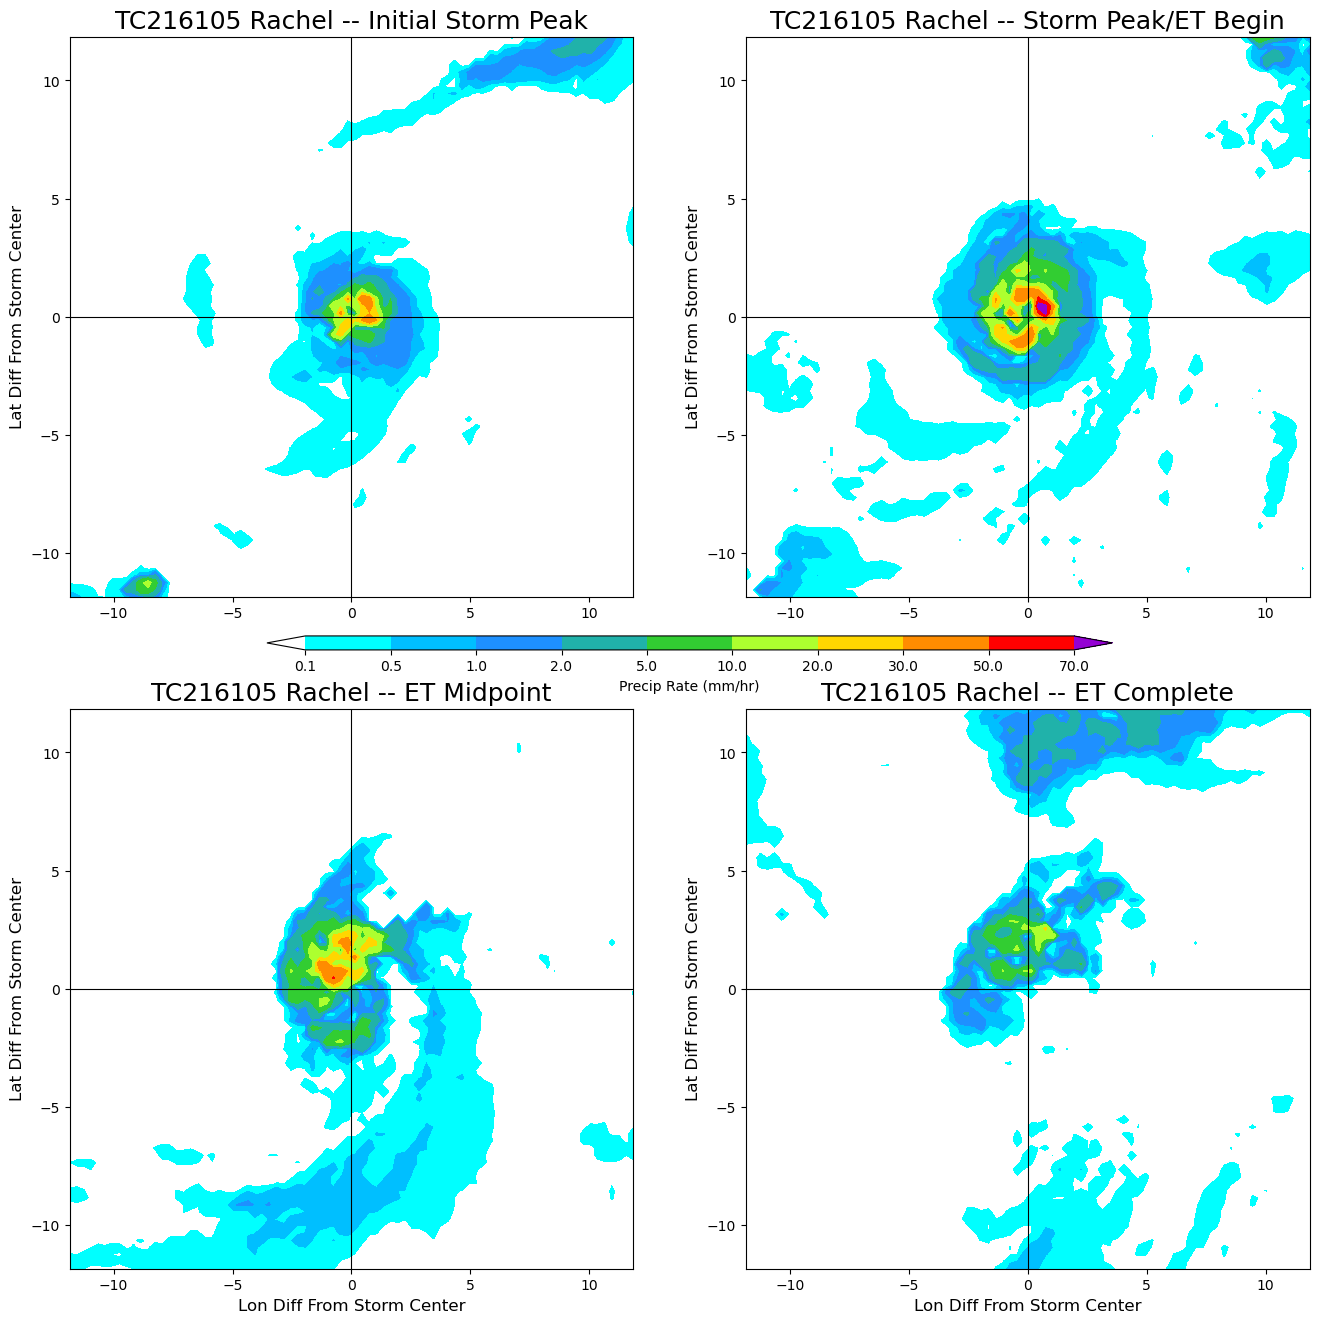

In [113]:
# Plot Precip Rate Snapshots
Precip_Snap_Plots(Compo_nc, Data_DF, Code, Storm_Name, Time_Indexes, Time_Labels, \
Precip_Bounds, Precip_Colours, True)